In [1]:
!pip install tensorflow_ranking

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_ranking as tfr
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, ConvLSTM1D, Flatten, LSTM, Permute, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Reshape, SpatialDropout1D, Dropout, TimeDistributed

from keras.regularizers import l2, l1


from sklearn.decomposition import PCA
from sklearn.utils import class_weight, shuffle
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import sklearn

import pickle

from featurize import featurize_acc_gyr

from scaler import CustomScaler

2023-03-07 09:52:46.132390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 09:52:46.926229: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-07 09:52:46.926320: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-07 09:52:46.926329: W tensorfl

In [3]:
file_name = "raw_with_maps"

x_data = np.load(f"data/processed/x_{file_name}_filtered.npy")[:,:,[0,1,2,4,5,6]] # pre-filtered data is "windowed_filtered"
feature_x_data = np.load(f"data/processed/x_{file_name}_features_acc_gyr.npy")
y_user = np.load(f"data/processed/y_user_{file_name}.npy")
y_intent = np.load(f"data/processed/y_intent_{file_name}.npy")
y_gesture = np.load(f"data/processed/y_gesture_type_{file_name}.npy")

train_gesture_map = np.load(f"data/processed/train_gesture_map_{file_name}.npy")
test_gesture_map = np.load(f"data/processed/test_gesture_map_{file_name}.npy")

In [4]:
#new_features = featurize_acc_gyr(np.load(f"data/processed/x_{file_name}_filtered.npy")[:,:,:8], filter_indices = [0,1,2,4,5,6])

In [5]:
#np.save(f"data/processed/x_{file_name}_features_acc_gyr.npy", new_features)

## RF approach

In [4]:
def get_eer(scores_legit, scores_adv):
    scores_legit = sorted(scores_legit)
    scores_adv = sorted(scores_adv)

    unique_scores_legit = sorted(set(scores_legit))
    
    #treat each legitimate sample distance as a possible threshold, determine the point where FRR crosses FAR
    for c, threshold in enumerate(unique_scores_legit):
        frr = sum(1 if x < threshold else 0 for x in scores_legit) / len(scores_legit)
        far = sum(1 if x >= threshold else 0 for x in scores_adv) / len(scores_adv)
        if frr >= far:
            return threshold, far, frr
    print("Failure")

def get_far_when_zero_frr(scores_legit, scores_adv):
    scores_legit = sorted(scores_legit)
    scores_adv = sorted(scores_adv)

    unique_scores_legit = sorted(set(scores_legit))
    
    last_far = 1.0
    last_frr = 0.0
    last_threshold = 0.0
    
    #treat each legitimate sample distance as a possible threshold, determine the point with the lowest FAR that satisfies the condition that FRR = 0
    for c, threshold in enumerate(unique_scores_legit):
        frr = sum(1 if x < threshold else 0 for x in scores_legit) / len(scores_legit)
        far = sum(1 if x >= threshold else 0 for x in scores_adv) / len(scores_adv)
        if frr > 0.001:
            return last_threshold, last_far, last_frr
        last_far = far
        last_frr = frr
        last_threshold = threshold

scores_legit = [i / 100 for i in range(30,101)]
scores_adv = [i / 100 for i in range(5, 85)]
display(get_eer(scores_legit, scores_adv))
display(get_far_when_zero_frr(scores_legit, scores_adv))

(0.56, 0.3625, 0.36619718309859156)

(0.3, 0.6875, 0.0)

In [5]:
def show_evaluate_model(labels_test, labels_pred, labels_scores, verbose = 1):
    

    fmeasure = f1_score(labels_test, labels_pred, average = "binary", labels = np.unique(labels_pred)) 
    auroc = sklearn.metrics.roc_auc_score(labels_test, labels_scores, labels = np.unique(labels_pred))

    scores_legit = [labels_scores[i] for i in range(len(labels_test)) if 1 == labels_test[i]]
    scores_adv = [labels_scores[i] for i in range(len(labels_test)) if 0 == labels_test[i]]

    eer_theta, eer, frr_at_eer = get_eer(scores_legit, scores_adv)
    far_theta, far, frr_at_zero_frr = get_far_when_zero_frr(scores_legit, scores_adv)
    
    if verbose:
        plt.hist(labels_scores, bins=100)
        plt.show()
        print(f"F1 score        : {fmeasure}")
        print(f"AUROC           : {auroc}")
        print(f"EER             : {eer}")
        print(f"frr_at_eer      : {frr_at_eer}")
        print(f"far at zero frr : {far}")
        print(f"frr at 'zero' frr : {frr_at_zero_frr}")

    accuracy = sum(labels_test == labels_pred) / len(labels_test)
    
    return {"fmeasure":fmeasure, "auroc":auroc, "eer_theta":eer_theta, "eer":eer, "frr_at_eer":frr_at_eer, 
            "far_theta":far_theta, "far":far, "frr_at_zero_frr":frr_at_zero_frr, "accuracy":accuracy}

In [16]:
_map = ((train_gesture_map == 1) | (y_intent == 0)) & (y_user.argmax(axis=1) != 0)
_test_map = ((test_gesture_map == 1) | (y_intent == 0) ) & (y_user.argmax(axis=1) == 0)

data_train = x_data[_map]
feature_data_train = feature_x_data[_map]
labels_train = y_intent[_map]


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

shuffled_data_train, shuffled_labels_train = shuffle(feature_data_train, labels_train, random_state=0)

standard_scaler = StandardScaler()
shuffled_data_train = standard_scaler.fit_transform(shuffled_data_train)

#kFold = sklearn.model_selection.StratifiedKFold(n_splits=5)
#val_map = next(kFold.split(shuffled_data_train, shuffled_labels_train))[1]

wa_model = RandomForestClassifier(n_estimators = 100, random_state = 0, class_weight={0:1,1:1}).fit(shuffled_data_train, shuffled_labels_train)





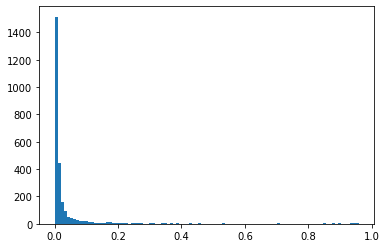

F1 score        : 0.8
AUROC           : 0.9966141798993029
EER             : 0.016266460108443067
frr_at_eer      : 0.03125
far at zero frr : 0.05073586367157242
frr at 'zero' frr : 0.0


{'fmeasure': 0.8,
 'auroc': 0.9966141798993029,
 'eer_theta': 0.3,
 'eer': 0.016266460108443067,
 'frr_at_eer': 0.03125,
 'far_theta': 0.14,
 'far': 0.05073586367157242,
 'frr_at_zero_frr': 0.0,
 'accuracy': 0.990551776266062}

In [19]:
labels_pred = wa_model.predict(standard_scaler.transform(feature_x_data[_test_map]))
labels_scores = wa_model.predict_proba(standard_scaler.transform(feature_x_data[_test_map]))[:, 1]

labels_test = y_intent[_test_map]

#stat_dict = {"labels_pred": labels_pred, "labels_scores":labels_scores, "labels_test":labels_test}
#with open(f'data/stats/auth/RF_user={auth_user}.pickle', 'wb') as f:
#    pickle.dump(stat_dict, f)

show_evaluate_model(labels_test, labels_pred, labels_scores)

In [20]:
class SplitLayer(tf.keras.layers.Layer):
    def __init__(self, layers):
        super(SplitLayer, self).__init__()
        self.layers = layers

    def call(self, inputs):
        return tf.gather(inputs,indices=self.layers,axis=-1)

def get_mlp_model(input_dim=(200,6), outputs=1):
    inputs = keras.Input(shape=input_dim)
    x = inputs
    
    x = Flatten()(x)
    x = Dense(50, activation="relu")(x)
    x = Dense(50, activation="relu")(x)
    x = Dense(50, activation="relu")(x)
    x = Dense(50, activation="relu")(x)
    x = Dense(50, activation="relu")(x)
    x = Dense(50, activation="relu")(x)
    #x = Dropout(0.1)(x)
    if outputs == 1:
        x = Dense(1, activation="sigmoid")(x)
    else:
        x = Dense(outputs, activation="softmax")(x)
    
    out = x
    
    model = keras.Model(inputs, out, name="MLP_classifier")
    
    return model
    
def get_lstm_model(input_dim=(200,6)):
    inputs = keras.Input(shape=input_dim)
    x = inputs
    
    x = LSTM(60, return_sequences=True)(x)
    x = LSTM(60, return_sequences=True)(x)
    x = LSTM(60)(x)
    
    x = Dense(25, activation="relu")(x)
    x = Dense(10, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    out = x
    model = keras.Model(inputs, x, name="LSTM_classifier")
    return model

def get_simple_conv_model():
    # requires input dim with 6 channels for dimensions
    input_dim = (200,6)
    
    inputs = keras.Input(shape=input_dim)
    x = inputs    
    
    xs = []
    last_output_channels = 26
    for a in range(5):
        x = Conv1D(last_output_channels * 6, 3, strides=1, groups=input_dim[1], padding="same", activation="relu")(x)
        x = MaxPooling1D(pool_size=2, strides=None, padding="same")(x)
    
    x = Flatten()(x)

    x = Dense(25, activation="relu")(x)
    x = Dense(10, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    out = x

    model = keras.Model(inputs, out, name="simple_conv_classifier")
    
    return model

def get_complex_conv_model():
    input_dim = (200,6)
    
    inputs = keras.Input(shape=input_dim)
    x = inputs    
    
    xs = []
    last_output_channels = 36
    for a in range(5):
        x = layers.BatchNormalization()(x)
        x1 = Conv1D(last_output_channels, 3, strides=1, padding="same", activation="relu")(x)
        x = layers.TimeDistributed(Dense(60, activation="relu"))(x1) # , kernel_regularizer=keras.regularizers.L1(1e-4)))(x) # 
        x = layers.Concatenate()([x,x1])
        # x = x1
        x = MaxPooling1D(pool_size=2, strides=None, padding="same")(x)
    
    x = Flatten()(x)
    #x = LSTM(50)(x)

    x = Dense(25, activation="relu")(x)
    x = Dense(10, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    out = x

    model = keras.Model(inputs, out, name="complex_conv_classifier")
    
    return model

def get_conv_lstm_model(input_dim=(200,6)):
    input_dim = (200,6)
    
    inputs = keras.Input(shape=input_dim)
    x = inputs    
    
    xs = []
    last_output_channels = 32
    for a in range(5):
        x = layers.BatchNormalization()(x)
        x1 = Conv1D(last_output_channels, 3, strides=1, padding="same", activation="relu")(x)
        x = layers.TimeDistributed(Dense(60, activation="relu"))(x1) # , kernel_regularizer=keras.regularizers.L1(1e-4)))(x) # 
        x = layers.Concatenate()([x,x1])
        # x = x1
        x = MaxPooling1D(pool_size=2, strides=None, padding="same")(x)
    
    #x = Flatten()(x)
    x = LSTM(50)(x)

    x = Dense(25, activation="relu")(x)
    x = Dense(10, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    out = x

    model = keras.Model(inputs, out, name="conv_LSTM_classifier")
    
    return model



#get_mlp_model().summary()
#get_lstm_model().summary()
#get_simple_conv_model().summary()
get_complex_conv_model().summary()
#get_conv_lstm_model().summary()

Model: "complex_conv_classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 6)]     0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 200, 6)      24          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv1d (Conv1D)                (None, 200, 36)      684         ['batch_normalization[0][0]']    
                                                                                                  
 time_distributed (TimeDistribu  (None, 200, 60)     2220        ['conv1d[0]

In [21]:
shuffled_data_train, shuffled_labels_train = shuffle(data_train, labels_train, random_state=0)

scaler = CustomScaler()
scaler.CHANNELS = 6
shuffled_data_train = scaler.fit_and_transform(shuffled_data_train)

np.unique(shuffled_labels_train, return_counts=True)

(array([0, 1], dtype=int32), array([28189,  2254]))

In [23]:
#model = get_new_auth_model((200,6)) # new_
model = get_complex_conv_model()
model.summary()

model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5))



kFold = sklearn.model_selection.StratifiedKFold(n_splits=5)
val_map = next(kFold.split(shuffled_data_train, shuffled_labels_train))[1]


val_map_all = np.zeros(len(shuffled_labels_train))
val_map_all[val_map] = 1

val_map = val_map_all == 1

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', start_from_epoch=10,
                                                           patience=50, restore_best_weights=True)

print(np.unique(shuffled_labels_train[val_map], return_counts=True))
print(np.unique(shuffled_labels_train[~val_map], return_counts=True))


history = model.fit(shuffled_data_train[~val_map], shuffled_labels_train[~val_map], epochs=3000,
                        batch_size=1024, verbose=1,
                        validation_data=(shuffled_data_train[val_map], shuffled_labels_train[val_map]),
                       class_weight={0:1, 1:15*4}, 
                   callbacks=[early_stopping_callback])
                       #)


#with open(f'data/models/DL/ConvLSTM_user={auth_user}.pickle', 'wb') as f:
#    pickle.dump(model, f)#

#with open(f'data/stats/auth/ConvLSTM_user={auth_user}_history.pickle', 'wb') as f:
#    pickle.dump(history, f)
    
"""
with tf.keras.utils.custom_object_scope({"SplitLayer":SplitLayer}):
    with open(f'data/models/DL/ConvLSTM_user={auth_user}.pickle', 'rb') as pickle_file:
        self.encoder = pickle.load(pickle_file)
"""



"""
for i in range(10):
    

    history = model.fit(shuffled_data_train[~val_map], shuffled_labels_train[~val_map], epochs=100,
                        batch_size=1024, verbose=1,
                        validation_data=(shuffled_data_train[val_map], shuffled_labels_train[val_map]),
                       class_weight={0:1, 1:60}, )
                       #callbacks=[early_stopping_callback])

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.clf()
    
    labels_scores = model.predict(scaler.transform(x_data[_test_map])).squeeze()

    #labels_scores = model.predict(shuffled_data_train[~val_map]).squeeze()
    labels_pred = (labels_scores >= 0.5).astype(int)

    labels_test = (y_user.argmax(axis=1) == auth_user)[_test_map].astype(int)

    show_evaluate_model(labels_test, labels_pred, labels_scores)
"""


Model: "complex_conv_classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200, 6)]     0           []                               
                                                                                                  
 batch_normalization_10 (BatchN  (None, 200, 6)      24          ['input_3[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 conv1d_10 (Conv1D)             (None, 200, 36)      684         ['batch_normalization_10[0][0]'] 
                                                                                                  
 time_distributed_10 (TimeDistr  (None, 200, 60)     2220        ['conv1d_10

"\nfor i in range(10):\n    \n\n    history = model.fit(shuffled_data_train[~val_map], shuffled_labels_train[~val_map], epochs=100,\n                        batch_size=1024, verbose=1,\n                        validation_data=(shuffled_data_train[val_map], shuffled_labels_train[val_map]),\n                       class_weight={0:1, 1:60}, )\n                       #callbacks=[early_stopping_callback])\n\n    plt.plot(history.history['loss'])\n    plt.plot(history.history['val_loss'])\n    plt.title('model loss')\n    plt.ylabel('loss')\n    plt.xlabel('epoch')\n    plt.legend(['train', 'val'], loc='upper left')\n    plt.show()\n\n    plt.clf()\n    \n    labels_scores = model.predict(scaler.transform(x_data[_test_map])).squeeze()\n\n    #labels_scores = model.predict(shuffled_data_train[~val_map]).squeeze()\n    labels_pred = (labels_scores >= 0.5).astype(int)\n\n    labels_test = (y_user.argmax(axis=1) == auth_user)[_test_map].astype(int)\n\n    show_evaluate_model(labels_test, labels_

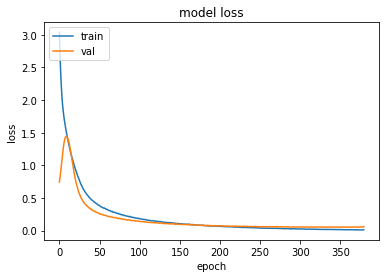

<Figure size 432x288 with 0 Axes>

In [24]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.clf()

83/83 [==============================] - 0s 2ms/step


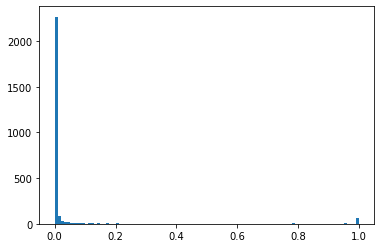

F1 score        : 0.7455621301775147
AUROC           : 0.9987594403563129
EER             : 0.013555383423702556
frr_at_eer      : 0.015625
far at zero frr : 0.039504260263361735
frr at 'zero' frr : 0.0


{'fmeasure': 0.7455621301775147,
 'auroc': 0.9987594403563129,
 'eer_theta': 0.5821544,
 'eer': 0.013555383423702556,
 'frr_at_eer': 0.015625,
 'far_theta': 0.11105734,
 'far': 0.039504260263361735,
 'frr_at_zero_frr': 0.0,
 'accuracy': 0.9837490551776266}

In [26]:
labels_scores = model.predict(scaler.transform(x_data[_test_map])).squeeze()

#labels_scores = model.predict(shuffled_data_train[~val_map]).squeeze()
labels_pred = (labels_scores >= 0.5).astype(int)

labels_test = y_intent[_test_map].astype(int)

#stat_dict = {"labels_pred": labels_pred, "labels_scores":labels_scores, "labels_test":labels_test}
#with open(f'data/stats/auth/ConvMixing_user={auth_user}.pickle', 'wb') as f:
#    pickle.dump(stat_dict, f)

show_evaluate_model(labels_test, labels_pred, labels_scores)

## Running all models

In [9]:
def save_stats_dict(labels_pred, labels_scores, labels_test, handle):
    stat_dict = {"labels_pred": labels_pred, "labels_scores":labels_scores, "labels_test":labels_test}
    with open(f'data/stats/auth/{handle}.pickle', 'wb') as f:
        pickle.dump(stat_dict, f)
        
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

################   0   ####################
RF


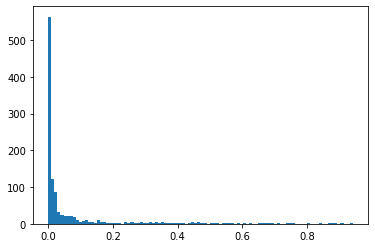

F1 score        : 0.5825242718446603
AUROC           : 0.9658729187071498
EER             : 0.0901077375122429
frr_at_eer      : 0.109375
far at zero frr : 0.4720861900097943
frr at 'zero' frr : 0.0


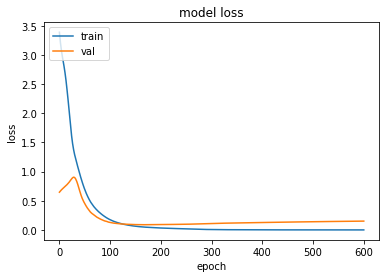

34/34 [==============================] - 0s 1ms/step
MLP


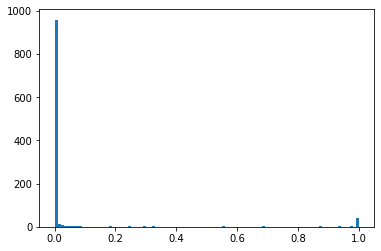

F1 score        : 0.7591240875912408
AUROC           : 0.9848647159647405
EER             : 0.04407443682664055
frr_at_eer      : 0.078125
far at zero frr : 0.12438785504407443
frr at 'zero' frr : 0.0


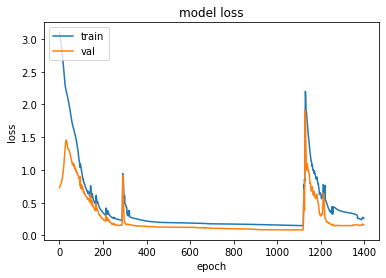

34/34 [==============================] - 1s 10ms/step
LSTM


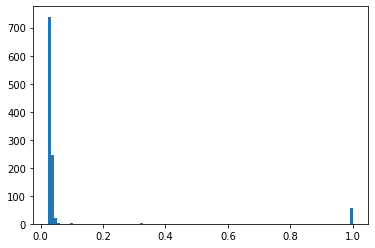

F1 score        : 0.796875
AUROC           : 0.9044441723800196
EER             : 0.12242899118511263
frr_at_eer      : 0.125
far at zero frr : 0.9441723800195886
frr at 'zero' frr : 0.0


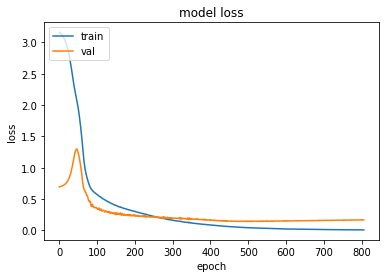

34/34 [==============================] - 1s 21ms/step
simpleConv


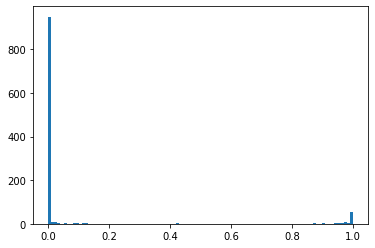

F1 score        : 0.7333333333333334
AUROC           : 0.9826533423114594
EER             : 0.04603330068560235
frr_at_eer      : 0.046875
far at zero frr : 0.3809990205680705
frr at 'zero' frr : 0.0


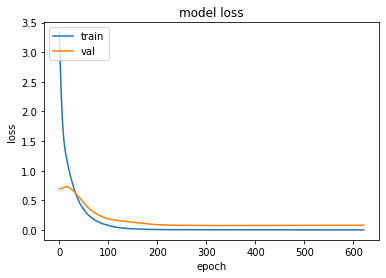

34/34 [==============================] - 0s 5ms/step
complexConv


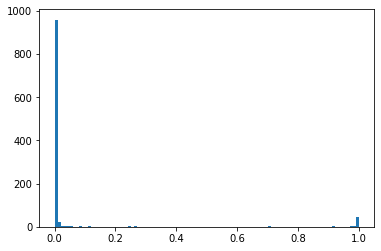

F1 score        : 0.8421052631578948
AUROC           : 0.9921339373163565
EER             : 0.04211557296767875
frr_at_eer      : 0.046875
far at zero frr : 0.11165523996082272
frr at 'zero' frr : 0.0


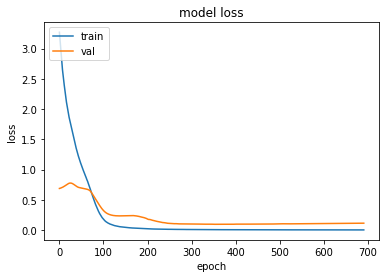

34/34 [==============================] - 1s 6ms/step
ConvLSTM


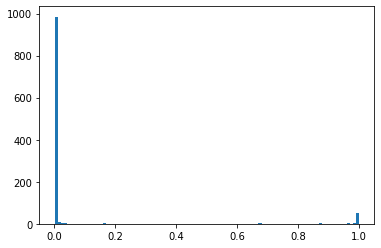

F1 score        : 0.7883211678832116
AUROC           : 0.9734176052889325
EER             : 0.05582761998041136
frr_at_eer      : 0.0625
far at zero frr : 0.6170421155729677
frr at 'zero' frr : 0.0
################   1   ####################
RF


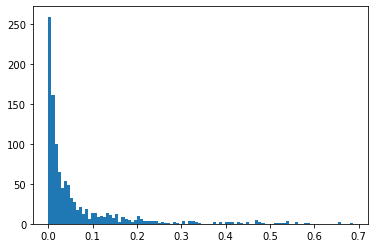

F1 score        : 0.35135135135135137
AUROC           : 0.963130081300813
EER             : 0.07414634146341463
frr_at_eer      : 0.11666666666666667
far at zero frr : 0.3853658536585366
frr at 'zero' frr : 0.0


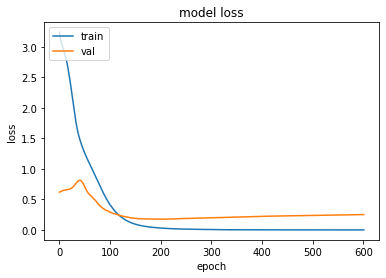

34/34 [==============================] - 0s 1ms/step
MLP


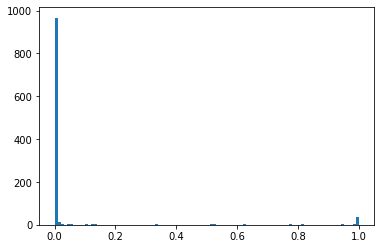

F1 score        : 0.7419354838709677
AUROC           : 0.9814471544715446
EER             : 0.06634146341463415
frr_at_eer      : 0.06666666666666667
far at zero frr : 0.27414634146341466
frr at 'zero' frr : 0.0


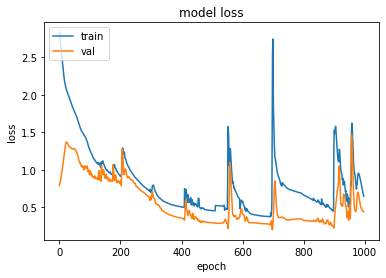

34/34 [==============================] - 1s 10ms/step
LSTM


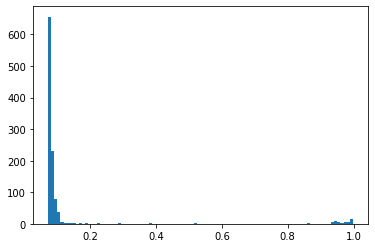

F1 score        : 0.7457627118644068
AUROC           : 0.9578211382113822
EER             : 0.08
frr_at_eer      : 0.08333333333333333
far at zero frr : 0.6341463414634146
frr at 'zero' frr : 0.0


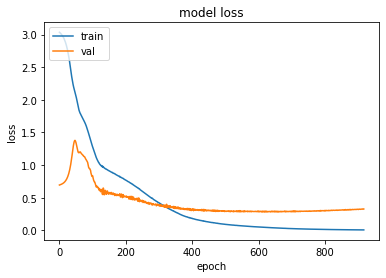

34/34 [==============================] - 1s 8ms/step
simpleConv


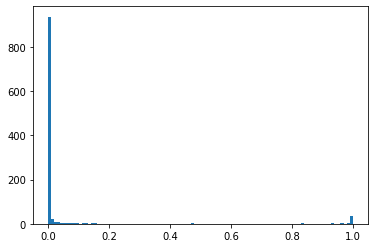

F1 score        : 0.746031746031746
AUROC           : 0.9651219512195122
EER             : 0.06829268292682927
frr_at_eer      : 0.1
far at zero frr : 0.7619512195121951
frr at 'zero' frr : 0.0


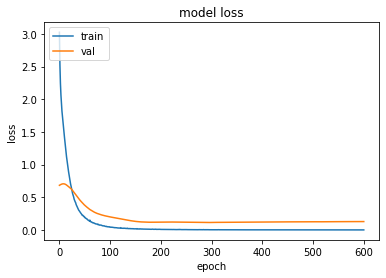

34/34 [==============================] - 0s 3ms/step
complexConv


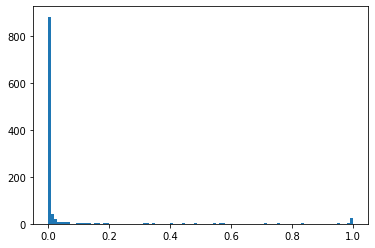

F1 score        : 0.6833333333333333
AUROC           : 0.9609105691056911
EER             : 0.0897560975609756
frr_at_eer      : 0.1
far at zero frr : 0.7736585365853659
frr at 'zero' frr : 0.0


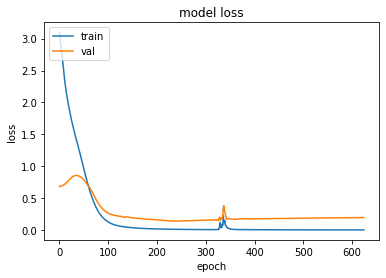

34/34 [==============================] - 1s 4ms/step
ConvLSTM


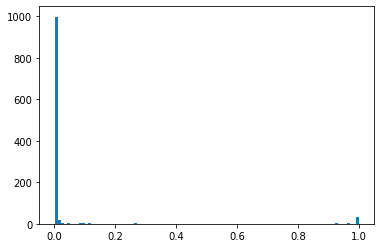

F1 score        : 0.6732673267326732
AUROC           : 0.9164878048780488
EER             : 0.10146341463414635
frr_at_eer      : 0.11666666666666667
far at zero frr : 0.984390243902439
frr at 'zero' frr : 0.0
################   2   ####################
RF


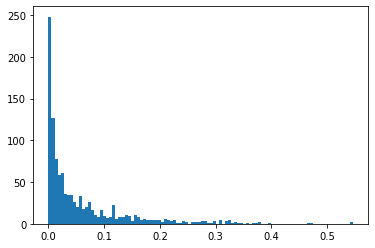

F1 score        : 0.05633802816901409
AUROC           : 0.8136910875271027
EER             : 0.26968503937007876
frr_at_eer      : 0.2753623188405797
far at zero frr : 0.9084645669291339
frr at 'zero' frr : 0.0


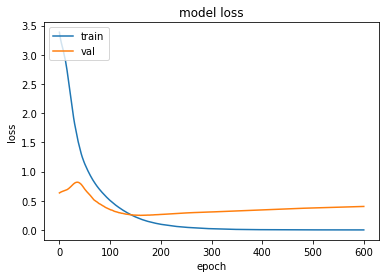

34/34 [==============================] - 0s 1ms/step
MLP


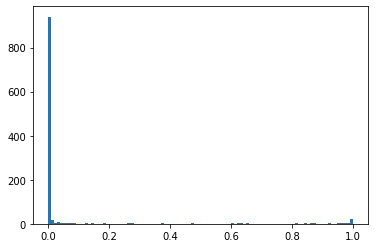

F1 score        : 0.2553191489361702
AUROC           : 0.7784862490014834
EER             : 0.2824803149606299
frr_at_eer      : 0.3188405797101449
far at zero frr : 0.6328740157480315
frr at 'zero' frr : 0.0


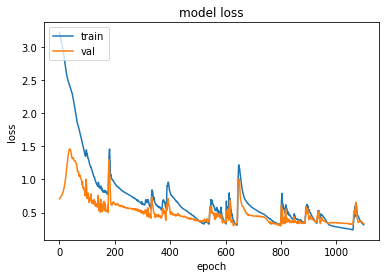

34/34 [==============================] - 1s 10ms/step
LSTM


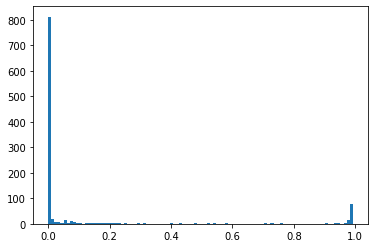

F1 score        : 0.31578947368421056
AUROC           : 0.8142474038571266
EER             : 0.21456692913385828
frr_at_eer      : 0.2318840579710145
far at zero frr : 0.8937007874015748
frr at 'zero' frr : 0.0


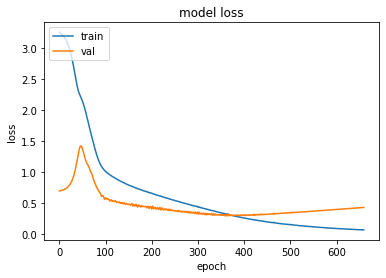

34/34 [==============================] - 1s 8ms/step
simpleConv


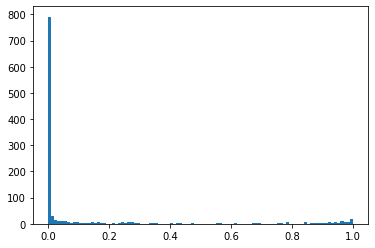

F1 score        : 0.25274725274725274
AUROC           : 0.7709260527216707
EER             : 0.26476377952755903
frr_at_eer      : 0.2753623188405797
far at zero frr : 0.8996062992125984
frr at 'zero' frr : 0.0


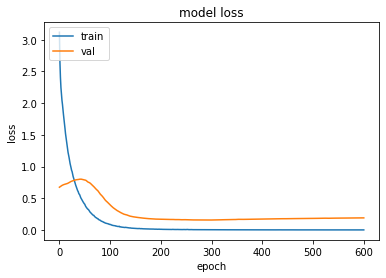

34/34 [==============================] - 0s 3ms/step
complexConv


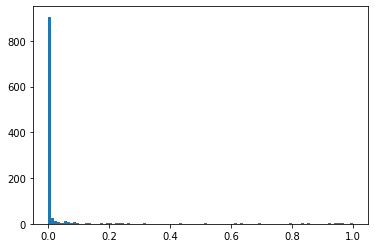

F1 score        : 0.22033898305084745
AUROC           : 0.7765605386283236
EER             : 0.25688976377952755
frr_at_eer      : 0.2608695652173913
far at zero frr : 0.9498031496062992
frr at 'zero' frr : 0.0


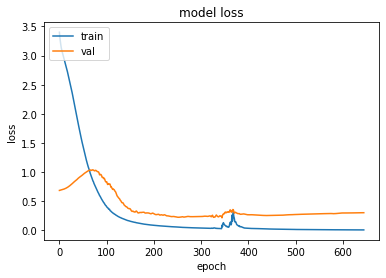

34/34 [==============================] - 1s 4ms/step
ConvLSTM


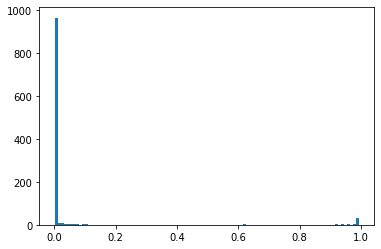

F1 score        : 0.3787878787878788
AUROC           : 0.82421830423371
EER             : 0.2529527559055118
frr_at_eer      : 0.2753623188405797
far at zero frr : 0.8631889763779528
frr at 'zero' frr : 0.0
################   3   ####################
RF


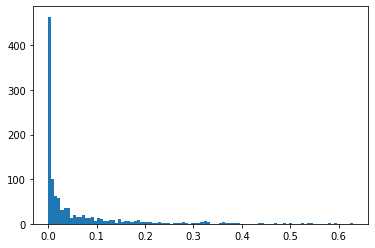

F1 score        : 0.19999999999999998
AUROC           : 0.9532995653267233
EER             : 0.0921435499515034
frr_at_eer      : 0.1111111111111111
far at zero frr : 0.6702230843840931
frr at 'zero' frr : 0.0


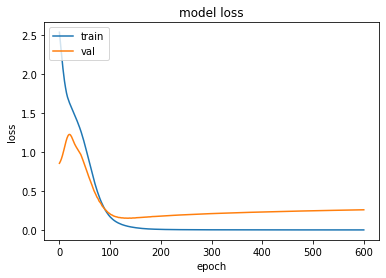

34/34 [==============================] - 0s 1ms/step
MLP


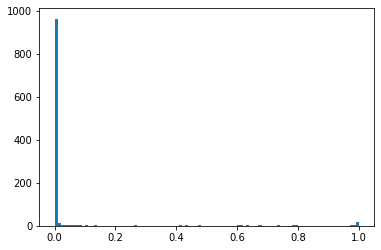

F1 score        : 0.4339622641509434
AUROC           : 0.8993695441319107
EER             : 0.1425800193986421
frr_at_eer      : 0.2037037037037037
far at zero frr : 0.6440349175557711
frr at 'zero' frr : 0.0


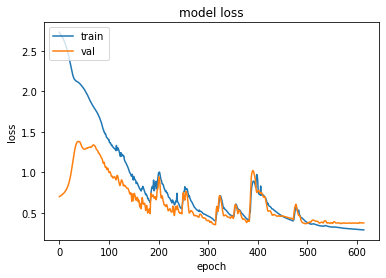

34/34 [==============================] - 1s 11ms/step
LSTM


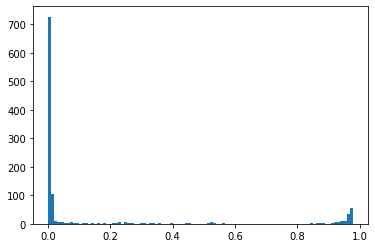

F1 score        : 0.30917874396135264
AUROC           : 0.8105399288716457
EER             : 0.20368574199806014
frr_at_eer      : 0.2222222222222222
far at zero frr : 0.8661493695441319
frr at 'zero' frr : 0.0


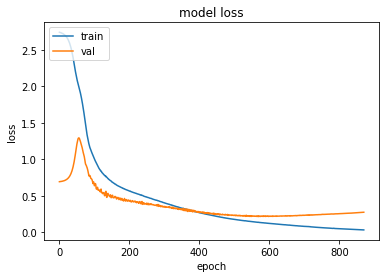

34/34 [==============================] - 1s 8ms/step
simpleConv


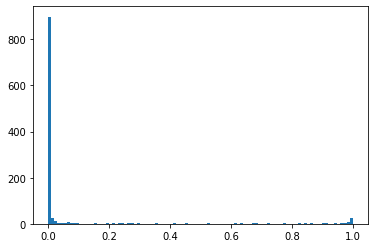

F1 score        : 0.5401459854014597
AUROC           : 0.9436541293961274
EER             : 0.09117361784675072
frr_at_eer      : 0.1111111111111111
far at zero frr : 0.7769156159068865
frr at 'zero' frr : 0.0


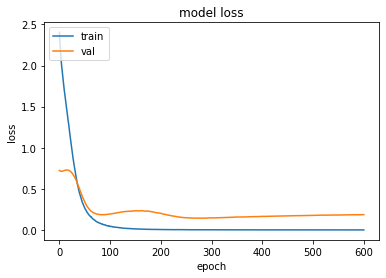

34/34 [==============================] - 1s 3ms/step
complexConv


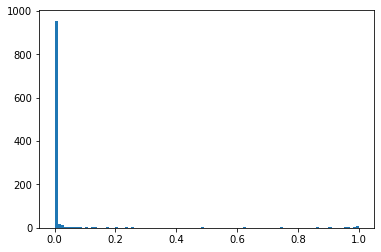

F1 score        : 0.5599999999999999
AUROC           : 0.9454143765491971
EER             : 0.09990300678952474
frr_at_eer      : 0.12962962962962962
far at zero frr : 0.5489815712900097
frr at 'zero' frr : 0.0


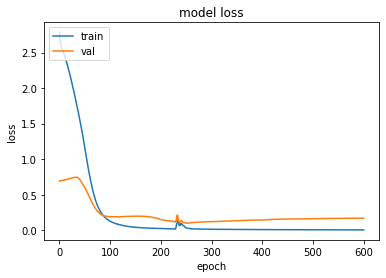

34/34 [==============================] - 2s 4ms/step
ConvLSTM


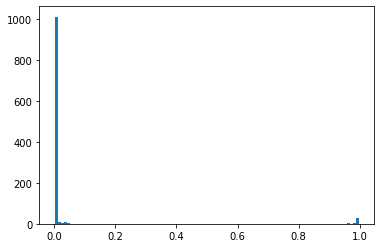

F1 score        : 0.6938775510204083
AUROC           : 0.8688795488019543
EER             : 0.14742967992240544
frr_at_eer      : 0.24074074074074073
far at zero frr : 0.8060135790494666
frr at 'zero' frr : 0.0
################   4   ####################
RF


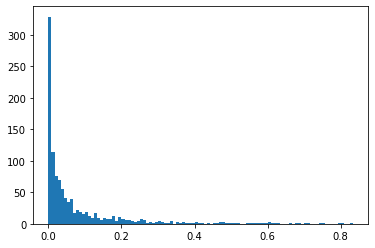

F1 score        : 0.4296296296296296
AUROC           : 0.9411707049321729
EER             : 0.13557594291539246
frr_at_eer      : 0.14423076923076922
far at zero frr : 0.5198776758409785
frr at 'zero' frr : 0.0


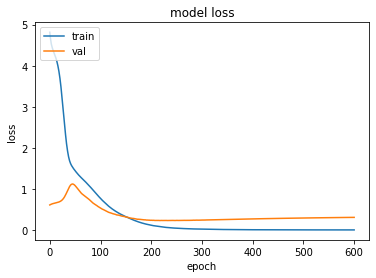

34/34 [==============================] - 0s 2ms/step
MLP


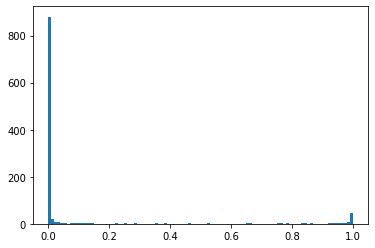

F1 score        : 0.6255924170616114
AUROC           : 0.9434544812985179
EER             : 0.13353720693170235
frr_at_eer      : 0.14423076923076922
far at zero frr : 0.4892966360856269
frr at 'zero' frr : 0.0


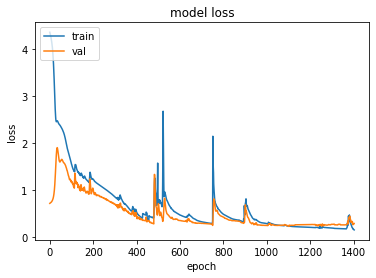

34/34 [==============================] - 2s 11ms/step
LSTM


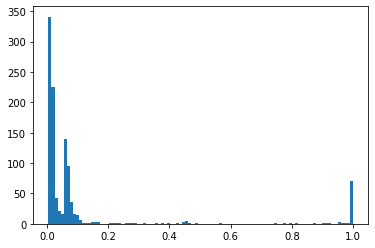

F1 score        : 0.7395833333333334
AUROC           : 0.8501921116600016
EER             : 0.22935779816513763
frr_at_eer      : 0.2403846153846154
far at zero frr : 0.9531090723751274
frr at 'zero' frr : 0.0


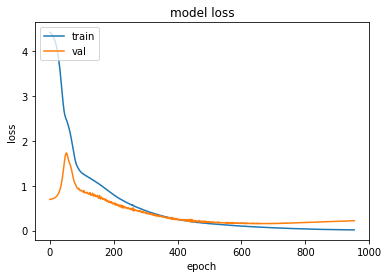

34/34 [==============================] - 1s 8ms/step
simpleConv


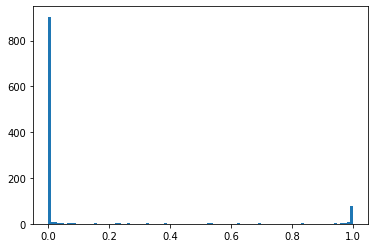

F1 score        : 0.7964601769911505
AUROC           : 0.9799262918528974
EER             : 0.0509683995922528
frr_at_eer      : 0.057692307692307696
far at zero frr : 0.3873598369011213
frr at 'zero' frr : 0.0


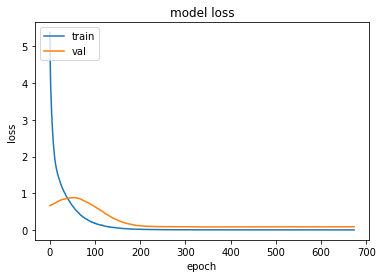

34/34 [==============================] - 0s 3ms/step
complexConv


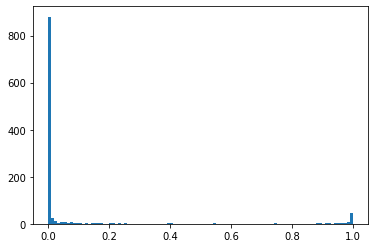

F1 score        : 0.8
AUROC           : 0.9827981651376148
EER             : 0.07543323139653414
frr_at_eer      : 0.07692307692307693
far at zero frr : 0.15902140672782875
frr at 'zero' frr : 0.0


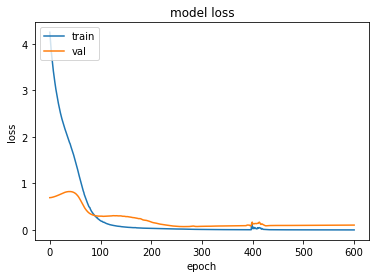

34/34 [==============================] - 1s 3ms/step
ConvLSTM


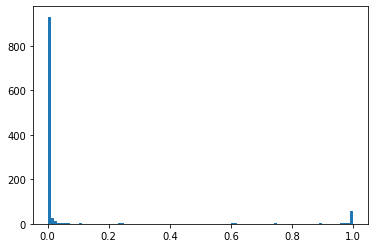

F1 score        : 0.7407407407407408
AUROC           : 0.9373088685015291
EER             : 0.12334352701325178
frr_at_eer      : 0.14423076923076922
far at zero frr : 0.799184505606524
frr at 'zero' frr : 0.0
################   5   ####################
RF


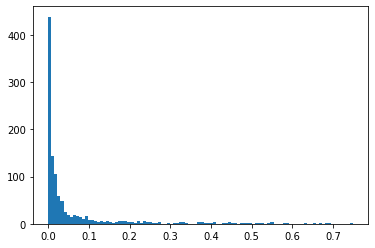

F1 score        : 0.40909090909090906
AUROC           : 0.9911822660098522
EER             : 0.03940886699507389
frr_at_eer      : 0.04285714285714286
far at zero frr : 0.060098522167487685
frr at 'zero' frr : 0.0


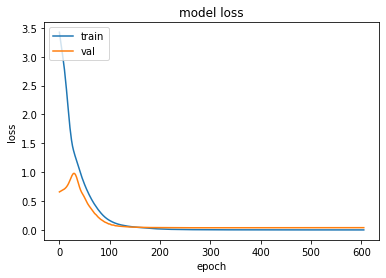

34/34 [==============================] - 0s 1ms/step
MLP


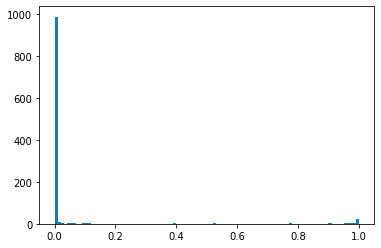

F1 score        : 0.6885245901639345
AUROC           : 0.9604222378606615
EER             : 0.06502463054187192
frr_at_eer      : 0.12857142857142856
far at zero frr : 0.33201970443349754
frr at 'zero' frr : 0.0


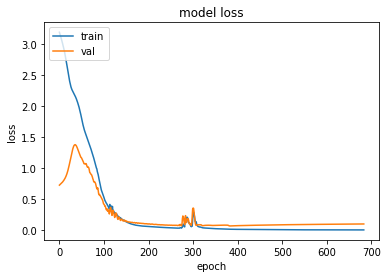

34/34 [==============================] - 1s 11ms/step
LSTM


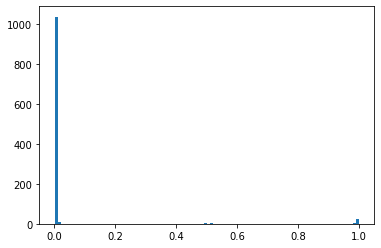

F1 score        : 0.5436893203883495
AUROC           : 0.7433075299085151
EER             : 0.30049261083743845
frr_at_eer      : 0.32857142857142857
far at zero frr : 0.8729064039408867
frr at 'zero' frr : 0.0


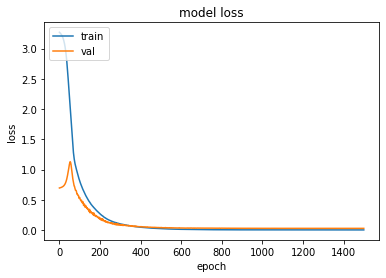

34/34 [==============================] - 1s 9ms/step
simpleConv


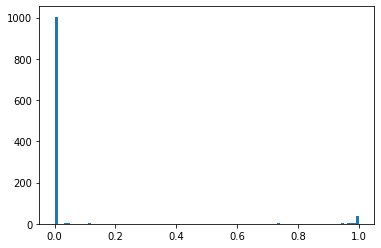

F1 score        : 0.8270676691729324
AUROC           : 0.9916959887403237
EER             : 0.03645320197044335
frr_at_eer      : 0.04285714285714286
far at zero frr : 0.1625615763546798
frr at 'zero' frr : 0.0


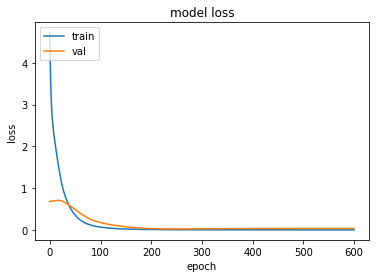

34/34 [==============================] - 0s 3ms/step
complexConv


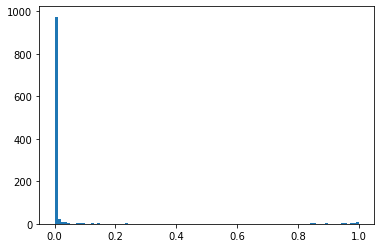

F1 score        : 0.7321428571428572
AUROC           : 0.9803377902885293
EER             : 0.06502463054187192
frr_at_eer      : 0.08571428571428572
far at zero frr : 0.26699507389162563
frr at 'zero' frr : 0.0


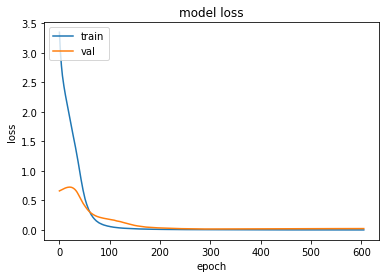

34/34 [==============================] - 1s 3ms/step
ConvLSTM


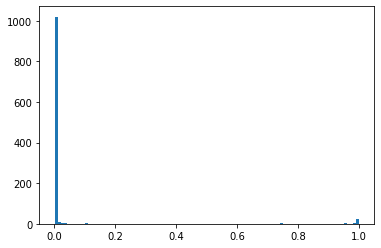

F1 score        : 0.6226415094339622
AUROC           : 0.858676988036594
EER             : 0.21182266009852216
frr_at_eer      : 0.22857142857142856
far at zero frr : 0.9300492610837439
frr at 'zero' frr : 0.0
################   6   ####################
RF


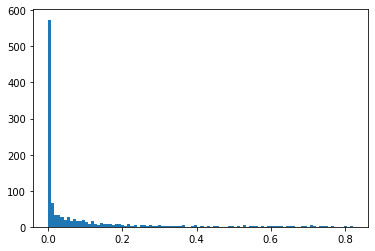

F1 score        : 0.7450980392156863
AUROC           : 0.9780464697294442
EER             : 0.04598825831702544
frr_at_eer      : 0.06349206349206349
far at zero frr : 0.7299412915851272
frr at 'zero' frr : 0.0


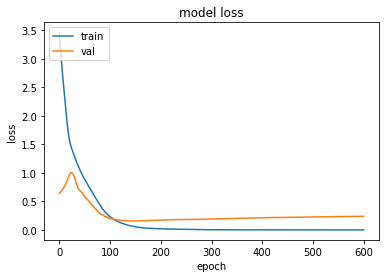

34/34 [==============================] - 0s 2ms/step
MLP


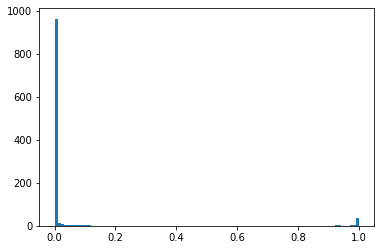

F1 score        : 0.7819548872180451
AUROC           : 0.9838163575932656
EER             : 0.046966731898238745
frr_at_eer      : 0.06349206349206349
far at zero frr : 0.17906066536203522
frr at 'zero' frr : 0.0


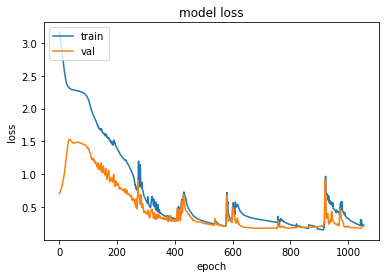

34/34 [==============================] - 1s 11ms/step
LSTM


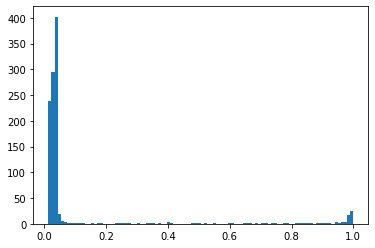

F1 score        : 0.4605263157894737
AUROC           : 0.773366880998975
EER             : 0.24266144814090018
frr_at_eer      : 0.2857142857142857
far at zero frr : 0.9814090019569471
frr at 'zero' frr : 0.0


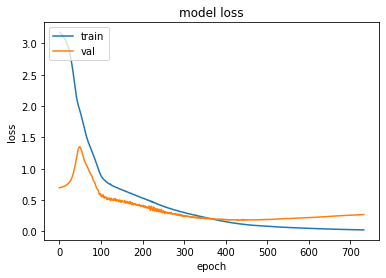

34/34 [==============================] - 1s 8ms/step
simpleConv


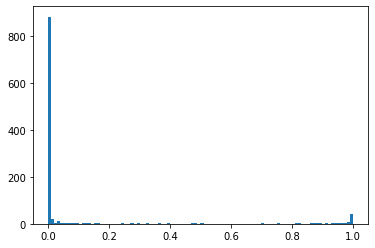

F1 score        : 0.6875
AUROC           : 0.9765011027241947
EER             : 0.07240704500978473
frr_at_eer      : 0.09523809523809523
far at zero frr : 0.2710371819960861
frr at 'zero' frr : 0.0


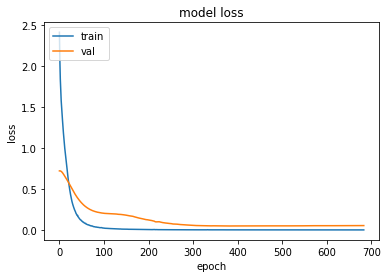

34/34 [==============================] - 0s 3ms/step
complexConv


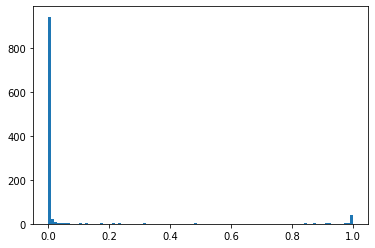

F1 score        : 0.8396946564885497
AUROC           : 0.9920479607368061
EER             : 0.026418786692759294
frr_at_eer      : 0.031746031746031744
far at zero frr : 0.175146771037182
frr at 'zero' frr : 0.0


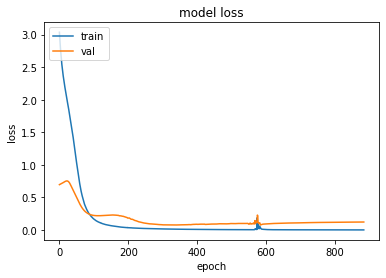

34/34 [==============================] - 1s 3ms/step
ConvLSTM


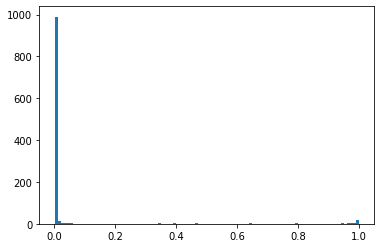

F1 score        : 0.7758620689655172
AUROC           : 0.9728823036063741
EER             : 0.04892367906066536
frr_at_eer      : 0.07936507936507936
far at zero frr : 0.6790606653620352
frr at 'zero' frr : 0.0
################   7   ####################
RF


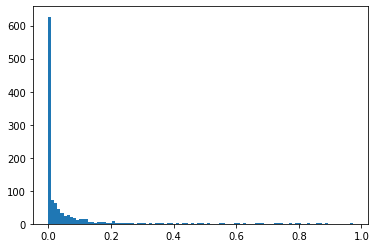

F1 score        : 0.5263157894736842
AUROC           : 0.9634975369458127
EER             : 0.10541871921182266
frr_at_eer      : 0.12857142857142856
far at zero frr : 0.2187192118226601
frr at 'zero' frr : 0.0


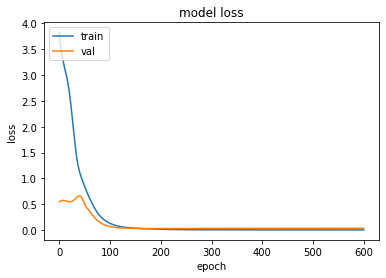

34/34 [==============================] - 0s 1ms/step
MLP


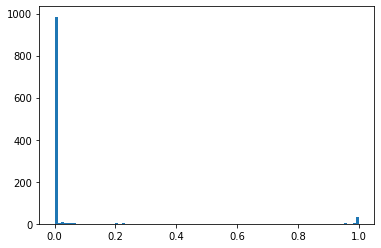

F1 score        : 0.6719999999999999
AUROC           : 0.956805066854328
EER             : 0.10246305418719212
frr_at_eer      : 0.11428571428571428
far at zero frr : 0.6689655172413793
frr at 'zero' frr : 0.0


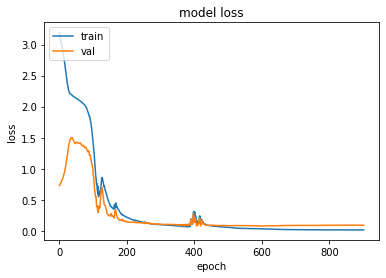

34/34 [==============================] - 1s 11ms/step
LSTM


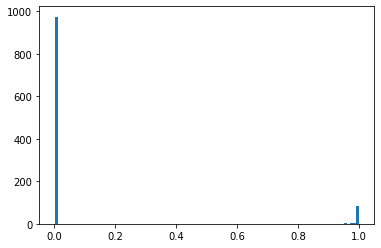

F1 score        : 0.6627218934911243
AUROC           : 0.94036593947924
EER             : 0.06896551724137931
frr_at_eer      : 0.07142857142857142
far at zero frr : 0.6886699507389162
frr at 'zero' frr : 0.0


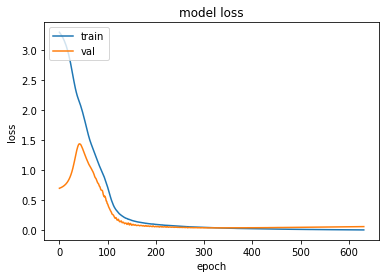

34/34 [==============================] - 1s 8ms/step
simpleConv


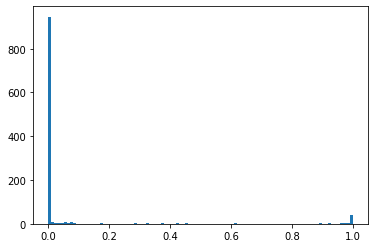

F1 score        : 0.8251748251748252
AUROC           : 0.9831808585503167
EER             : 0.04532019704433497
frr_at_eer      : 0.05714285714285714
far at zero frr : 0.5605911330049261
frr at 'zero' frr : 0.0


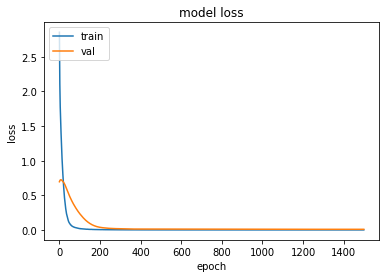

34/34 [==============================] - 0s 3ms/step
complexConv


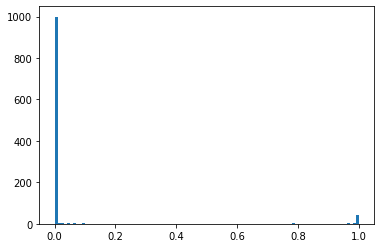

F1 score        : 0.859375
AUROC           : 0.9881210415200562
EER             : 0.027586206896551724
frr_at_eer      : 0.02857142857142857
far at zero frr : 0.5359605911330049
frr at 'zero' frr : 0.0


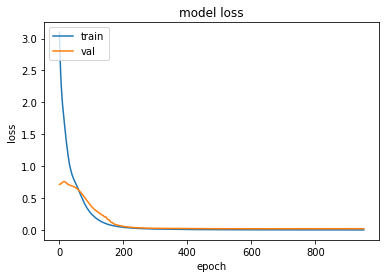

34/34 [==============================] - 1s 4ms/step
ConvLSTM


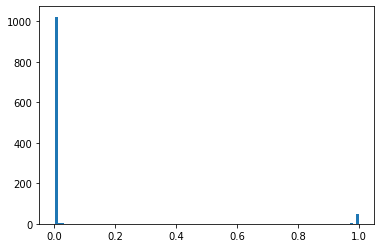

F1 score        : 0.870967741935484
AUROC           : 0.983194933145672
EER             : 0.03842364532019704
frr_at_eer      : 0.07142857142857142
far at zero frr : 0.6068965517241379
frr at 'zero' frr : 0.0
################   8   ####################
RF


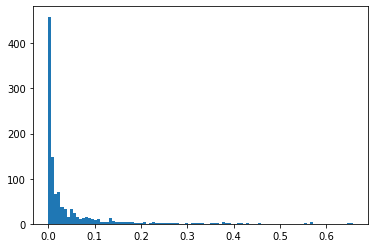

F1 score        : 0.09302325581395349
AUROC           : 0.9421936249226325
EER             : 0.0868320610687023
frr_at_eer      : 0.16216216216216217
far at zero frr : 0.3196564885496183
frr at 'zero' frr : 0.0


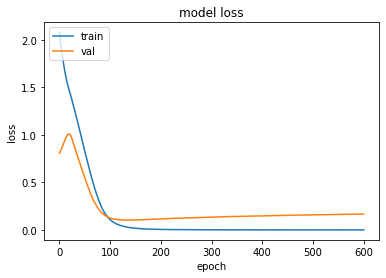

34/34 [==============================] - 0s 1ms/step
MLP


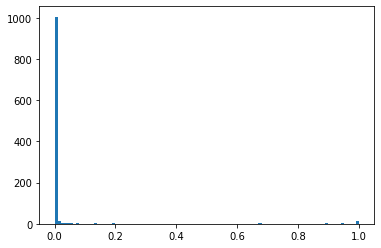

F1 score        : 0.4411764705882353
AUROC           : 0.9146379203631112
EER             : 0.1183206106870229
frr_at_eer      : 0.16216216216216217
far at zero frr : 0.6326335877862596
frr at 'zero' frr : 0.0


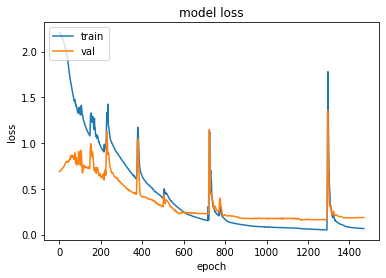

34/34 [==============================] - 1s 11ms/step
LSTM


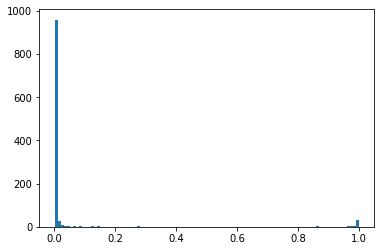

F1 score        : 0.5591397849462365
AUROC           : 0.9014080874767897
EER             : 0.1431297709923664
frr_at_eer      : 0.1891891891891892
far at zero frr : 0.9494274809160306
frr at 'zero' frr : 0.0


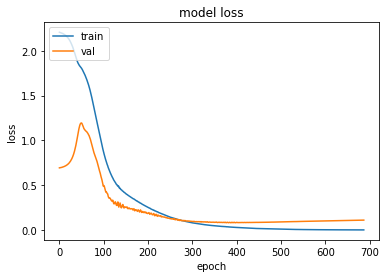

34/34 [==============================] - 1s 8ms/step
simpleConv


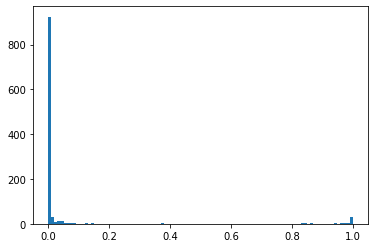

F1 score        : 0.608695652173913
AUROC           : 0.9363008046214154
EER             : 0.05343511450381679
frr_at_eer      : 0.1891891891891892
far at zero frr : 0.4265267175572519
frr at 'zero' frr : 0.0


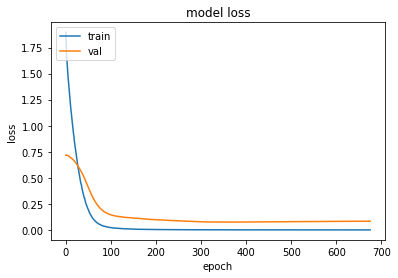

34/34 [==============================] - 0s 3ms/step
complexConv


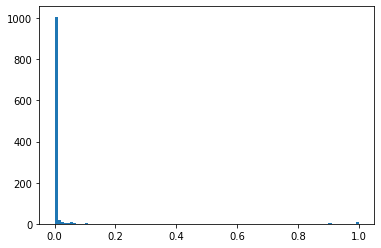

F1 score        : 0.5818181818181818
AUROC           : 0.9738755931504024
EER             : 0.042938931297709926
frr_at_eer      : 0.08108108108108109
far at zero frr : 0.4217557251908397
frr at 'zero' frr : 0.0


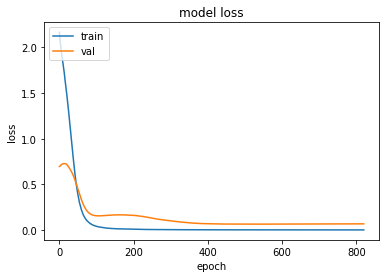

34/34 [==============================] - 2s 4ms/step
ConvLSTM


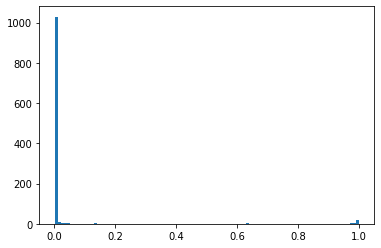

F1 score        : 0.696969696969697
AUROC           : 0.9845265112440684
EER             : 0.05152671755725191
frr_at_eer      : 0.05405405405405406
far at zero frr : 0.15935114503816794
frr at 'zero' frr : 0.0
################   9   ####################
RF


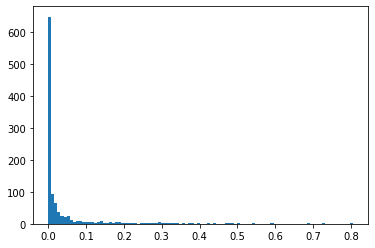

F1 score        : 0.2439024390243902
AUROC           : 0.9680816326530612
EER             : 0.07333333333333333
frr_at_eer      : 0.08571428571428572
far at zero frr : 0.18571428571428572
frr at 'zero' frr : 0.0


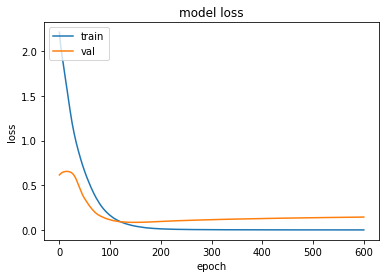

34/34 [==============================] - 0s 1ms/step
MLP


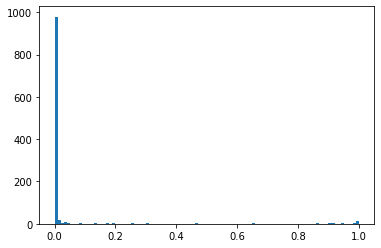

F1 score        : 0.47887323943661975
AUROC           : 0.91156462585034
EER             : 0.15523809523809523
frr_at_eer      : 0.2
far at zero frr : 0.4780952380952381
frr at 'zero' frr : 0.0


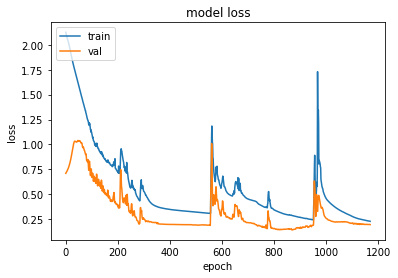

34/34 [==============================] - 2s 11ms/step
LSTM


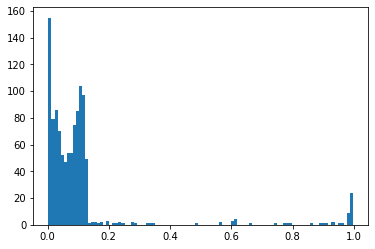

F1 score        : 0.488888888888889
AUROC           : 0.8599183673469388
EER             : 0.12285714285714286
frr_at_eer      : 0.22857142857142856
far at zero frr : 0.9276190476190476
frr at 'zero' frr : 0.0


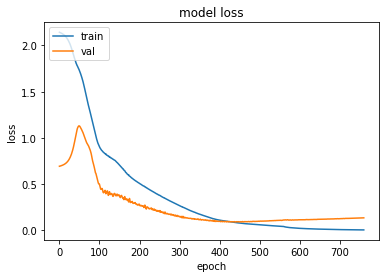

34/34 [==============================] - 1s 8ms/step
simpleConv


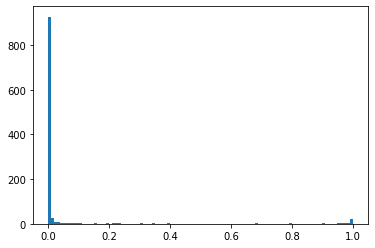

F1 score        : 0.41758241758241754
AUROC           : 0.9299319727891155
EER             : 0.11238095238095239
frr_at_eer      : 0.14285714285714285
far at zero frr : 0.6657142857142857
frr at 'zero' frr : 0.0


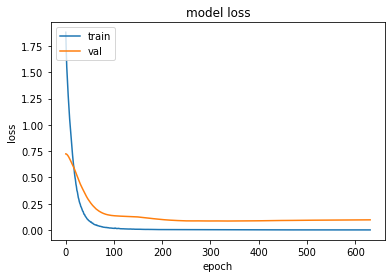

34/34 [==============================] - 0s 3ms/step
complexConv


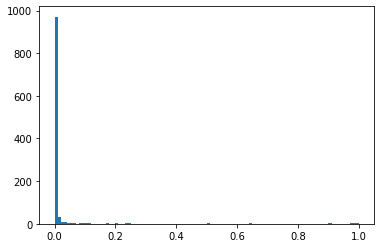

F1 score        : 0.4
AUROC           : 0.9417687074829932
EER             : 0.10666666666666667
frr_at_eer      : 0.11428571428571428
far at zero frr : 0.6485714285714286
frr at 'zero' frr : 0.0


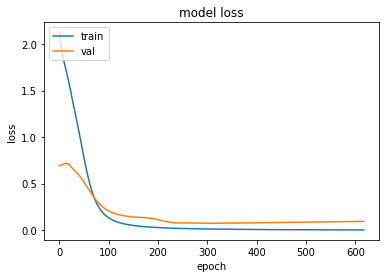

34/34 [==============================] - 1s 3ms/step
ConvLSTM


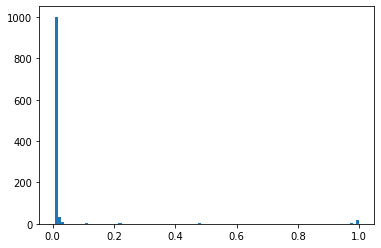

F1 score        : 0.5901639344262295
AUROC           : 0.9410612244897959
EER             : 0.10952380952380952
frr_at_eer      : 0.11428571428571428
far at zero frr : 0.539047619047619
frr at 'zero' frr : 0.0
################   10   ####################
RF


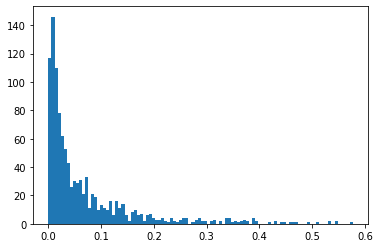

F1 score        : 0.1621621621621622
AUROC           : 0.9206648736190644
EER             : 0.13667649950835792
frr_at_eer      : 0.17647058823529413
far at zero frr : 0.5801376597836775
frr at 'zero' frr : 0.0


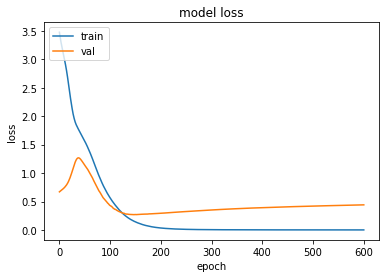

34/34 [==============================] - 0s 1ms/step
MLP


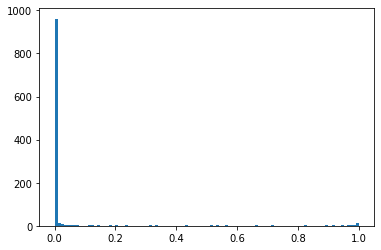

F1 score        : 0.48
AUROC           : 0.8984036092313032
EER             : 0.1504424778761062
frr_at_eer      : 0.17647058823529413
far at zero frr : 0.7177974434611603
frr at 'zero' frr : 0.0


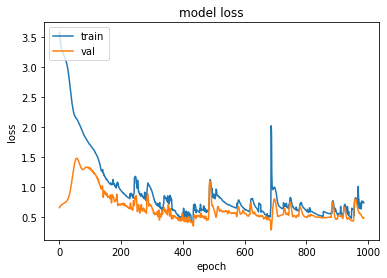

34/34 [==============================] - 1s 10ms/step
LSTM


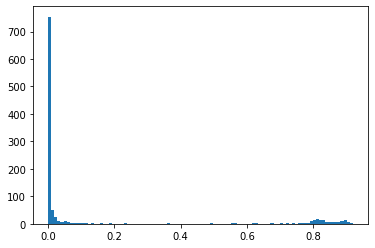

F1 score        : 0.3666666666666667
AUROC           : 0.8689340042801782
EER             : 0.176007866273353
frr_at_eer      : 0.17647058823529413
far at zero frr : 0.6578171091445427
frr at 'zero' frr : 0.0


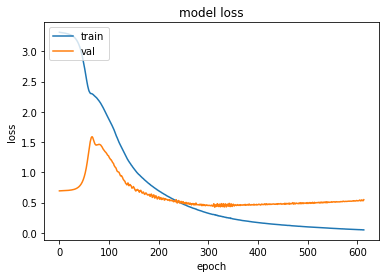

34/34 [==============================] - 1s 8ms/step
simpleConv


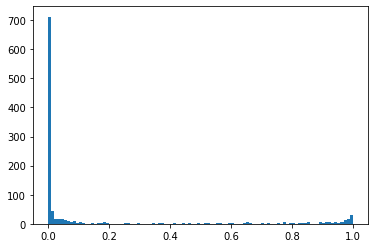

F1 score        : 0.4406779661016949
AUROC           : 0.9245618601422871
EER             : 0.14454277286135694
frr_at_eer      : 0.14705882352941177
far at zero frr : 0.4729596853490659
frr at 'zero' frr : 0.0


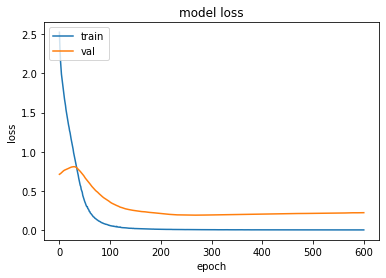

34/34 [==============================] - 0s 3ms/step
complexConv


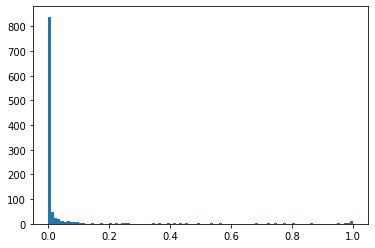

F1 score        : 0.532258064516129
AUROC           : 0.9128347504193418
EER             : 0.13667649950835792
frr_at_eer      : 0.16176470588235295
far at zero frr : 0.8888888888888888
frr at 'zero' frr : 0.0


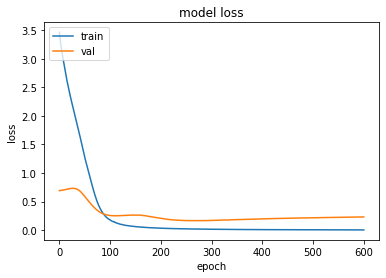

34/34 [==============================] - 1s 4ms/step
ConvLSTM


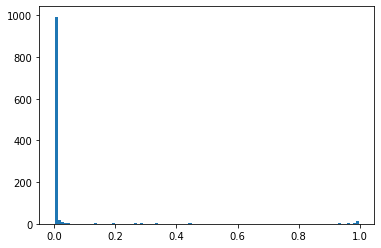

F1 score        : 0.4313725490196078
AUROC           : 0.8323500491642084
EER             : 0.10914454277286136
frr_at_eer      : 0.22058823529411764
far at zero frr : 0.8131760078662733
frr at 'zero' frr : 0.0
################   11   ####################
RF


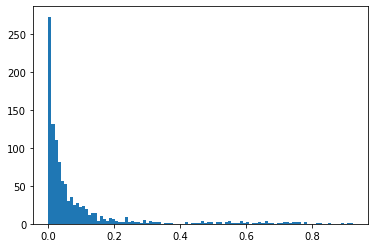

F1 score        : 0.7536231884057971
AUROC           : 0.9888823529411764
EER             : 0.028
frr_at_eer      : 0.047058823529411764
far at zero frr : 0.264
frr at 'zero' frr : 0.0


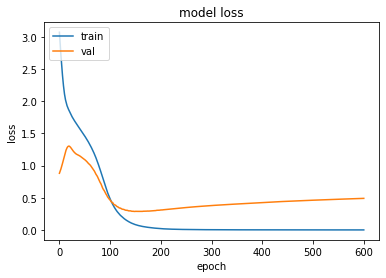

34/34 [==============================] - 0s 1ms/step
MLP


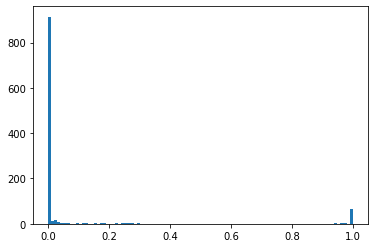

F1 score        : 0.6547619047619048
AUROC           : 0.8979176470588235
EER             : 0.124
frr_at_eer      : 0.17647058823529413
far at zero frr : 0.993
frr at 'zero' frr : 0.0


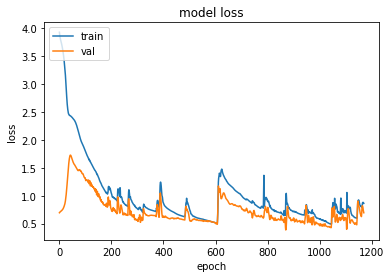

34/34 [==============================] - 1s 11ms/step
LSTM


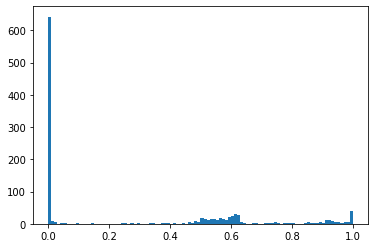

F1 score        : 0.30406852248394006
AUROC           : 0.8920705882352941
EER             : 0.147
frr_at_eer      : 0.21176470588235294
far at zero frr : 0.721
frr at 'zero' frr : 0.0


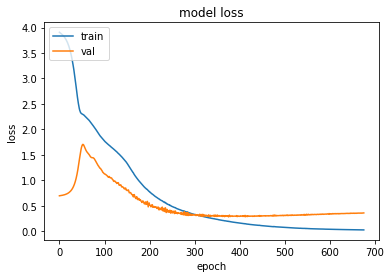

34/34 [==============================] - 1s 8ms/step
simpleConv


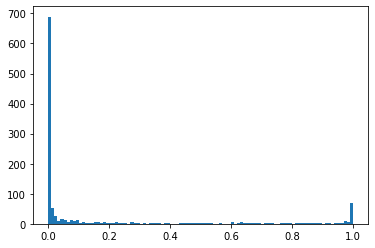

F1 score        : 0.6583333333333333
AUROC           : 0.97
EER             : 0.074
frr_at_eer      : 0.08235294117647059
far at zero frr : 0.396
frr at 'zero' frr : 0.0


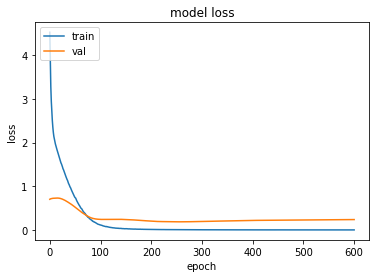

34/34 [==============================] - 0s 3ms/step
complexConv


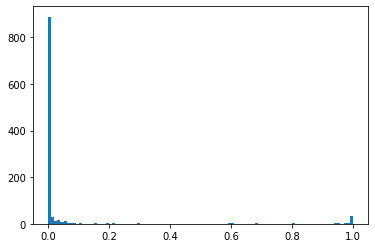

F1 score        : 0.8101265822784809
AUROC           : 0.9711058823529413
EER             : 0.079
frr_at_eer      : 0.09411764705882353
far at zero frr : 0.517
frr at 'zero' frr : 0.0


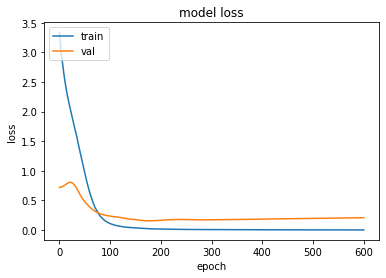

34/34 [==============================] - 1s 4ms/step
ConvLSTM


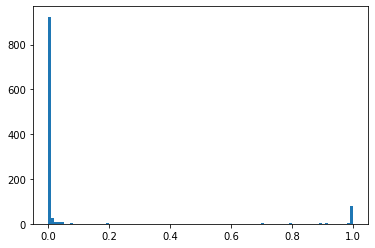

F1 score        : 0.8279569892473118
AUROC           : 0.9886470588235294
EER             : 0.056
frr_at_eer      : 0.07058823529411765
far at zero frr : 0.136
frr at 'zero' frr : 0.0
################   12   ####################
RF


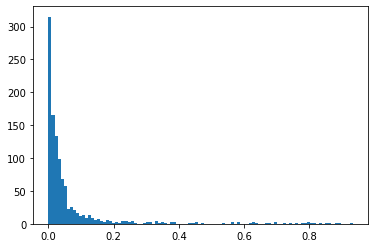

F1 score        : 0.5544554455445544
AUROC           : 0.9819291786236396
EER             : 0.05434782608695652
frr_at_eer      : 0.0821917808219178
far at zero frr : 0.16996047430830039
frr at 'zero' frr : 0.0


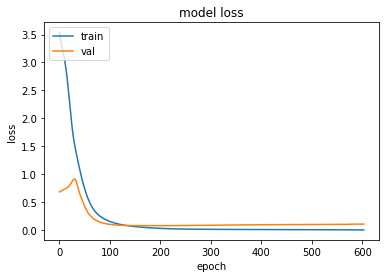

34/34 [==============================] - 0s 1ms/step
MLP


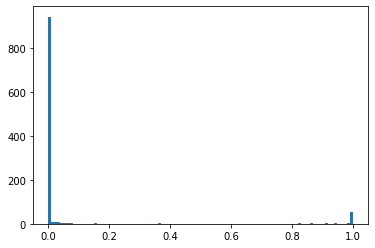

F1 score        : 0.7875
AUROC           : 0.9884942335805944
EER             : 0.04841897233201581
frr_at_eer      : 0.0547945205479452
far at zero frr : 0.14624505928853754
frr at 'zero' frr : 0.0


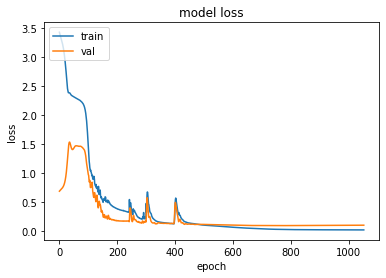

34/34 [==============================] - 2s 11ms/step
LSTM


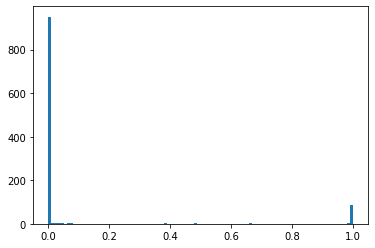

F1 score        : 0.7840909090909092
AUROC           : 0.9870458606313282
EER             : 0.03260869565217391
frr_at_eer      : 0.0547945205479452
far at zero frr : 0.22826086956521738
frr at 'zero' frr : 0.0


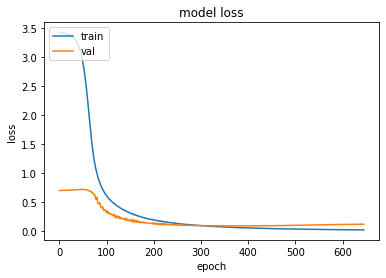

34/34 [==============================] - 1s 8ms/step
simpleConv


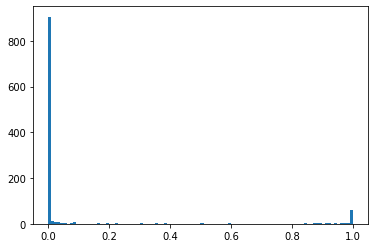

F1 score        : 0.7932960893854747
AUROC           : 0.9941794358113596
EER             : 0.03458498023715415
frr_at_eer      : 0.0410958904109589
far at zero frr : 0.03458498023715415
frr at 'zero' frr : 0.0


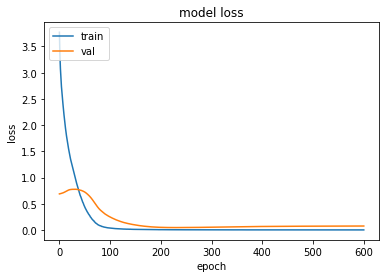

34/34 [==============================] - 0s 3ms/step
complexConv


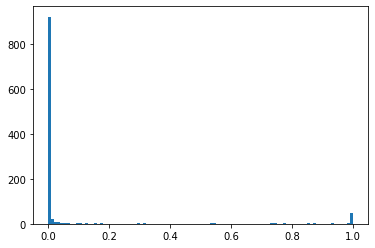

F1 score        : 0.8289473684210525
AUROC           : 0.9869917158481779
EER             : 0.046442687747035576
frr_at_eer      : 0.0547945205479452
far at zero frr : 0.283596837944664
frr at 'zero' frr : 0.0


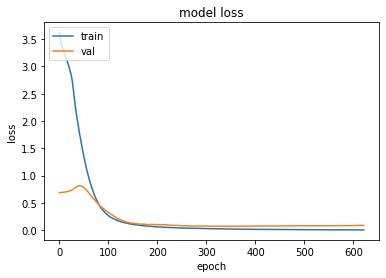

34/34 [==============================] - 1s 5ms/step
ConvLSTM


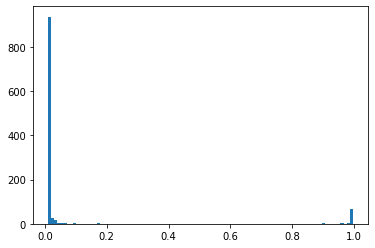

F1 score        : 0.8481012658227848
AUROC           : 0.9759597162813363
EER             : 0.030632411067193676
frr_at_eer      : 0.0547945205479452
far at zero frr : 0.7213438735177866
frr at 'zero' frr : 0.0
################   13   ####################
RF


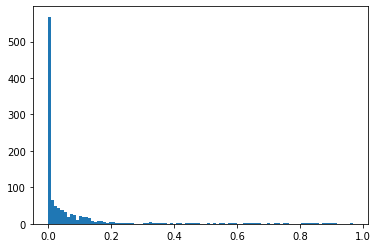

F1 score        : 0.7603305785123966
AUROC           : 0.9964950495049505
EER             : 0.02574257425742574
frr_at_eer      : 0.02666666666666667
far at zero frr : 0.10495049504950495
frr at 'zero' frr : 0.0


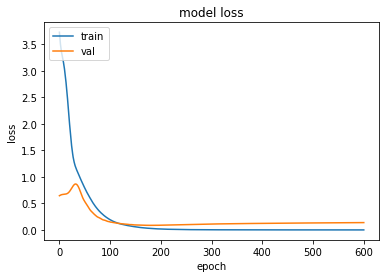

34/34 [==============================] - 0s 1ms/step
MLP


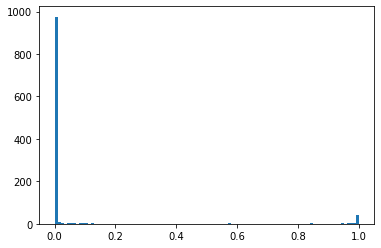

F1 score        : 0.8551724137931035
AUROC           : 0.989029702970297
EER             : 0.03663366336633663
frr_at_eer      : 0.05333333333333334
far at zero frr : 0.3455445544554455
frr at 'zero' frr : 0.0


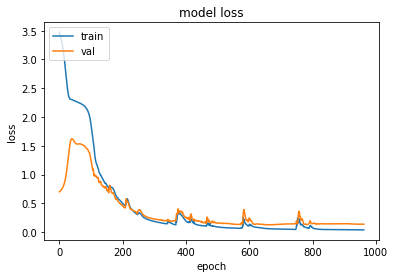

34/34 [==============================] - 1s 11ms/step
LSTM


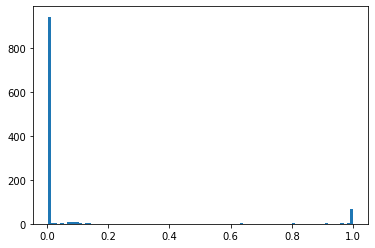

F1 score        : 0.7692307692307693
AUROC           : 0.9673531353135314
EER             : 0.040594059405940595
frr_at_eer      : 0.06666666666666667
far at zero frr : 0.9841584158415841
frr at 'zero' frr : 0.0


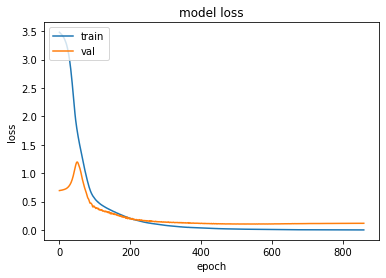

34/34 [==============================] - 1s 8ms/step
simpleConv


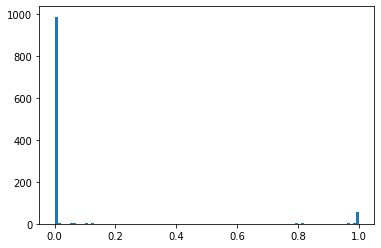

F1 score        : 0.918918918918919
AUROC           : 0.9932277227722772
EER             : 0.027722772277227723
frr_at_eer      : 0.04
far at zero frr : 0.3683168316831683
frr at 'zero' frr : 0.0


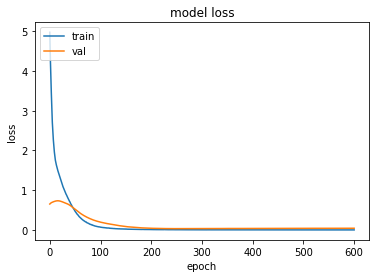

34/34 [==============================] - 0s 3ms/step
complexConv


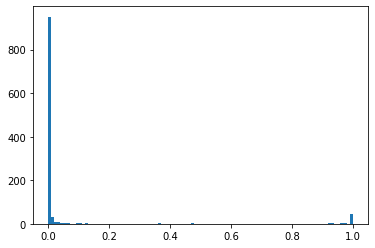

F1 score        : 0.9219858156028369
AUROC           : 0.9988646864686468
EER             : 0.0049504950495049506
frr_at_eer      : 0.02666666666666667
far at zero frr : 0.03564356435643564
frr at 'zero' frr : 0.0


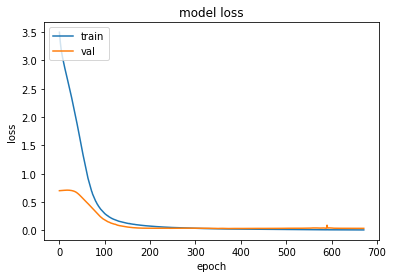

34/34 [==============================] - 1s 4ms/step
ConvLSTM


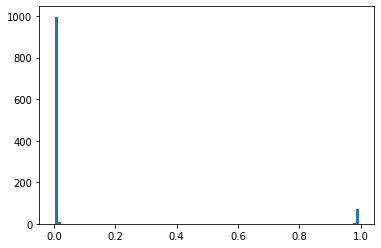

F1 score        : 0.9864864864864865
AUROC           : 0.9983762376237624
EER             : 0.01089108910891089
frr_at_eer      : 0.013333333333333334
far at zero frr : 0.11089108910891089
frr at 'zero' frr : 0.0
################   14   ####################
RF


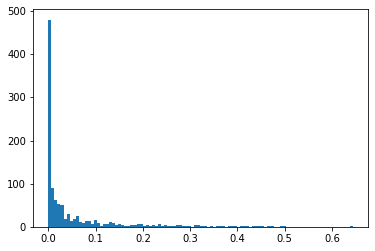

F1 score        : 0.02469135802469136
AUROC           : 0.9768532338308458
EER             : 0.06865671641791045
frr_at_eer      : 0.075
far at zero frr : 0.13034825870646766
frr at 'zero' frr : 0.0


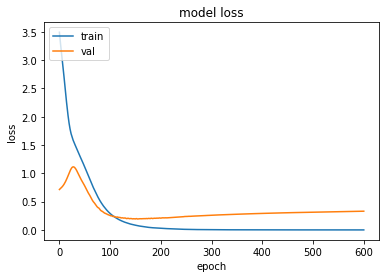

34/34 [==============================] - 0s 1ms/step
MLP


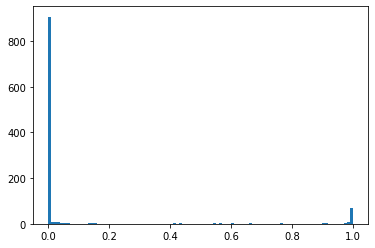

F1 score        : 0.6974358974358974
AUROC           : 0.9768283582089552
EER             : 0.06467661691542288
frr_at_eer      : 0.0875
far at zero frr : 0.4
frr at 'zero' frr : 0.0


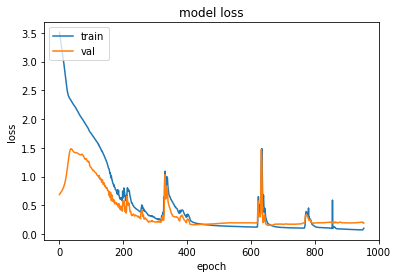

34/34 [==============================] - 1s 10ms/step
LSTM


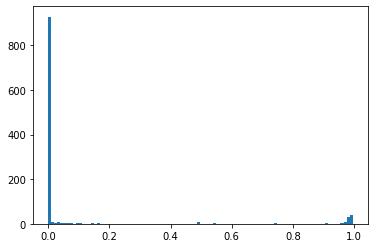

F1 score        : 0.6739130434782609
AUROC           : 0.9069278606965173
EER             : 0.10149253731343283
frr_at_eer      : 0.1625
far at zero frr : 0.9791044776119403
frr at 'zero' frr : 0.0


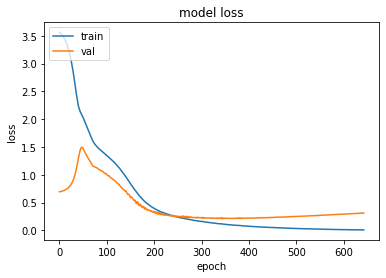

34/34 [==============================] - 1s 7ms/step
simpleConv


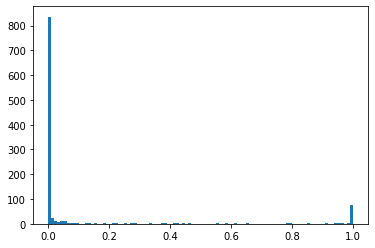

F1 score        : 0.7254901960784315
AUROC           : 0.9833084577114428
EER             : 0.05373134328358209
frr_at_eer      : 0.0625
far at zero frr : 0.19203980099502488
frr at 'zero' frr : 0.0


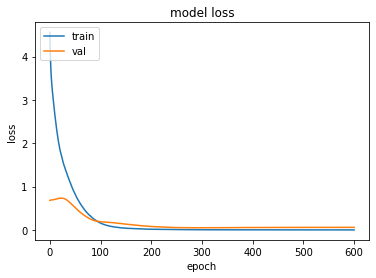

34/34 [==============================] - 0s 3ms/step
complexConv


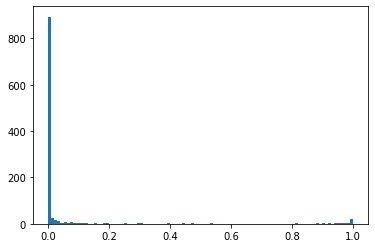

F1 score        : 0.7662337662337663
AUROC           : 0.985771144278607
EER             : 0.042786069651741296
frr_at_eer      : 0.05
far at zero frr : 0.19402985074626866
frr at 'zero' frr : 0.0


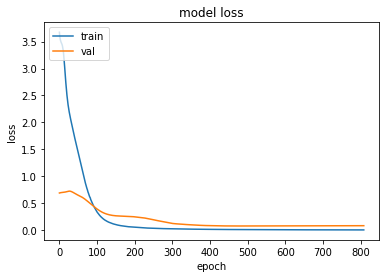

34/34 [==============================] - 1s 4ms/step
ConvLSTM


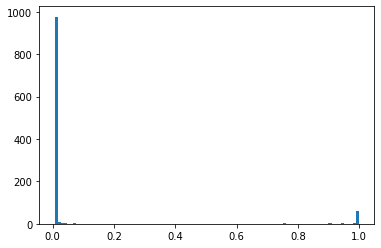

F1 score        : 0.8679245283018868
AUROC           : 0.978047263681592
EER             : 0.045771144278606964
frr_at_eer      : 0.05
far at zero frr : 0.7024875621890547
frr at 'zero' frr : 0.0
################   15   ####################
RF


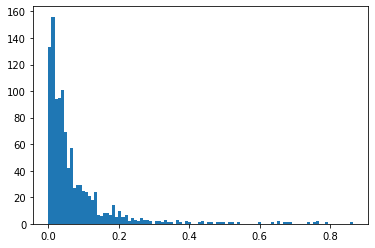

F1 score        : 0.3404255319148936
AUROC           : 0.9487879713798284
EER             : 0.12313803376365443
frr_at_eer      : 0.14102564102564102
far at zero frr : 0.33763654419066536
frr at 'zero' frr : 0.0


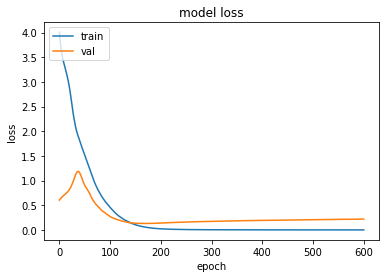

34/34 [==============================] - 0s 1ms/step
MLP


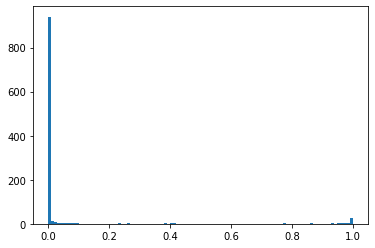

F1 score        : 0.524822695035461
AUROC           : 0.9194357446591807
EER             : 0.14299900695134063
frr_at_eer      : 0.16666666666666666
far at zero frr : 0.5273088381330685
frr at 'zero' frr : 0.0


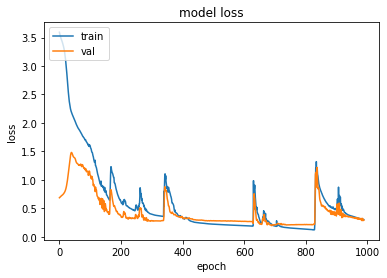

34/34 [==============================] - 1s 11ms/step
LSTM


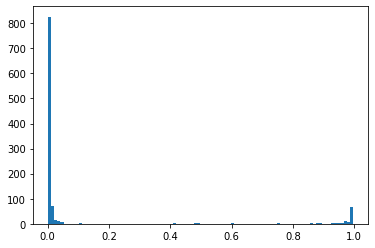

F1 score        : 0.6464646464646464
AUROC           : 0.926030606268938
EER             : 0.0804369414101291
frr_at_eer      : 0.10256410256410256
far at zero frr : 0.9920556107249255
frr at 'zero' frr : 0.0


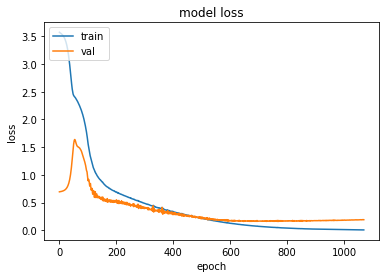

34/34 [==============================] - 1s 8ms/step
simpleConv


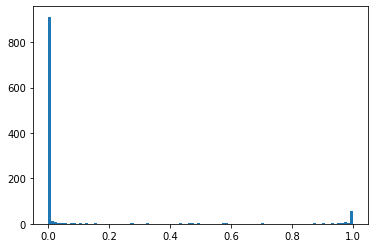

F1 score        : 0.6292134831460674
AUROC           : 0.9649759376670994
EER             : 0.07944389275074479
frr_at_eer      : 0.08974358974358974
far at zero frr : 0.4200595829195631
frr at 'zero' frr : 0.0


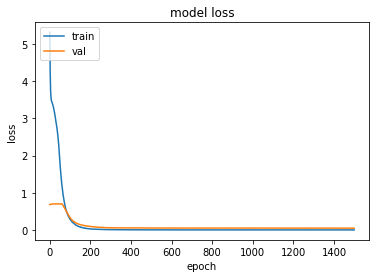

34/34 [==============================] - 0s 3ms/step
complexConv


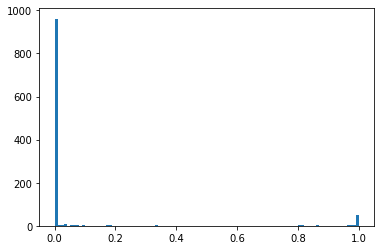

F1 score        : 0.8481012658227848
AUROC           : 0.9927685687367912
EER             : 0.03277060575968222
frr_at_eer      : 0.05128205128205128
far at zero frr : 0.10625620655412116
frr at 'zero' frr : 0.0


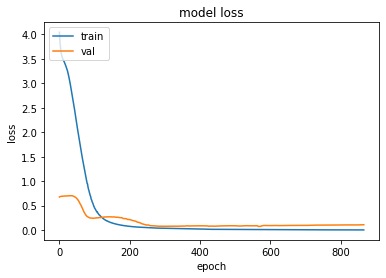

34/34 [==============================] - 1s 3ms/step
ConvLSTM


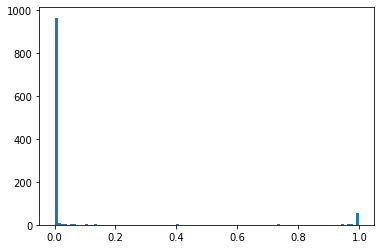

F1 score        : 0.7898089171974522
AUROC           : 0.9703740483283682
EER             : 0.070506454816286
frr_at_eer      : 0.08974358974358974
far at zero frr : 0.47070506454816285
frr at 'zero' frr : 0.0
################   0   ####################
RF


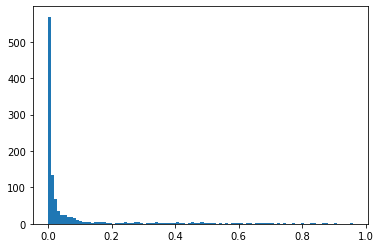

F1 score        : 0.5825242718446603
AUROC           : 0.9636538932419196
EER             : 0.0842311459353575
frr_at_eer      : 0.09375
far at zero frr : 0.5171400587659157
frr at 'zero' frr : 0.0


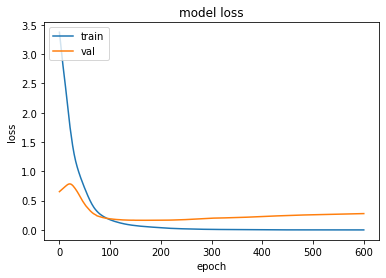

34/34 [==============================] - 0s 1ms/step
MLP


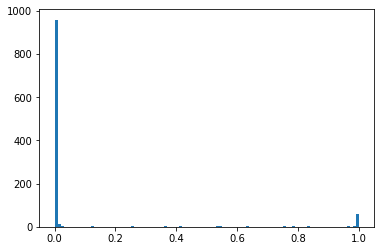

F1 score        : 0.7417218543046357
AUROC           : 0.9852779138099903
EER             : 0.05288932419196866
frr_at_eer      : 0.0625
far at zero frr : 0.2791380999020568
frr at 'zero' frr : 0.0


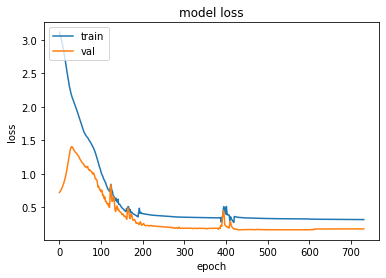

34/34 [==============================] - 1s 10ms/step
LSTM


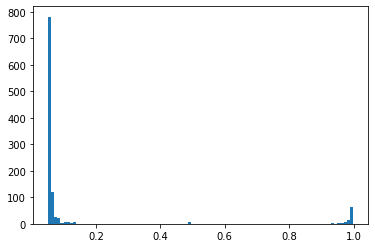

F1 score        : 0.6625
AUROC           : 0.9416931929480902
EER             : 0.0979431929480901
frr_at_eer      : 0.109375
far at zero frr : 0.9529872673849168
frr at 'zero' frr : 0.0


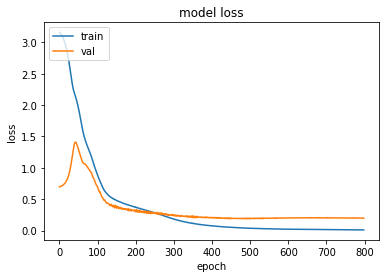

34/34 [==============================] - 1s 8ms/step
simpleConv


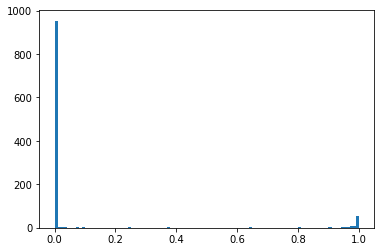

F1 score        : 0.6909090909090908
AUROC           : 0.9838087659157688
EER             : 0.05386875612144956
frr_at_eer      : 0.078125
far at zero frr : 0.14495592556317335
frr at 'zero' frr : 0.0


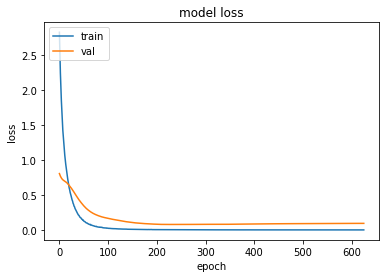

34/34 [==============================] - 0s 3ms/step
complexConv


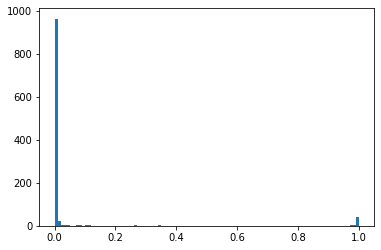

F1 score        : 0.8130081300813008
AUROC           : 0.9850177522037218
EER             : 0.07247796278158668
frr_at_eer      : 0.078125
far at zero frr : 0.20372184133202742
frr at 'zero' frr : 0.0


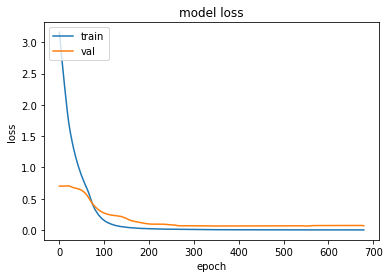

34/34 [==============================] - 1s 4ms/step
ConvLSTM


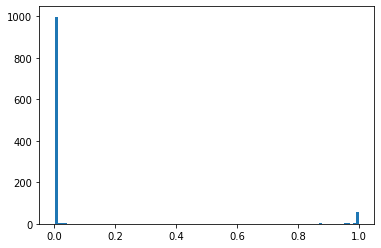

F1 score        : 0.8507462686567163
AUROC           : 0.9875122428991185
EER             : 0.01665034280117532
frr_at_eer      : 0.046875
far at zero frr : 0.2850146914789422
frr at 'zero' frr : 0.0
################   1   ####################
RF


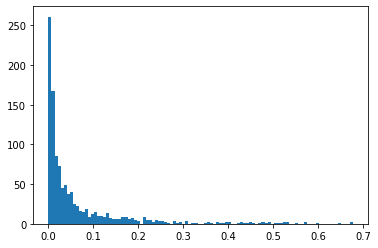

F1 score        : 0.35135135135135137
AUROC           : 0.9634146341463414
EER             : 0.0897560975609756
frr_at_eer      : 0.1
far at zero frr : 0.41853658536585364
frr at 'zero' frr : 0.0


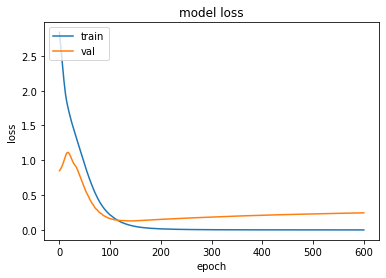

34/34 [==============================] - 0s 1ms/step
MLP


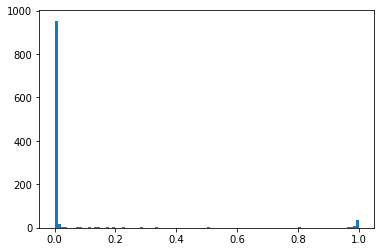

F1 score        : 0.7368421052631579
AUROC           : 0.9833333333333334
EER             : 0.06439024390243903
frr_at_eer      : 0.06666666666666667
far at zero frr : 0.27121951219512197
frr at 'zero' frr : 0.0


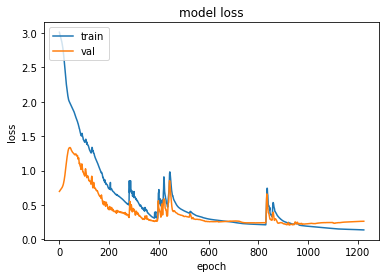

34/34 [==============================] - 1s 10ms/step
LSTM


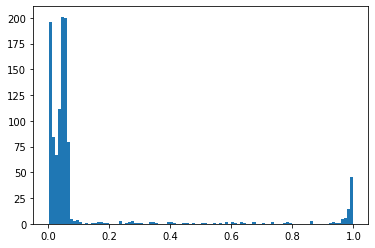

F1 score        : 0.5786163522012578
AUROC           : 0.8472845528455284
EER             : 0.08292682926829269
frr_at_eer      : 0.16666666666666666
far at zero frr : 0.984390243902439
frr at 'zero' frr : 0.0


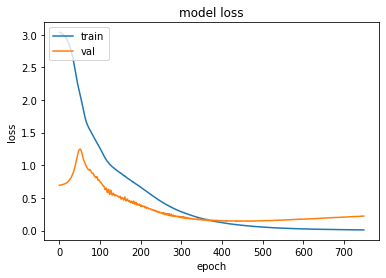

34/34 [==============================] - 1s 7ms/step
simpleConv


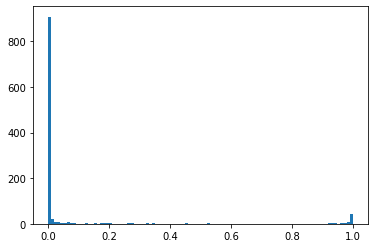

F1 score        : 0.736111111111111
AUROC           : 0.9891382113821138
EER             : 0.04682926829268293
frr_at_eer      : 0.05
far at zero frr : 0.06634146341463415
frr at 'zero' frr : 0.0


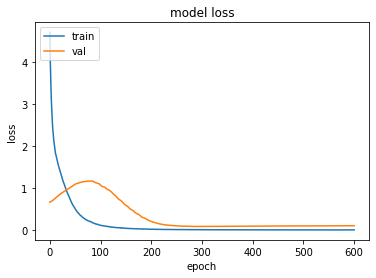

34/34 [==============================] - 0s 3ms/step
complexConv


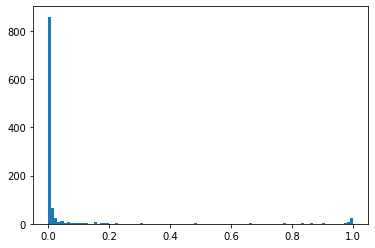

F1 score        : 0.7666666666666667
AUROC           : 0.9866829268292683
EER             : 0.04975609756097561
frr_at_eer      : 0.06666666666666667
far at zero frr : 0.16878048780487806
frr at 'zero' frr : 0.0


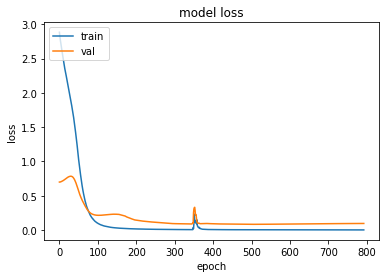

34/34 [==============================] - 1s 4ms/step
ConvLSTM


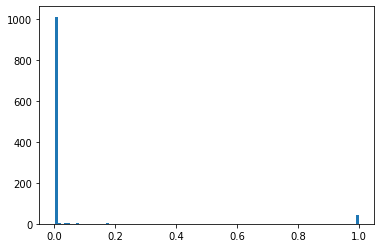

F1 score        : 0.6972477064220183
AUROC           : 0.8974796747967481
EER             : 0.11024390243902439
frr_at_eer      : 0.18333333333333332
far at zero frr : 0.9482926829268292
frr at 'zero' frr : 0.0
################   2   ####################
RF


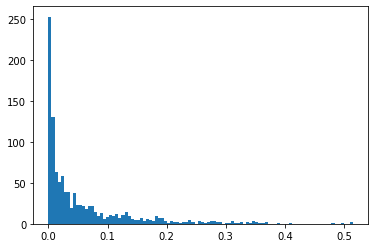

F1 score        : 0.05633802816901409
AUROC           : 0.8127924226862947
EER             : 0.26673228346456695
frr_at_eer      : 0.2898550724637681
far at zero frr : 0.8503937007874016
frr at 'zero' frr : 0.0


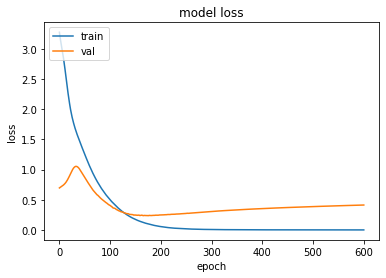

34/34 [==============================] - 0s 1ms/step
MLP


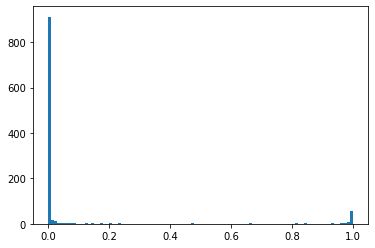

F1 score        : 0.18518518518518517
AUROC           : 0.6908592947620678
EER             : 0.3858267716535433
frr_at_eer      : 0.4057971014492754
far at zero frr : 0.7529527559055118
frr at 'zero' frr : 0.0


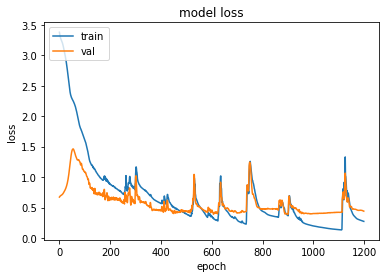

34/34 [==============================] - 1s 10ms/step
LSTM


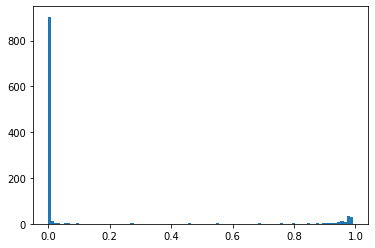

F1 score        : 0.29411764705882354
AUROC           : 0.7161217619536688
EER             : 0.19488188976377951
frr_at_eer      : 0.30434782608695654
far at zero frr : 0.9704724409448819
frr at 'zero' frr : 0.0


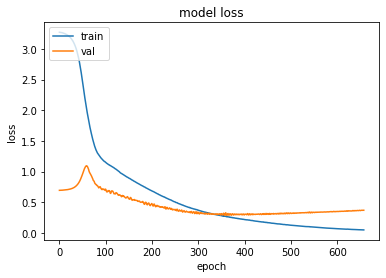

34/34 [==============================] - 1s 8ms/step
simpleConv


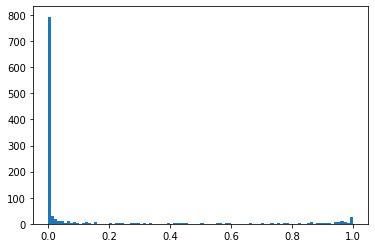

F1 score        : 0.21761658031088082
AUROC           : 0.7359637110578569
EER             : 0.28937007874015747
frr_at_eer      : 0.30434782608695654
far at zero frr : 0.8238188976377953
frr at 'zero' frr : 0.0


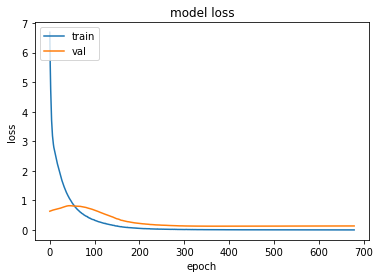

34/34 [==============================] - 0s 3ms/step
complexConv


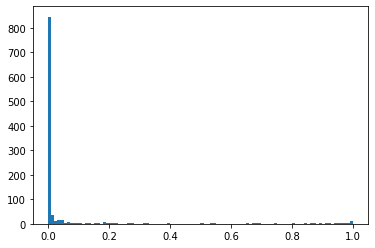

F1 score        : 0.23776223776223776
AUROC           : 0.8198961542850621
EER             : 0.2440944881889764
frr_at_eer      : 0.2463768115942029
far at zero frr : 0.9124015748031497
frr at 'zero' frr : 0.0


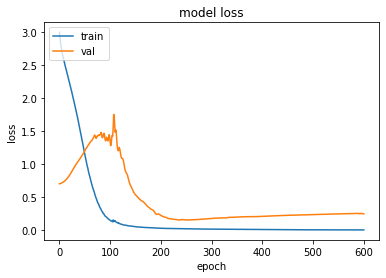

34/34 [==============================] - 1s 4ms/step
ConvLSTM


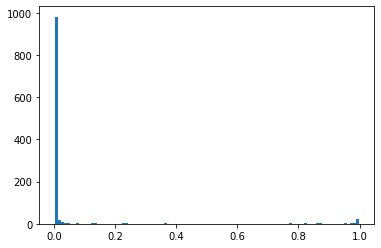

F1 score        : 0.39999999999999997
AUROC           : 0.7909962341663814
EER             : 0.2952755905511811
frr_at_eer      : 0.30434782608695654
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   3   ####################
RF


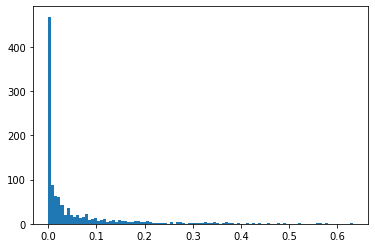

F1 score        : 0.19672131147540986
AUROC           : 0.9511890649136041
EER             : 0.09117361784675072
frr_at_eer      : 0.1111111111111111
far at zero frr : 0.7322987390882638
frr at 'zero' frr : 0.0


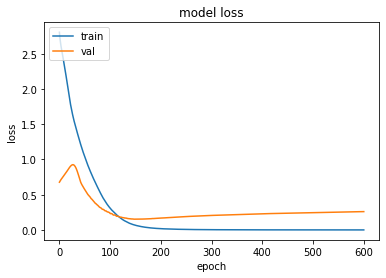

34/34 [==============================] - 0s 1ms/step
MLP


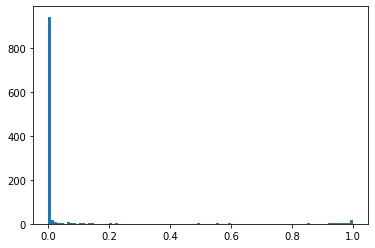

F1 score        : 0.38596491228070173
AUROC           : 0.8893738549412652
EER             : 0.2017458777885548
frr_at_eer      : 0.2222222222222222
far at zero frr : 0.6498545101842871
frr at 'zero' frr : 0.0


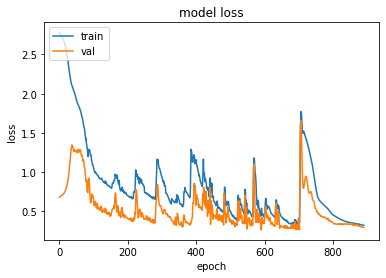

34/34 [==============================] - 1s 11ms/step
LSTM


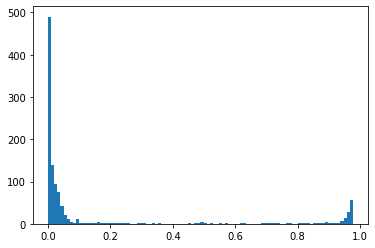

F1 score        : 0.3768115942028985
AUROC           : 0.8843805007723533
EER             : 0.16488845780795344
frr_at_eer      : 0.18518518518518517
far at zero frr : 0.6071774975751697
frr at 'zero' frr : 0.0


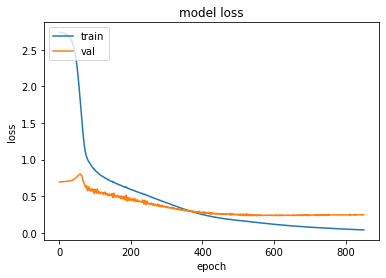

34/34 [==============================] - 1s 8ms/step
simpleConv


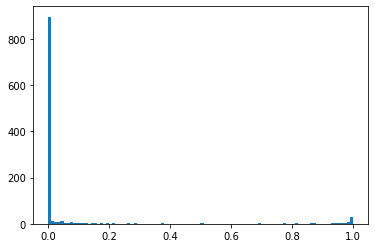

F1 score        : 0.48529411764705893
AUROC           : 0.9387685454610769
EER             : 0.1251212415130941
frr_at_eer      : 0.12962962962962962
far at zero frr : 0.4209505334626576
frr at 'zero' frr : 0.0


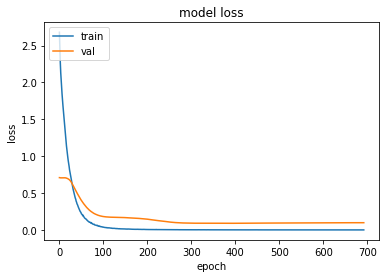

34/34 [==============================] - 0s 3ms/step
complexConv


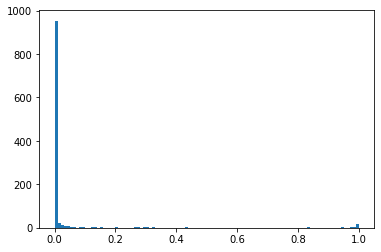

F1 score        : 0.4943820224719101
AUROC           : 0.9164421453461221
EER             : 0.11639185257032007
frr_at_eer      : 0.16666666666666666
far at zero frr : 0.9020368574199806
frr at 'zero' frr : 0.0


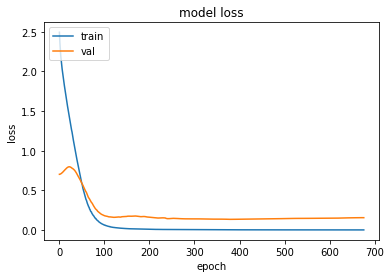

34/34 [==============================] - 1s 3ms/step
ConvLSTM


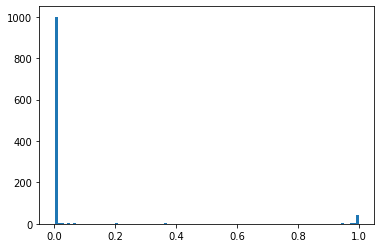

F1 score        : 0.5789473684210527
AUROC           : 0.8588389553471998
EER             : 0.2376333656644035
frr_at_eer      : 0.2777777777777778
far at zero frr : 0.8593598448108632
frr at 'zero' frr : 0.0
################   4   ####################
RF


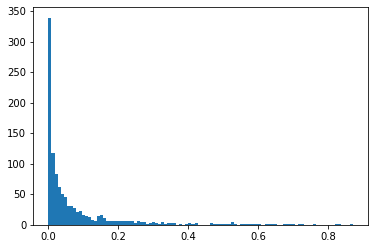

F1 score        : 0.46376811594202905
AUROC           : 0.9460470085470086
EER             : 0.13557594291539246
frr_at_eer      : 0.14423076923076922
far at zero frr : 0.42507645259938837
frr at 'zero' frr : 0.0


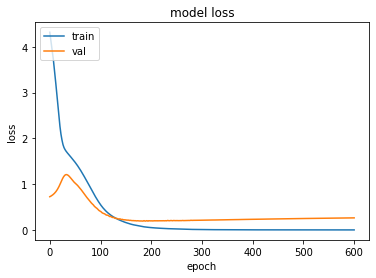

34/34 [==============================] - 0s 1ms/step
MLP


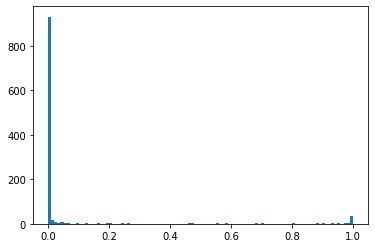

F1 score        : 0.4858757062146893
AUROC           : 0.8598172978906924
EER             : 0.2273190621814475
frr_at_eer      : 0.2403846153846154
far at zero frr : 0.9164118246687054
frr at 'zero' frr : 0.0


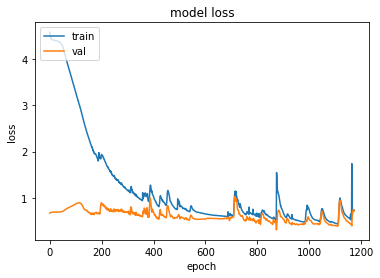

34/34 [==============================] - 1s 11ms/step
LSTM


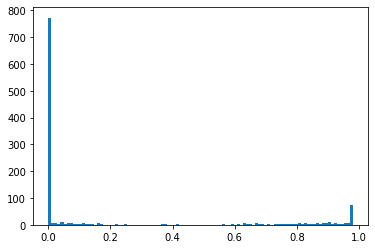

F1 score        : 0.6024844720496894
AUROC           : 0.9404845918607386
EER             : 0.10703363914373089
frr_at_eer      : 0.11538461538461539
far at zero frr : 0.4689092762487258
frr at 'zero' frr : 0.0


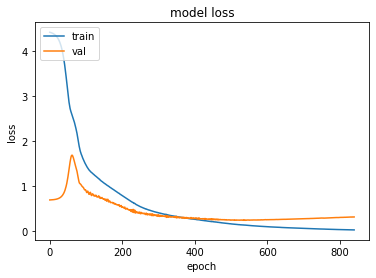

34/34 [==============================] - 1s 8ms/step
simpleConv


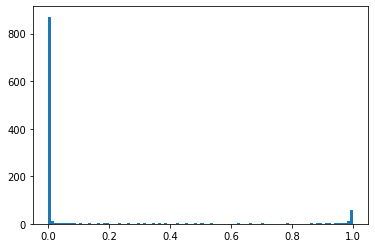

F1 score        : 0.717948717948718
AUROC           : 0.9685417156747431
EER             : 0.0744138634046891
frr_at_eer      : 0.09615384615384616
far at zero frr : 0.3843017329255861
frr at 'zero' frr : 0.0


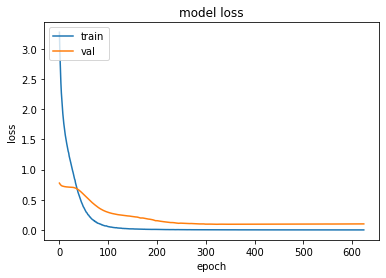

34/34 [==============================] - 0s 3ms/step
complexConv


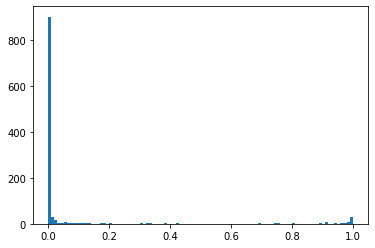

F1 score        : 0.6888888888888889
AUROC           : 0.9799360934682037
EER             : 0.05708460754332314
frr_at_eer      : 0.057692307692307696
far at zero frr : 0.24464831804281345
frr at 'zero' frr : 0.0


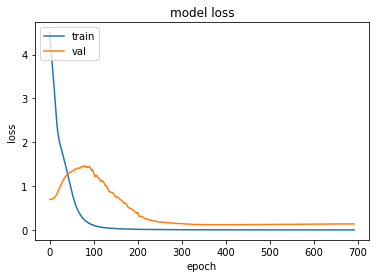

34/34 [==============================] - 1s 3ms/step
ConvLSTM


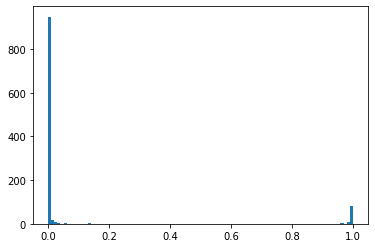

F1 score        : 0.8613861386138615
AUROC           : 0.9895024700070572
EER             : 0.040774719673802244
frr_at_eer      : 0.04807692307692308
far at zero frr : 0.23139653414882771
frr at 'zero' frr : 0.0
################   5   ####################
RF


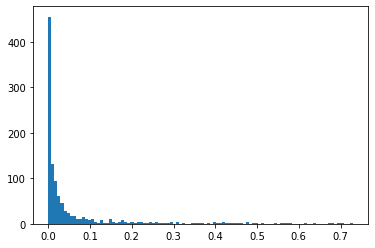

F1 score        : 0.3908045977011494
AUROC           : 0.9905559465165377
EER             : 0.042364532019704436
frr_at_eer      : 0.05714285714285714
far at zero frr : 0.06798029556650247
frr at 'zero' frr : 0.0


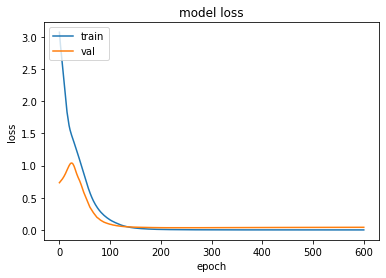

34/34 [==============================] - 0s 1ms/step
MLP


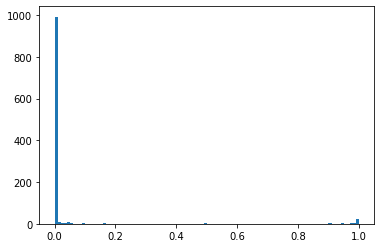

F1 score        : 0.7154471544715448
AUROC           : 0.9833356790992258
EER             : 0.04334975369458128
frr_at_eer      : 0.05714285714285714
far at zero frr : 0.17733990147783252
frr at 'zero' frr : 0.0


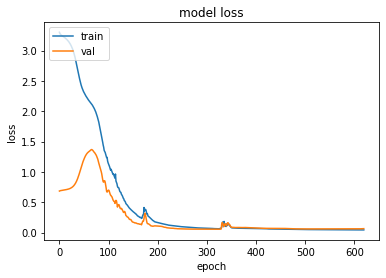

34/34 [==============================] - 1s 11ms/step
LSTM


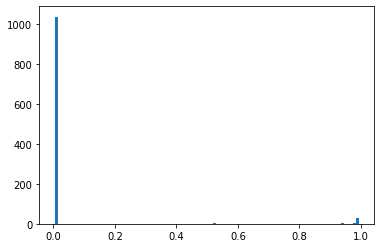

F1 score        : 0.5892857142857143
AUROC           : 0.5851090781140043
EER             : 0.4492610837438424
frr_at_eer      : 0.4857142857142857
far at zero frr : 0.9990147783251232
frr at 'zero' frr : 0.0


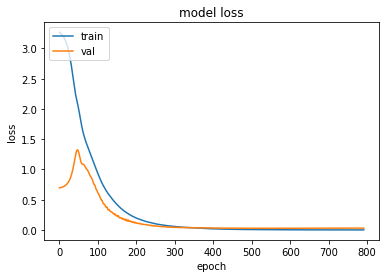

34/34 [==============================] - 1s 8ms/step
simpleConv


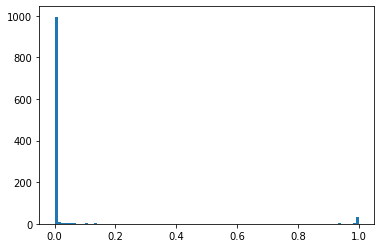

F1 score        : 0.7642276422764227
AUROC           : 0.9884447572132301
EER             : 0.04630541871921182
frr_at_eer      : 0.05714285714285714
far at zero frr : 0.15073891625615762
frr at 'zero' frr : 0.0


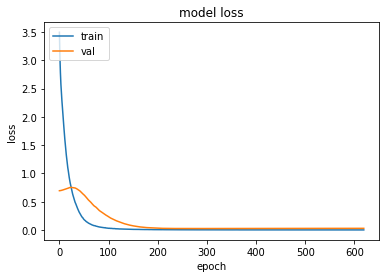

34/34 [==============================] - 0s 3ms/step
complexConv


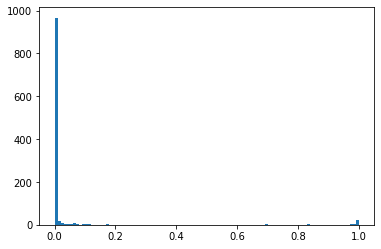

F1 score        : 0.8067226890756303
AUROC           : 0.9884306826178747
EER             : 0.06699507389162561
frr_at_eer      : 0.07142857142857142
far at zero frr : 0.12019704433497537
frr at 'zero' frr : 0.0


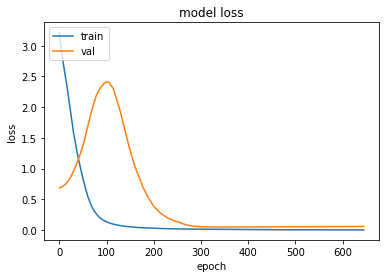

34/34 [==============================] - 1s 5ms/step
ConvLSTM


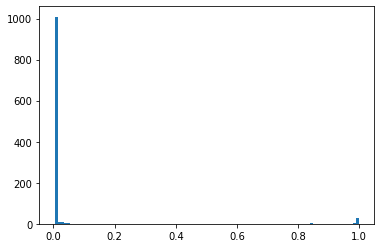

F1 score        : 0.6949152542372882
AUROC           : 0.9633075299085151
EER             : 0.10049261083743842
frr_at_eer      : 0.12857142857142856
far at zero frr : 0.2788177339901478
frr at 'zero' frr : 0.0
################   6   ####################
RF


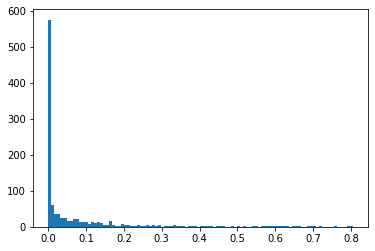

F1 score        : 0.7450980392156863
AUROC           : 0.9758876153201006
EER             : 0.05968688845401174
frr_at_eer      : 0.06349206349206349
far at zero frr : 1.0
frr at 'zero' frr : 0.0


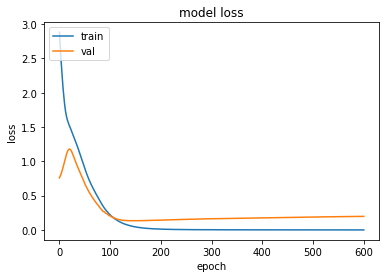

34/34 [==============================] - 0s 2ms/step
MLP


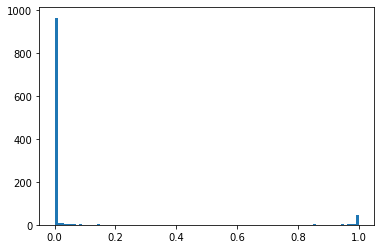

F1 score        : 0.7555555555555556
AUROC           : 0.98414251545367
EER             : 0.053816046966731895
frr_at_eer      : 0.06349206349206349
far at zero frr : 0.350293542074364
frr at 'zero' frr : 0.0


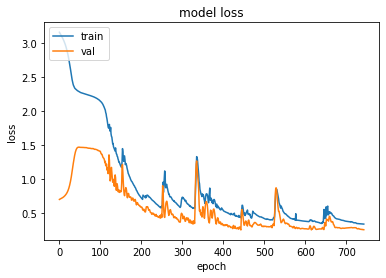

34/34 [==============================] - 1s 11ms/step
LSTM


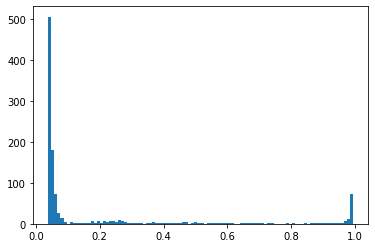

F1 score        : 0.4859813084112149
AUROC           : 0.9312272854347218
EER             : 0.10469667318982387
frr_at_eer      : 0.12698412698412698
far at zero frr : 0.684931506849315
frr at 'zero' frr : 0.0


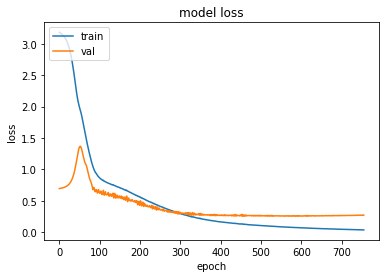

34/34 [==============================] - 1s 8ms/step
simpleConv


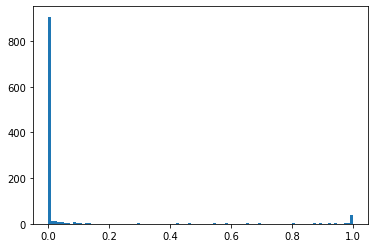

F1 score        : 0.7272727272727274
AUROC           : 0.9841269841269841
EER             : 0.06164383561643835
frr_at_eer      : 0.06349206349206349
far at zero frr : 0.22504892367906065
frr at 'zero' frr : 0.0


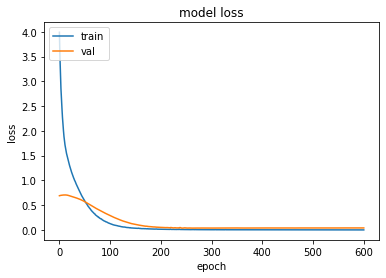

34/34 [==============================] - 1s 4ms/step
complexConv


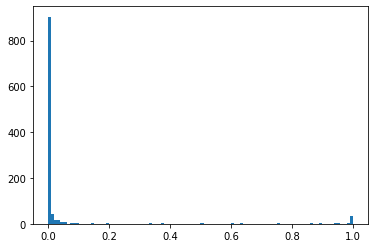

F1 score        : 0.8571428571428571
AUROC           : 0.9915198956294846
EER             : 0.014677103718199608
frr_at_eer      : 0.047619047619047616
far at zero frr : 0.18297455968688844
frr at 'zero' frr : 0.0


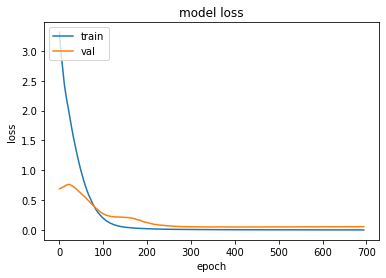

34/34 [==============================] - 1s 3ms/step
ConvLSTM


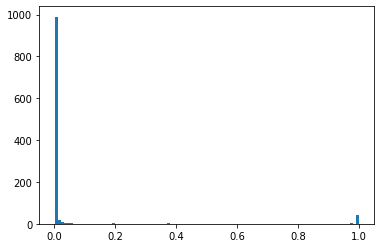

F1 score        : 0.8521739130434781
AUROC           : 0.977883390799242
EER             : 0.0410958904109589
frr_at_eer      : 0.047619047619047616
far at zero frr : 0.8170254403131115
frr at 'zero' frr : 0.0
################   7   ####################
RF


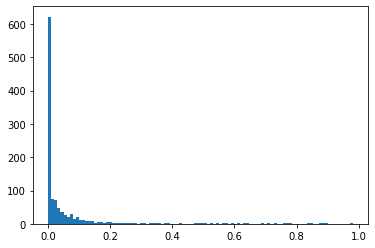

F1 score        : 0.5052631578947367
AUROC           : 0.9641520056298382
EER             : 0.10935960591133005
frr_at_eer      : 0.11428571428571428
far at zero frr : 0.26699507389162563
frr at 'zero' frr : 0.0


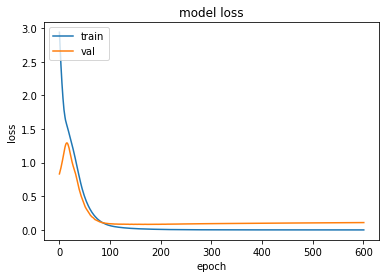

34/34 [==============================] - 0s 1ms/step
MLP


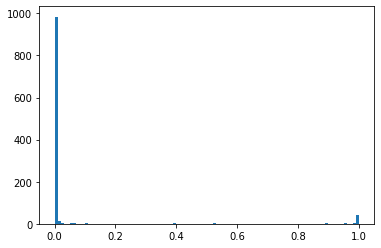

F1 score        : 0.65625
AUROC           : 0.9407037297677692
EER             : 0.10837438423645321
frr_at_eer      : 0.12857142857142856
far at zero frr : 0.6423645320197044
frr at 'zero' frr : 0.0


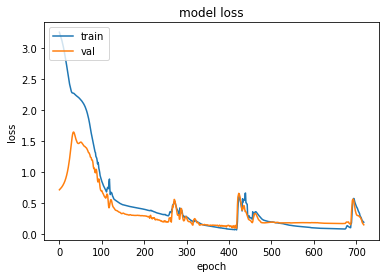

34/34 [==============================] - 1s 10ms/step
LSTM


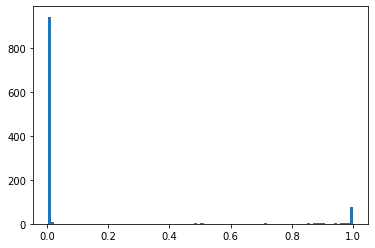

F1 score        : 0.5699481865284974
AUROC           : 0.8902744546094299
EER             : 0.08472906403940887
frr_at_eer      : 0.12857142857142856
far at zero frr : 0.948768472906404
frr at 'zero' frr : 0.0


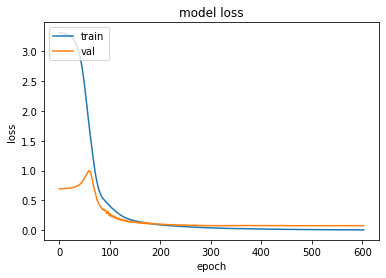

34/34 [==============================] - 1s 9ms/step
simpleConv


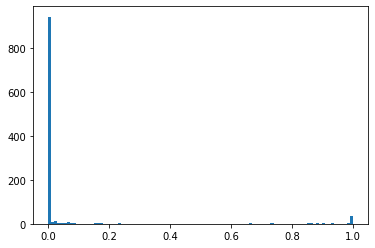

F1 score        : 0.7142857142857143
AUROC           : 0.9607178043631246
EER             : 0.08177339901477833
frr_at_eer      : 0.11428571428571428
far at zero frr : 0.3783251231527094
frr at 'zero' frr : 0.0


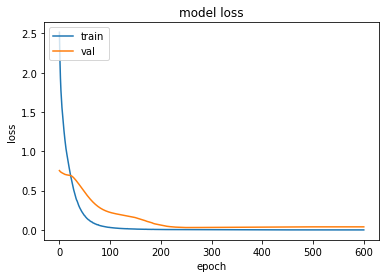

34/34 [==============================] - 0s 4ms/step
complexConv


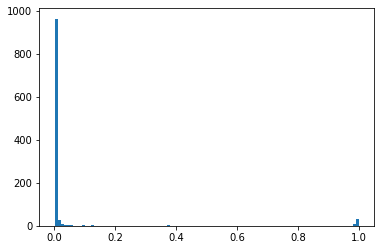

F1 score        : 0.7903225806451613
AUROC           : 0.9855172413793103
EER             : 0.03940886699507389
frr_at_eer      : 0.05714285714285714
far at zero frr : 0.4059113300492611
frr at 'zero' frr : 0.0


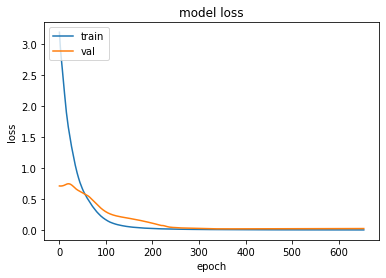

34/34 [==============================] - 1s 4ms/step
ConvLSTM


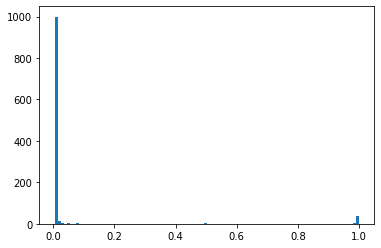

F1 score        : 0.8333333333333333
AUROC           : 0.9793525686136524
EER             : 0.05517241379310345
frr_at_eer      : 0.08571428571428572
far at zero frr : 0.34088669950738915
frr at 'zero' frr : 0.0
################   8   ####################
RF


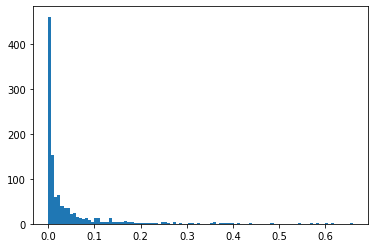

F1 score        : 0.09302325581395349
AUROC           : 0.9385831442129152
EER             : 0.13072519083969467
frr_at_eer      : 0.13513513513513514
far at zero frr : 0.4637404580152672
frr at 'zero' frr : 0.0


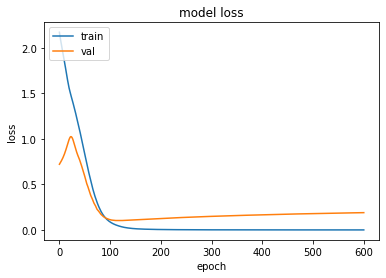

34/34 [==============================] - 0s 2ms/step
MLP


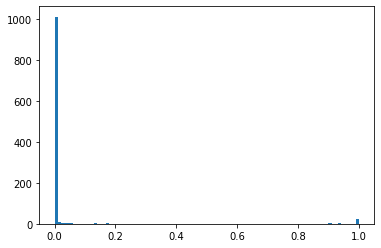

F1 score        : 0.5633802816901409
AUROC           : 0.9248504229420261
EER             : 0.1269083969465649
frr_at_eer      : 0.16216216216216217
far at zero frr : 0.7166030534351145
frr at 'zero' frr : 0.0


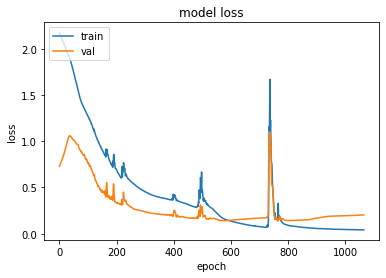

34/34 [==============================] - 1s 11ms/step
LSTM


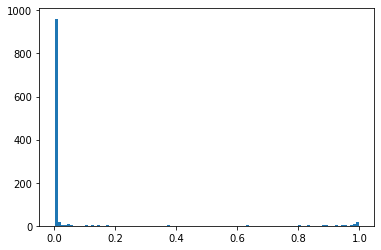

F1 score        : 0.5957446808510638
AUROC           : 0.8768052403548587
EER             : 0.12022900763358779
frr_at_eer      : 0.13513513513513514
far at zero frr : 0.9284351145038168
frr at 'zero' frr : 0.0


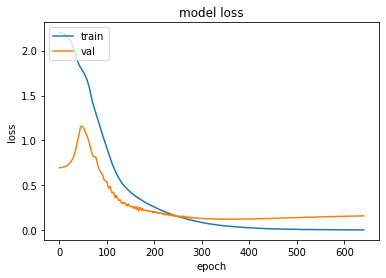

34/34 [==============================] - 1s 9ms/step
simpleConv


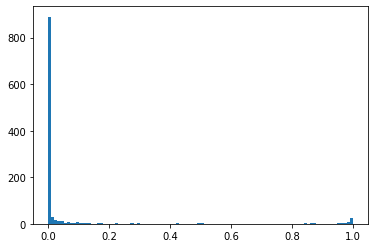

F1 score        : 0.5510204081632653
AUROC           : 0.9291829997936869
EER             : 0.08110687022900763
frr_at_eer      : 0.13513513513513514
far at zero frr : 0.5438931297709924
frr at 'zero' frr : 0.0


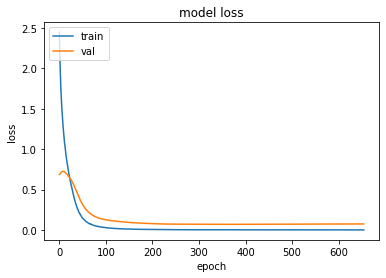

34/34 [==============================] - 0s 3ms/step
complexConv


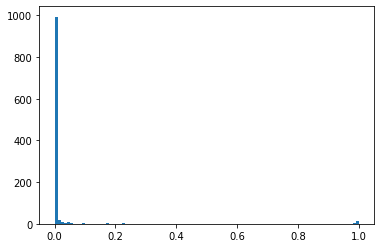

F1 score        : 0.5666666666666667
AUROC           : 0.972508768310295
EER             : 0.04103053435114504
frr_at_eer      : 0.10810810810810811
far at zero frr : 0.35877862595419846
frr at 'zero' frr : 0.0


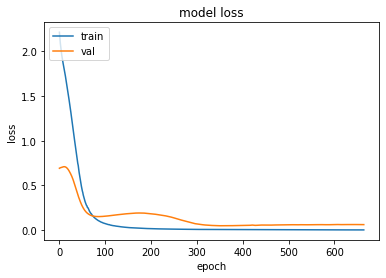

34/34 [==============================] - 1s 4ms/step
ConvLSTM


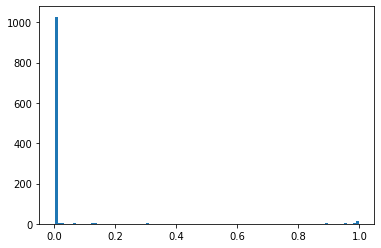

F1 score        : 0.6363636363636365
AUROC           : 0.9465390963482567
EER             : 0.0916030534351145
frr_at_eer      : 0.10810810810810811
far at zero frr : 0.5562977099236641
frr at 'zero' frr : 0.0
################   9   ####################
RF


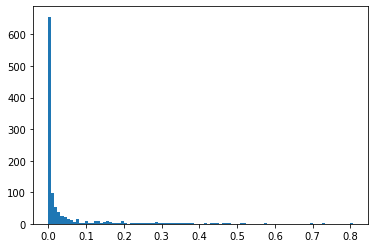

F1 score        : 0.2439024390243902
AUROC           : 0.9665578231292518
EER             : 0.07428571428571429
frr_at_eer      : 0.08571428571428572
far at zero frr : 0.20761904761904762
frr at 'zero' frr : 0.0


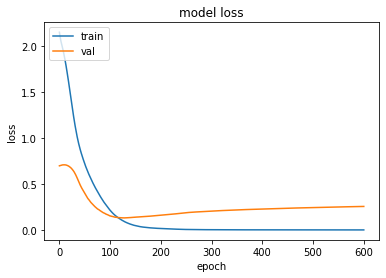

34/34 [==============================] - 0s 1ms/step
MLP


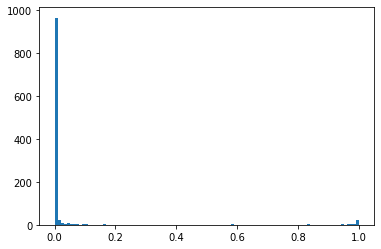

F1 score        : 0.4772727272727273
AUROC           : 0.9267755102040816
EER             : 0.11523809523809524
frr_at_eer      : 0.14285714285714285
far at zero frr : 0.41904761904761906
frr at 'zero' frr : 0.0


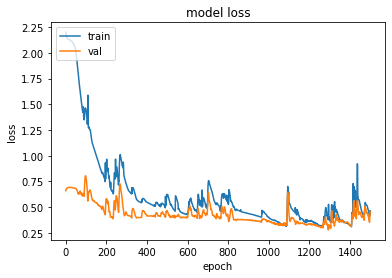

34/34 [==============================] - 1s 10ms/step
LSTM


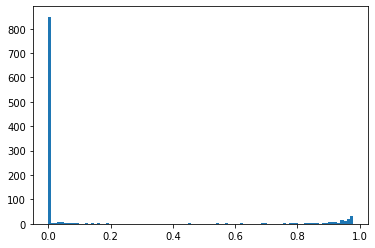

F1 score        : 0.3054187192118227
AUROC           : 0.9302040816326531
EER             : 0.11142857142857143
frr_at_eer      : 0.14285714285714285
far at zero frr : 0.44761904761904764
frr at 'zero' frr : 0.0


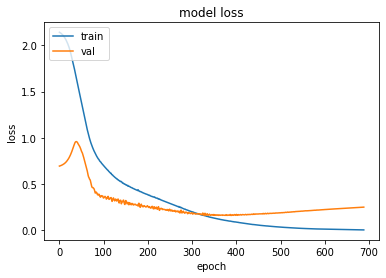

34/34 [==============================] - 1s 8ms/step
simpleConv


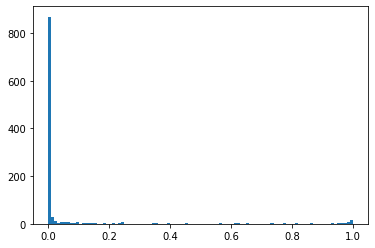

F1 score        : 0.4601769911504425
AUROC           : 0.9583401360544218
EER             : 0.09714285714285714
frr_at_eer      : 0.11428571428571428
far at zero frr : 0.21904761904761905
frr at 'zero' frr : 0.0


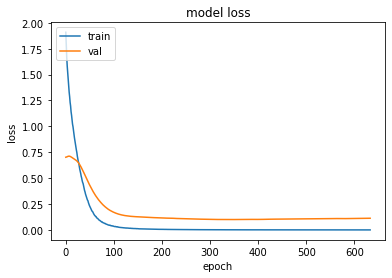

34/34 [==============================] - 0s 3ms/step
complexConv


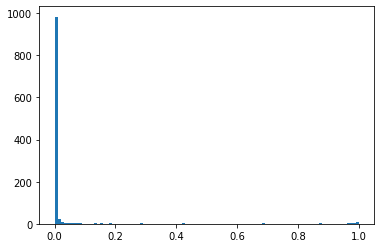

F1 score        : 0.5937499999999999
AUROC           : 0.956952380952381
EER             : 0.06
frr_at_eer      : 0.08571428571428572
far at zero frr : 0.6257142857142857
frr at 'zero' frr : 0.0


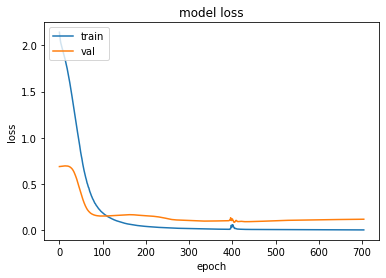

34/34 [==============================] - 1s 4ms/step
ConvLSTM


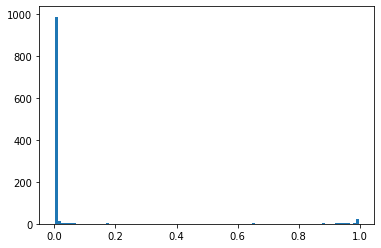

F1 score        : 0.5494505494505495
AUROC           : 0.9759727891156463
EER             : 0.05714285714285714
frr_at_eer      : 0.05714285714285714
far at zero frr : 0.16666666666666666
frr at 'zero' frr : 0.0
################   10   ####################
RF


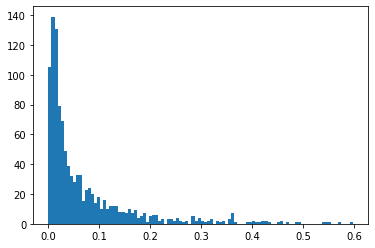

F1 score        : 0.13698630136986303
AUROC           : 0.919081496905547
EER             : 0.14650934119960668
frr_at_eer      : 0.16176470588235295
far at zero frr : 0.543756145526057
frr at 'zero' frr : 0.0


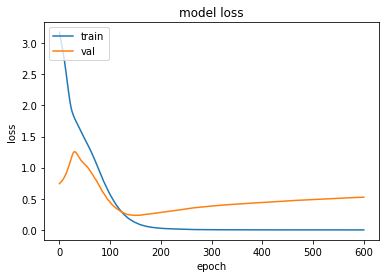

34/34 [==============================] - 0s 1ms/step
MLP


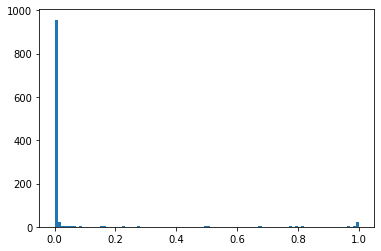

F1 score        : 0.47619047619047616
AUROC           : 0.8698305280814391
EER             : 0.12094395280235988
frr_at_eer      : 0.23529411764705882
far at zero frr : 0.9734513274336283
frr at 'zero' frr : 0.0


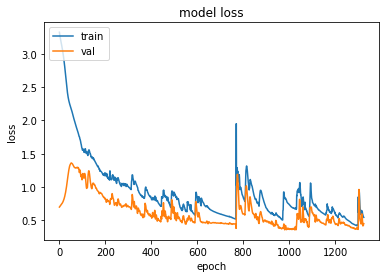

34/34 [==============================] - 1s 10ms/step
LSTM


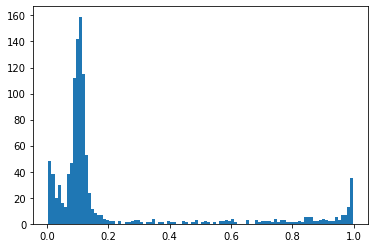

F1 score        : 0.42342342342342343
AUROC           : 0.8050928335936145
EER             : 0.16224188790560473
frr_at_eer      : 0.22058823529411764
far at zero frr : 0.9803343166175025
frr at 'zero' frr : 0.0


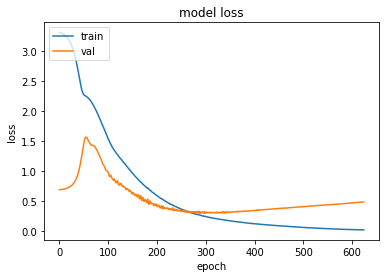

34/34 [==============================] - 1s 8ms/step
simpleConv


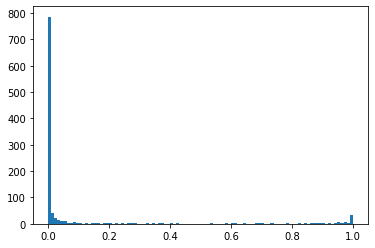

F1 score        : 0.46236559139784944
AUROC           : 0.9109694025102666
EER             : 0.17895771878072764
frr_at_eer      : 0.19117647058823528
far at zero frr : 0.3382497541789577
frr at 'zero' frr : 0.0


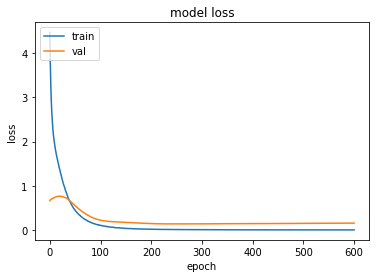

34/34 [==============================] - 0s 3ms/step
complexConv


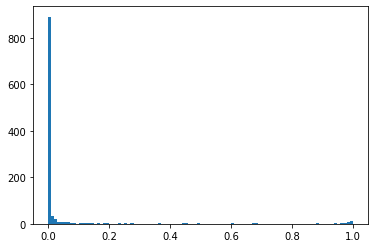

F1 score        : 0.6101694915254237
AUROC           : 0.9404823876453235
EER             : 0.11799410029498525
frr_at_eer      : 0.1323529411764706
far at zero frr : 0.5614552605703048
frr at 'zero' frr : 0.0


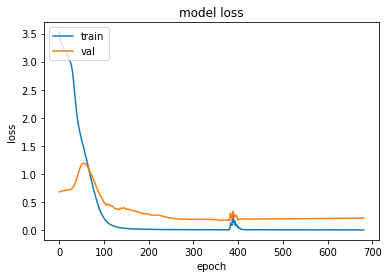

34/34 [==============================] - 1s 4ms/step
ConvLSTM


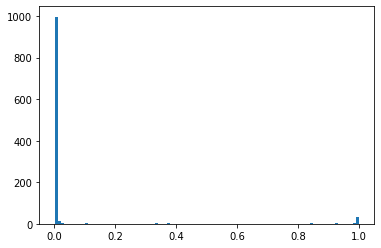

F1 score        : 0.5245901639344261
AUROC           : 0.8499624038405924
EER             : 0.1848574237954769
frr_at_eer      : 0.19117647058823528
far at zero frr : 0.9813176007866273
frr at 'zero' frr : 0.0
################   11   ####################
RF


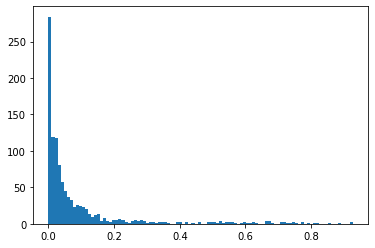

F1 score        : 0.7571428571428571
AUROC           : 0.9883235294117647
EER             : 0.033
frr_at_eer      : 0.047058823529411764
far at zero frr : 0.262
frr at 'zero' frr : 0.0


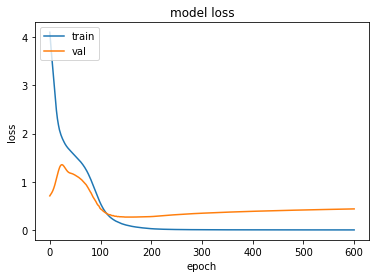

34/34 [==============================] - 0s 2ms/step
MLP


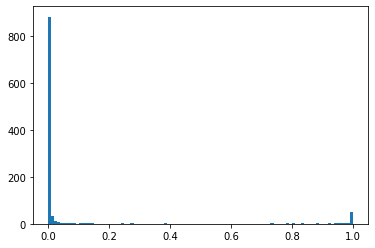

F1 score        : 0.688888888888889
AUROC           : 0.919235294117647
EER             : 0.152
frr_at_eer      : 0.15294117647058825
far at zero frr : 1.0
frr at 'zero' frr : 0.0


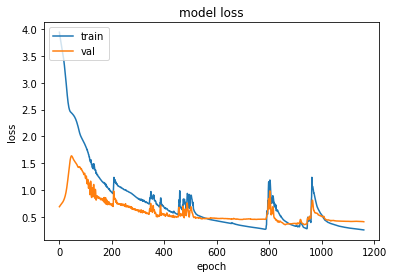

34/34 [==============================] - 2s 12ms/step
LSTM


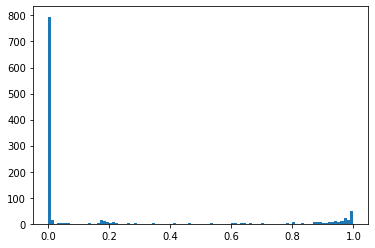

F1 score        : 0.4676258992805756
AUROC           : 0.900235294117647
EER             : 0.155
frr_at_eer      : 0.2
far at zero frr : 0.841
frr at 'zero' frr : 0.0


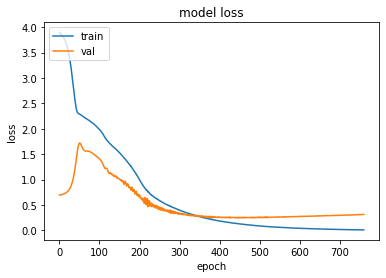

34/34 [==============================] - 1s 8ms/step
simpleConv


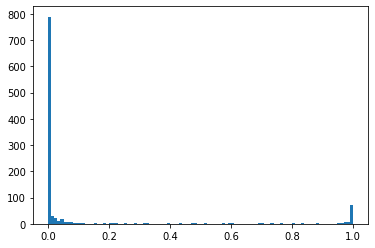

F1 score        : 0.6334841628959276
AUROC           : 0.9333411764705882
EER             : 0.113
frr_at_eer      : 0.1411764705882353
far at zero frr : 0.951
frr at 'zero' frr : 0.0


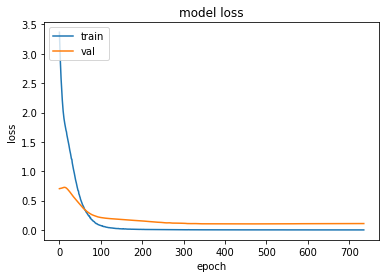

34/34 [==============================] - 0s 3ms/step
complexConv


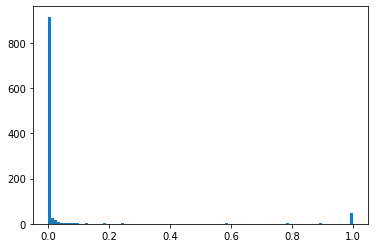

F1 score        : 0.8427672955974842
AUROC           : 0.9715882352941176
EER             : 0.086
frr_at_eer      : 0.09411764705882353
far at zero frr : 0.708
frr at 'zero' frr : 0.0


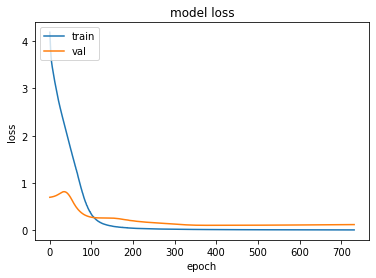

34/34 [==============================] - 1s 4ms/step
ConvLSTM


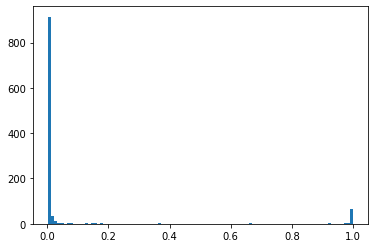

F1 score        : 0.813953488372093
AUROC           : 0.9710941176470588
EER             : 0.07
frr_at_eer      : 0.07058823529411765
far at zero frr : 0.853
frr at 'zero' frr : 0.0
################   12   ####################
RF


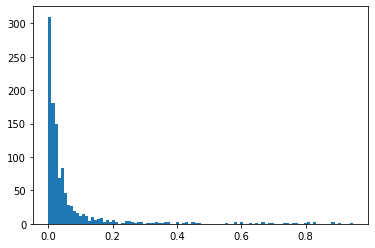

F1 score        : 0.5544554455445544
AUROC           : 0.981773512372083
EER             : 0.06225296442687747
frr_at_eer      : 0.0684931506849315
far at zero frr : 0.1956521739130435
frr at 'zero' frr : 0.0


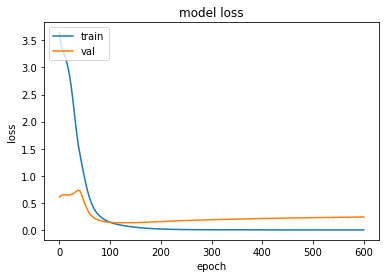

34/34 [==============================] - 0s 2ms/step
MLP


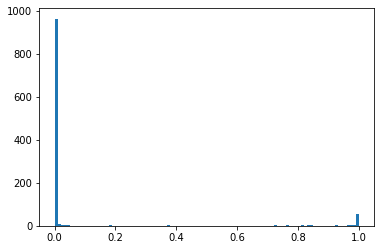

F1 score        : 0.7898089171974523
AUROC           : 0.991133791759164
EER             : 0.042490118577075096
frr_at_eer      : 0.0547945205479452
far at zero frr : 0.11758893280632411
frr at 'zero' frr : 0.0


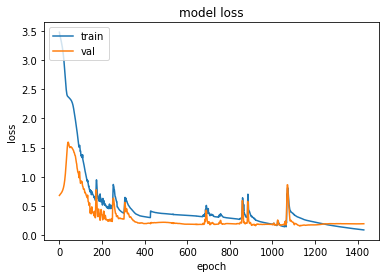

34/34 [==============================] - 1s 11ms/step
LSTM


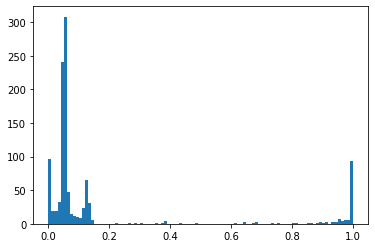

F1 score        : 0.6009389671361502
AUROC           : 0.9483729492663382
EER             : 0.09980237154150198
frr_at_eer      : 0.1095890410958904
far at zero frr : 0.9881422924901185
frr at 'zero' frr : 0.0


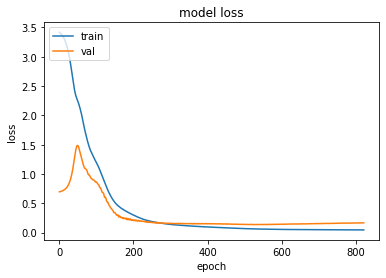

34/34 [==============================] - 1s 8ms/step
simpleConv


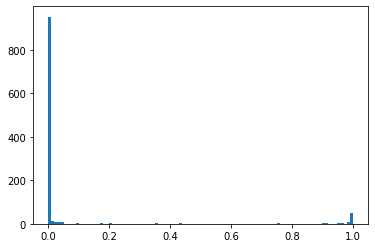

F1 score        : 0.7785234899328859
AUROC           : 0.9863284422545887
EER             : 0.0533596837944664
frr_at_eer      : 0.0547945205479452
far at zero frr : 0.18675889328063242
frr at 'zero' frr : 0.0


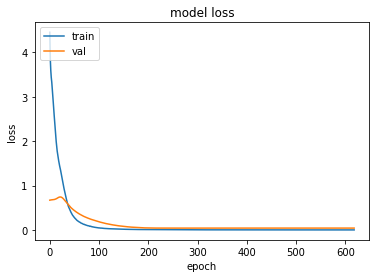

34/34 [==============================] - 0s 3ms/step
complexConv


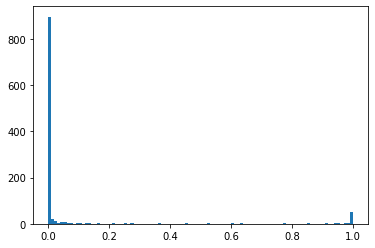

F1 score        : 0.7682926829268293
AUROC           : 0.9896042016351724
EER             : 0.05138339920948617
frr_at_eer      : 0.0684931506849315
far at zero frr : 0.08893280632411067
frr at 'zero' frr : 0.0


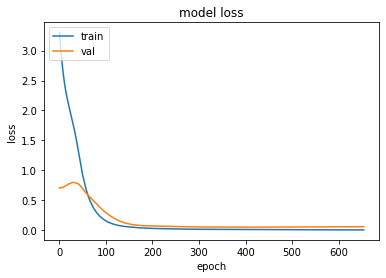

34/34 [==============================] - 1s 4ms/step
ConvLSTM


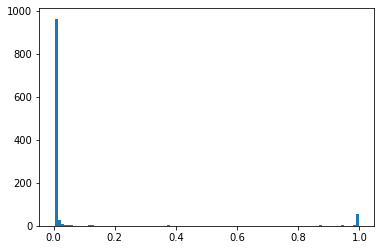

F1 score        : 0.9014084507042253
AUROC           : 0.992446802750555
EER             : 0.03162055335968379
frr_at_eer      : 0.0547945205479452
far at zero frr : 0.15217391304347827
frr at 'zero' frr : 0.0
################   13   ####################
RF


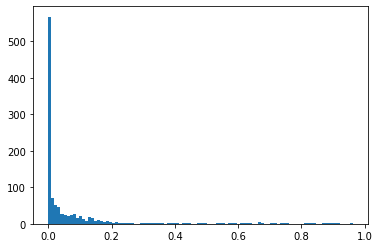

F1 score        : 0.7499999999999999
AUROC           : 0.9968910891089109
EER             : 0.02178217821782178
frr_at_eer      : 0.02666666666666667
far at zero frr : 0.06336633663366337
frr at 'zero' frr : 0.0


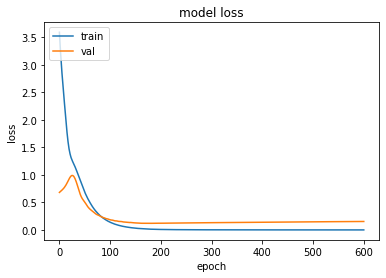

34/34 [==============================] - 0s 1ms/step
MLP


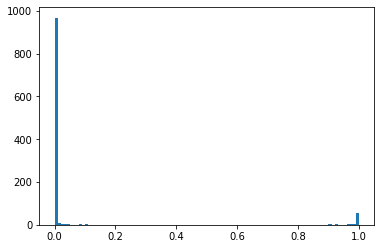

F1 score        : 0.8441558441558442
AUROC           : 0.9914257425742574
EER             : 0.03663366336633663
frr_at_eer      : 0.04
far at zero frr : 0.2079207920792079
frr at 'zero' frr : 0.0


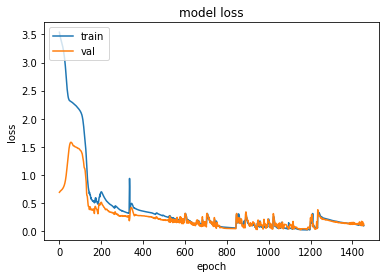

34/34 [==============================] - 1s 11ms/step
LSTM


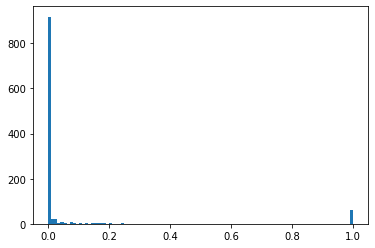

F1 score        : 0.8489208633093526
AUROC           : 0.9879075907590759
EER             : 0.040594059405940595
frr_at_eer      : 0.05333333333333334
far at zero frr : 0.16435643564356436
frr at 'zero' frr : 0.0


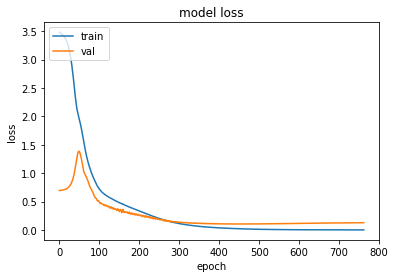

34/34 [==============================] - 1s 8ms/step
simpleConv


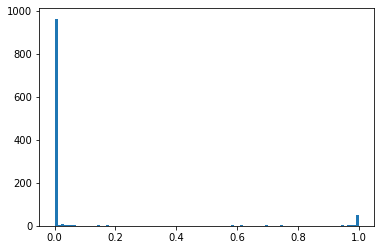

F1 score        : 0.8205128205128205
AUROC           : 0.9891353135313531
EER             : 0.048514851485148516
frr_at_eer      : 0.05333333333333334
far at zero frr : 0.16633663366336635
frr at 'zero' frr : 0.0


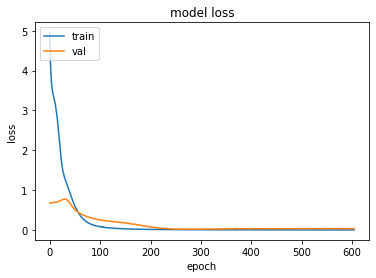

34/34 [==============================] - 0s 4ms/step
complexConv


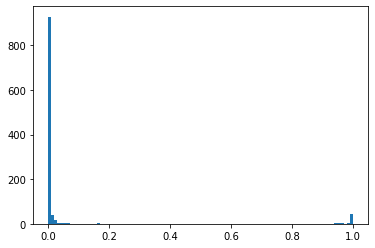

F1 score        : 0.9251700680272109
AUROC           : 0.9886072607260725
EER             : 0.0049504950495049506
frr_at_eer      : 0.02666666666666667
far at zero frr : 0.7722772277227723
frr at 'zero' frr : 0.0


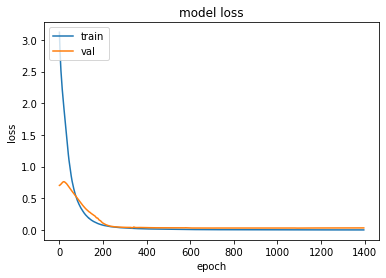

34/34 [==============================] - 1s 4ms/step
ConvLSTM


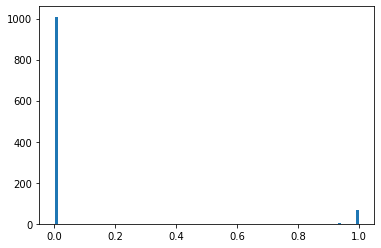

F1 score        : 0.9795918367346939
AUROC           : 0.9957887788778879
EER             : 0.0019801980198019802
frr_at_eer      : 0.013333333333333334
far at zero frr : 0.31287128712871287
frr at 'zero' frr : 0.0
################   14   ####################
RF


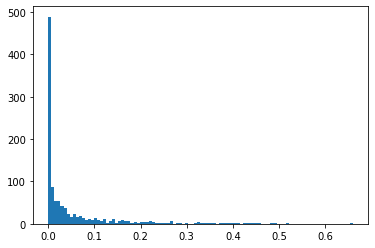

F1 score        : 0.04878048780487806
AUROC           : 0.9791542288557215
EER             : 0.061691542288557215
frr_at_eer      : 0.075
far at zero frr : 0.12238805970149254
frr at 'zero' frr : 0.0


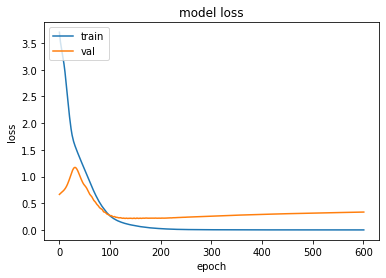

34/34 [==============================] - 0s 1ms/step
MLP


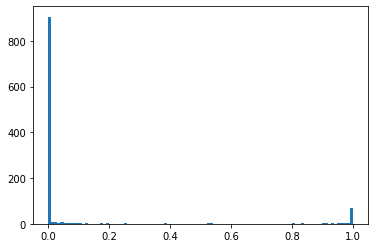

F1 score        : 0.6979166666666667
AUROC           : 0.9738308457711442
EER             : 0.07562189054726368
frr_at_eer      : 0.0875
far at zero frr : 0.46766169154228854
frr at 'zero' frr : 0.0


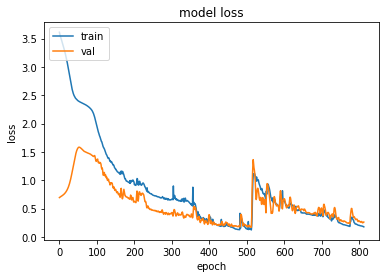

34/34 [==============================] - 1s 11ms/step
LSTM


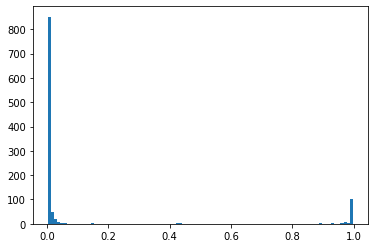

F1 score        : 0.6915887850467289
AUROC           : 0.9541169154228856
EER             : 0.050746268656716415
frr_at_eer      : 0.075
far at zero frr : 0.7810945273631841
frr at 'zero' frr : 0.0


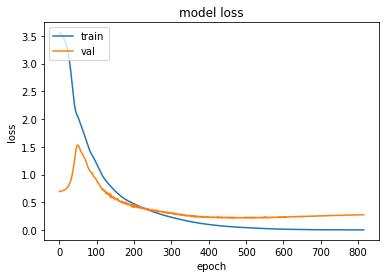

34/34 [==============================] - 1s 8ms/step
simpleConv


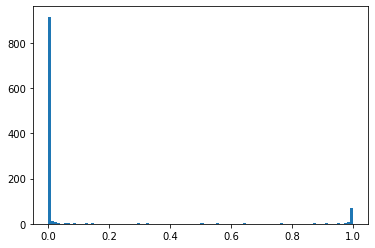

F1 score        : 0.7708333333333333
AUROC           : 0.9832089552238806
EER             : 0.046766169154228855
frr_at_eer      : 0.05
far at zero frr : 0.2228855721393035
frr at 'zero' frr : 0.0


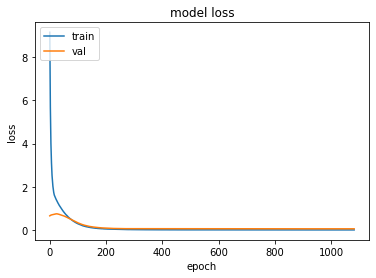

34/34 [==============================] - 0s 3ms/step
complexConv


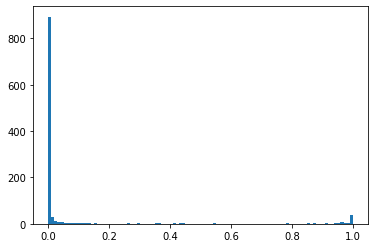

F1 score        : 0.8571428571428572
AUROC           : 0.9904353233830845
EER             : 0.04079601990049751
frr_at_eer      : 0.05
far at zero frr : 0.13930348258706468
frr at 'zero' frr : 0.0


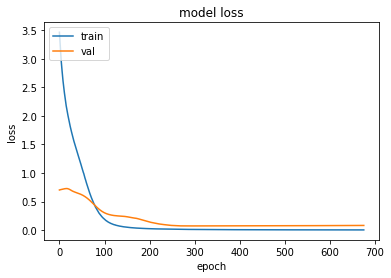

34/34 [==============================] - 1s 4ms/step
ConvLSTM


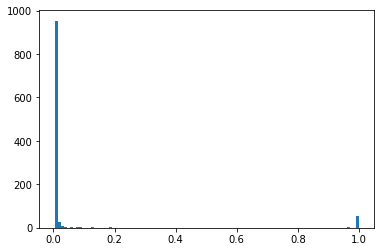

F1 score        : 0.8243243243243242
AUROC           : 0.9891417910447761
EER             : 0.03482587064676617
frr_at_eer      : 0.0375
far at zero frr : 0.29054726368159206
frr at 'zero' frr : 0.0
################   15   ####################
RF


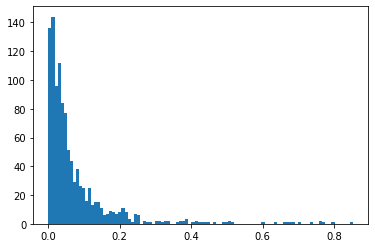

F1 score        : 0.3404255319148936
AUROC           : 0.9447202912942734
EER             : 0.13306852035749753
frr_at_eer      : 0.14102564102564102
far at zero frr : 0.4051638530287984
frr at 'zero' frr : 0.0


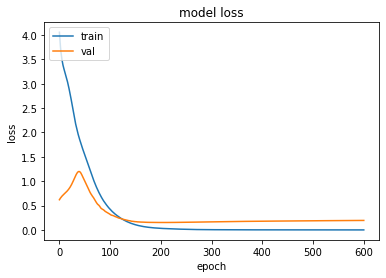

34/34 [==============================] - 0s 2ms/step
MLP


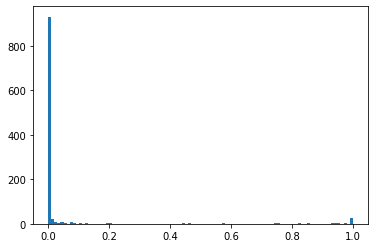

F1 score        : 0.44594594594594594
AUROC           : 0.9129300028009065
EER             : 0.1608738828202582
frr_at_eer      : 0.16666666666666666
far at zero frr : 0.7130089374379345
frr at 'zero' frr : 0.0


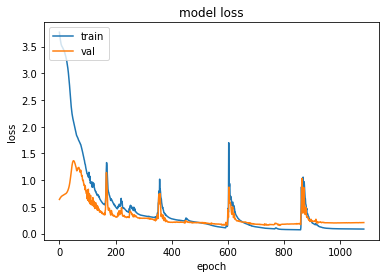

34/34 [==============================] - 1s 11ms/step
LSTM


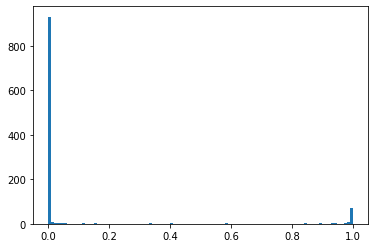

F1 score        : 0.7065217391304348
AUROC           : 0.9773572174267309
EER             : 0.07745779543197617
frr_at_eer      : 0.08974358974358974
far at zero frr : 0.1936444885799404
frr at 'zero' frr : 0.0


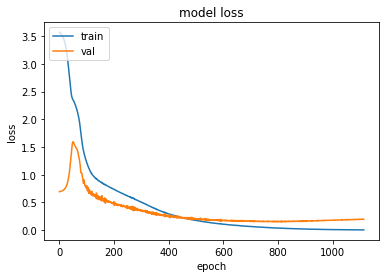

34/34 [==============================] - 1s 8ms/step
simpleConv


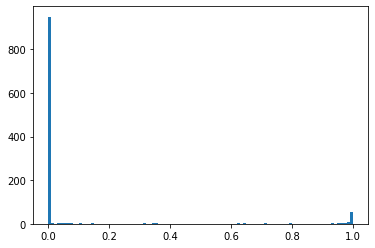

F1 score        : 0.686046511627907
AUROC           : 0.9709851551956815
EER             : 0.07149950347567031
frr_at_eer      : 0.07692307692307693
far at zero frr : 0.40615690168818275
frr at 'zero' frr : 0.0


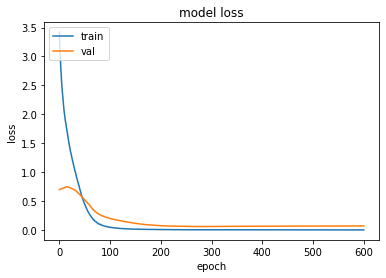

34/34 [==============================] - 0s 3ms/step
complexConv


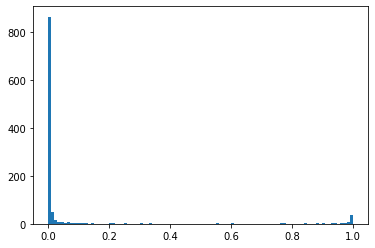

F1 score        : 0.8250000000000001
AUROC           : 0.9890128077814275
EER             : 0.04369414101290963
frr_at_eer      : 0.0641025641025641
far at zero frr : 0.14796425024826215
frr at 'zero' frr : 0.0


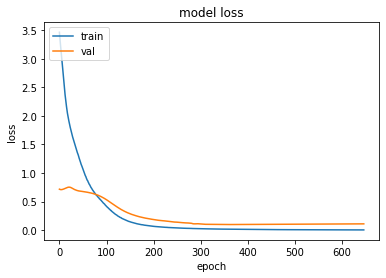

34/34 [==============================] - 1s 3ms/step
ConvLSTM


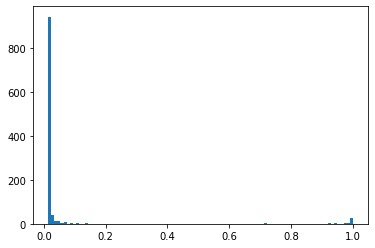

F1 score        : 0.6829268292682926
AUROC           : 0.9553510045069131
EER             : 0.11519364448857994
frr_at_eer      : 0.11538461538461539
far at zero frr : 0.40814299900695133
frr at 'zero' frr : 0.0
################   0   ####################
RF


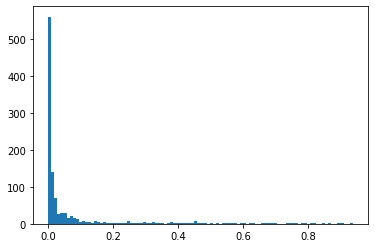

F1 score        : 0.5742574257425742
AUROC           : 0.9656739715964741
EER             : 0.0842311459353575
frr_at_eer      : 0.09375
far at zero frr : 0.4250734573947111
frr at 'zero' frr : 0.0


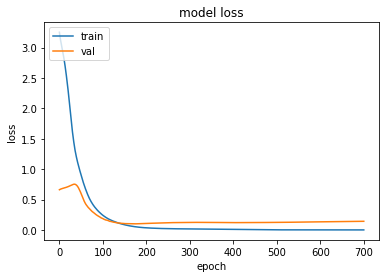

34/34 [==============================] - 0s 1ms/step
MLP


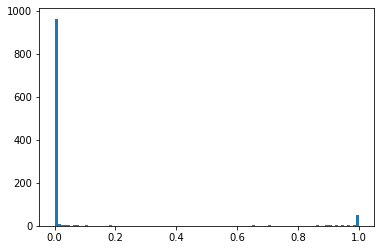

F1 score        : 0.7682119205298014
AUROC           : 0.9868388834476004
EER             : 0.043095004897159644
frr_at_eer      : 0.046875
far at zero frr : 0.14593535749265427
frr at 'zero' frr : 0.0


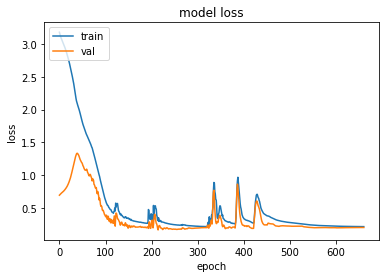

34/34 [==============================] - 1s 11ms/step
LSTM


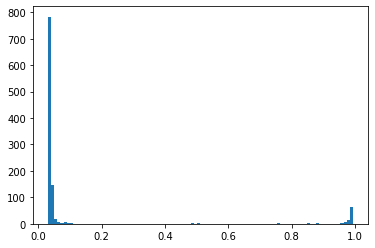

F1 score        : 0.6909090909090908
AUROC           : 0.9240481145935356
EER             : 0.06072477962781587
frr_at_eer      : 0.09375
far at zero frr : 0.9911851126346719
frr at 'zero' frr : 0.0


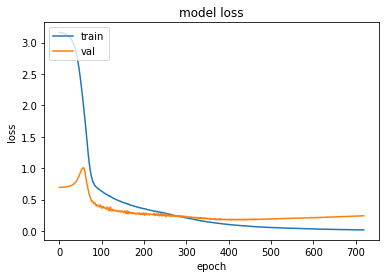

34/34 [==============================] - 1s 8ms/step
simpleConv


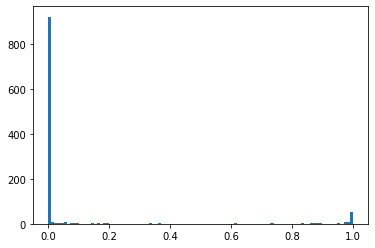

F1 score        : 0.6987951807228915
AUROC           : 0.9801971106758081
EER             : 0.04701273261508325
frr_at_eer      : 0.0625
far at zero frr : 0.5053868756121449
frr at 'zero' frr : 0.0


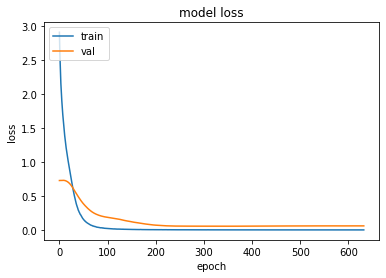

34/34 [==============================] - 0s 3ms/step
complexConv


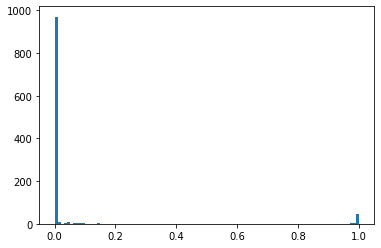

F1 score        : 0.8346456692913385
AUROC           : 0.9822018854064642
EER             : 0.04211557296767875
frr_at_eer      : 0.046875
far at zero frr : 0.7659157688540646
frr at 'zero' frr : 0.0


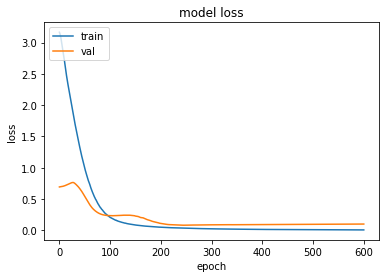

34/34 [==============================] - 2s 4ms/step
ConvLSTM


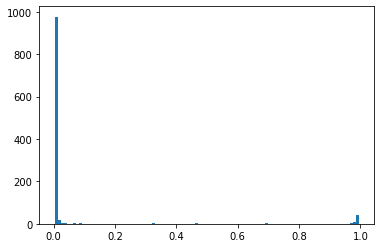

F1 score        : 0.7846153846153846
AUROC           : 0.9692091087169442
EER             : 0.047992164544564155
frr_at_eer      : 0.0625
far at zero frr : 0.7894221351616063
frr at 'zero' frr : 0.0
################   1   ####################
RF


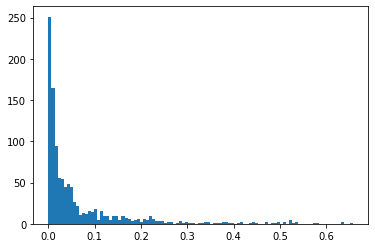

F1 score        : 0.35135135135135137
AUROC           : 0.9630731707317074
EER             : 0.09560975609756098
frr_at_eer      : 0.1
far at zero frr : 0.3951219512195122
frr at 'zero' frr : 0.0


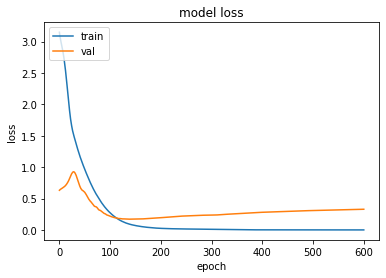

34/34 [==============================] - 0s 1ms/step
MLP


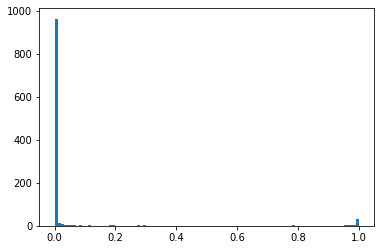

F1 score        : 0.7899159663865546
AUROC           : 0.9854146341463415
EER             : 0.05658536585365854
frr_at_eer      : 0.06666666666666667
far at zero frr : 0.15024390243902438
frr at 'zero' frr : 0.0


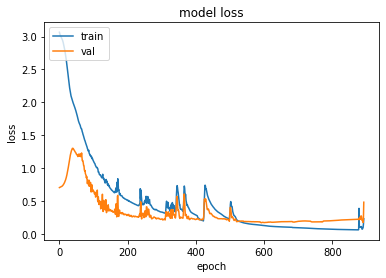

34/34 [==============================] - 2s 10ms/step
LSTM


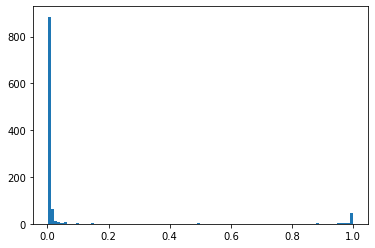

F1 score        : 0.6808510638297872
AUROC           : 0.9531219512195123
EER             : 0.08390243902439025
frr_at_eer      : 0.1
far at zero frr : 0.5395121951219513
frr at 'zero' frr : 0.0


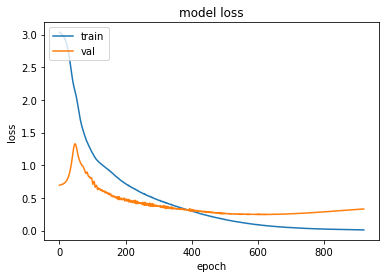

34/34 [==============================] - 1s 8ms/step
simpleConv


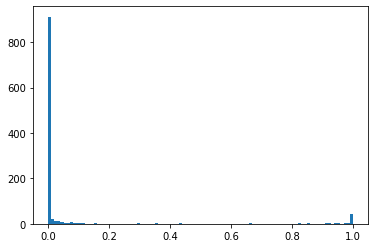

F1 score        : 0.6567164179104478
AUROC           : 0.9764878048780488
EER             : 0.07512195121951219
frr_at_eer      : 0.08333333333333333
far at zero frr : 0.33463414634146343
frr at 'zero' frr : 0.0


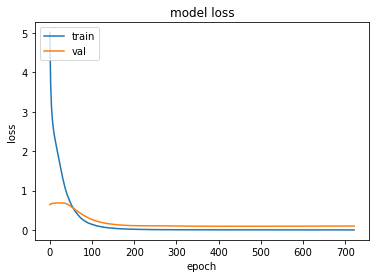

34/34 [==============================] - 0s 3ms/step
complexConv


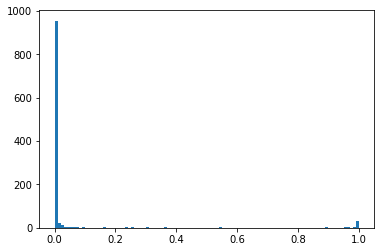

F1 score        : 0.793103448275862
AUROC           : 0.975170731707317
EER             : 0.03414634146341464
frr_at_eer      : 0.05
far at zero frr : 0.5863414634146341
frr at 'zero' frr : 0.0


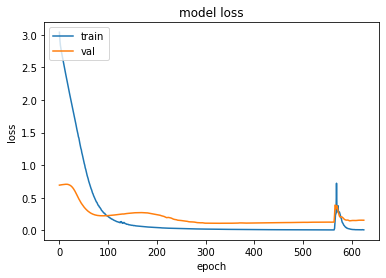

34/34 [==============================] - 1s 4ms/step
ConvLSTM


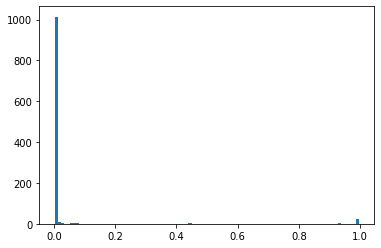

F1 score        : 0.6391752577319588
AUROC           : 0.9165040650406504
EER             : 0.09853658536585366
frr_at_eer      : 0.13333333333333333
far at zero frr : 0.88
frr at 'zero' frr : 0.0
################   2   ####################
RF


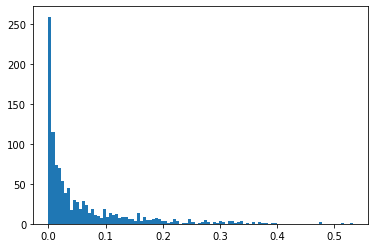

F1 score        : 0.05633802816901409
AUROC           : 0.8054533264863631
EER             : 0.2765748031496063
frr_at_eer      : 0.2898550724637681
far at zero frr : 0.7450787401574803
frr at 'zero' frr : 0.0


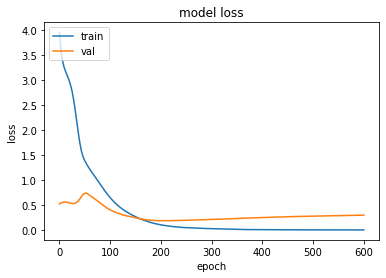

34/34 [==============================] - 0s 1ms/step
MLP


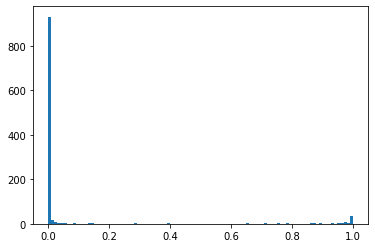

F1 score        : 0.24539877300613494
AUROC           : 0.7682728517630948
EER             : 0.3080708661417323
frr_at_eer      : 0.3188405797101449
far at zero frr : 0.7283464566929134
frr at 'zero' frr : 0.0


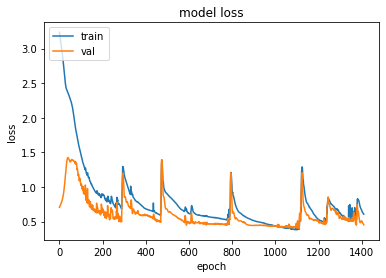

34/34 [==============================] - 2s 13ms/step
LSTM


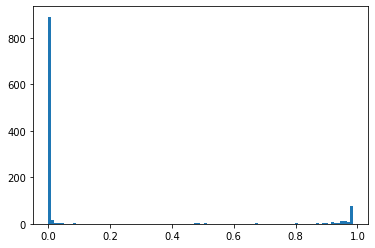

F1 score        : 0.33027522935779813
AUROC           : 0.7811394499600594
EER             : 0.2578740157480315
frr_at_eer      : 0.2898550724637681
far at zero frr : 0.8110236220472441
frr at 'zero' frr : 0.0


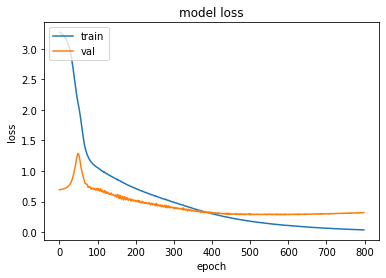

34/34 [==============================] - 1s 8ms/step
simpleConv


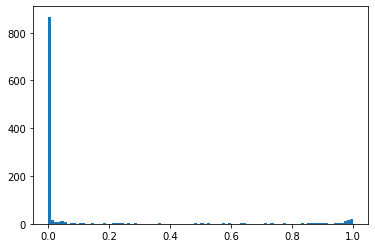

F1 score        : 0.2962962962962963
AUROC           : 0.7931216478374985
EER             : 0.2736220472440945
frr_at_eer      : 0.2753623188405797
far at zero frr : 0.781496062992126
frr at 'zero' frr : 0.0


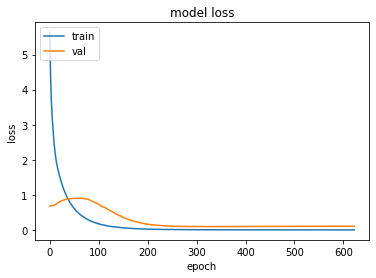

34/34 [==============================] - 0s 3ms/step
complexConv


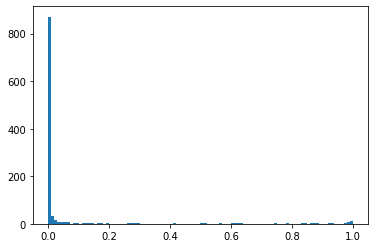

F1 score        : 0.3076923076923077
AUROC           : 0.8636311765377154
EER             : 0.2283464566929134
frr_at_eer      : 0.2318840579710145
far at zero frr : 0.5462598425196851
frr at 'zero' frr : 0.0


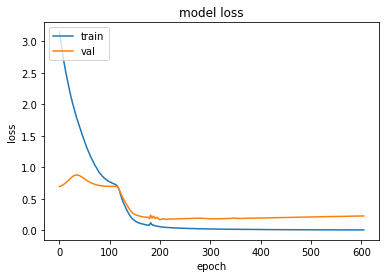

34/34 [==============================] - 1s 3ms/step
ConvLSTM


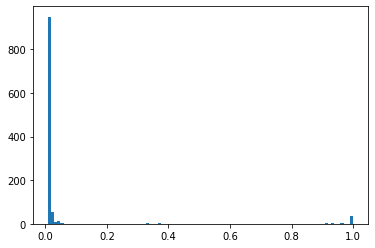

F1 score        : 0.42372881355932207
AUROC           : 0.750941458404656
EER             : 0.3228346456692913
frr_at_eer      : 0.3333333333333333
far at zero frr : 0.875
frr at 'zero' frr : 0.0
################   3   ####################
RF


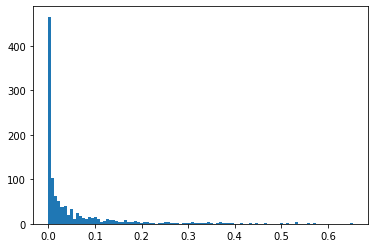

F1 score        : 0.19354838709677416
AUROC           : 0.9568829256026152
EER             : 0.09117361784675072
frr_at_eer      : 0.09259259259259259
far at zero frr : 0.5635305528612997
frr at 'zero' frr : 0.0


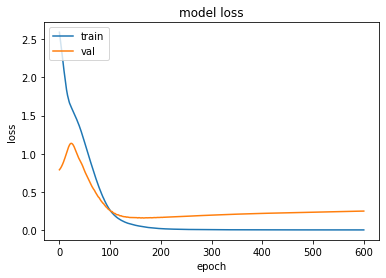

34/34 [==============================] - 0s 1ms/step
MLP


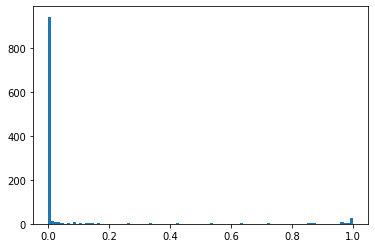

F1 score        : 0.32758620689655177
AUROC           : 0.8664277759816073
EER             : 0.21726479146459748
frr_at_eer      : 0.24074074074074073
far at zero frr : 0.5761396702230844
frr at 'zero' frr : 0.0


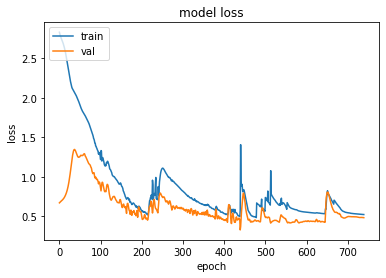

34/34 [==============================] - 1s 11ms/step
LSTM


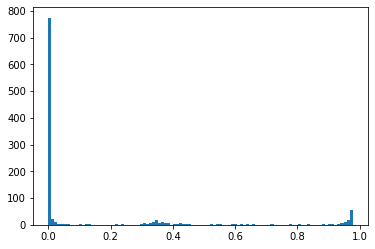

F1 score        : 0.2412060301507538
AUROC           : 0.8215684161367963
EER             : 0.27449078564500484
frr_at_eer      : 0.2777777777777778
far at zero frr : 0.7885548011639185
frr at 'zero' frr : 0.0


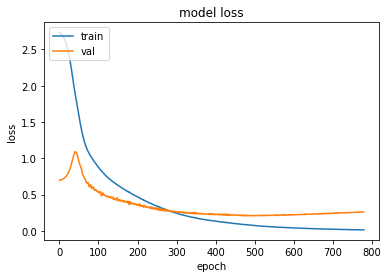

34/34 [==============================] - 1s 8ms/step
simpleConv


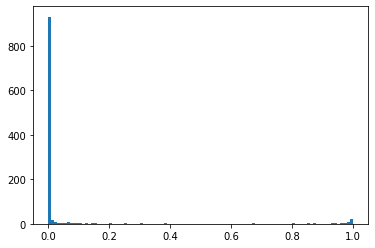

F1 score        : 0.5
AUROC           : 0.9501023817221683
EER             : 0.11057225994180407
frr_at_eer      : 0.1111111111111111
far at zero frr : 0.26576139670223087
frr at 'zero' frr : 0.0


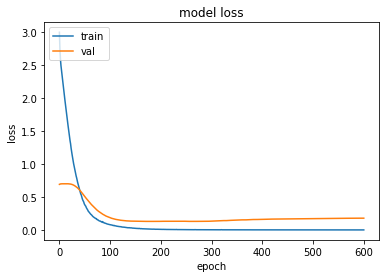

34/34 [==============================] - 0s 3ms/step
complexConv


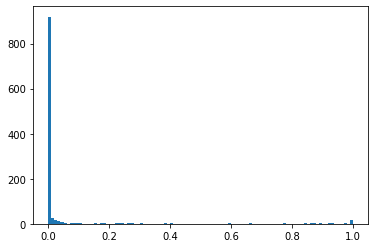

F1 score        : 0.45454545454545453
AUROC           : 0.9122211445198836
EER             : 0.1716779825412221
frr_at_eer      : 0.18518518518518517
far at zero frr : 0.4713870029097963
frr at 'zero' frr : 0.0


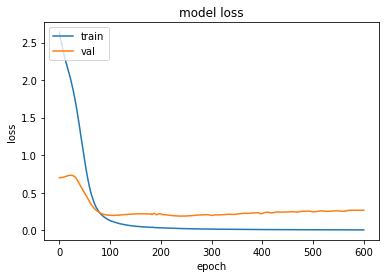

34/34 [==============================] - 1s 4ms/step
ConvLSTM


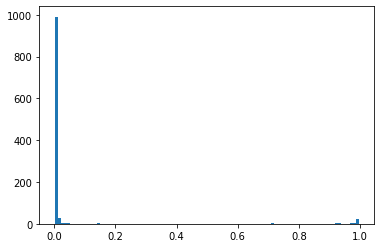

F1 score        : 0.585858585858586
AUROC           : 0.799295901138772
EER             : 0.20950533462657614
frr_at_eer      : 0.24074074074074073
far at zero frr : 0.9544131910766246
frr at 'zero' frr : 0.0
################   4   ####################
RF


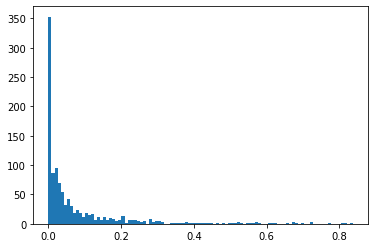

F1 score        : 0.4748201438848921
AUROC           : 0.9420430486944249
EER             : 0.12945973496432212
frr_at_eer      : 0.14423076923076922
far at zero frr : 0.5351681957186545
frr at 'zero' frr : 0.0


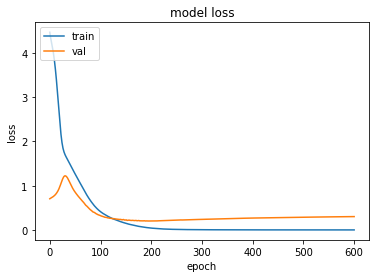

34/34 [==============================] - 0s 1ms/step
MLP


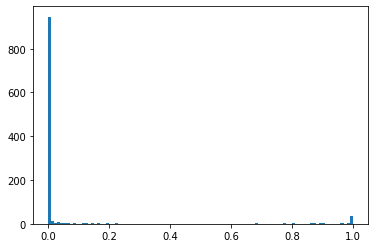

F1 score        : 0.4831460674157303
AUROC           : 0.8582392378263938
EER             : 0.20081549439347604
frr_at_eer      : 0.22115384615384615
far at zero frr : 0.8695208970438328
frr at 'zero' frr : 0.0


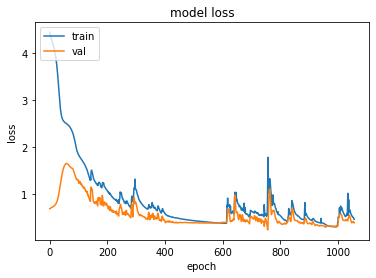

34/34 [==============================] - 1s 10ms/step
LSTM


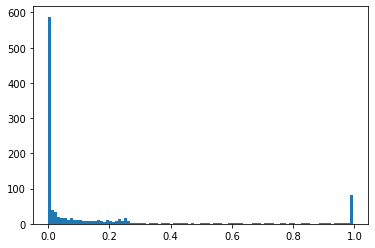

F1 score        : 0.6502057613168725
AUROC           : 0.914456402415118
EER             : 0.17737003058103976
frr_at_eer      : 0.18269230769230768
far at zero frr : 0.6646279306829765
frr at 'zero' frr : 0.0


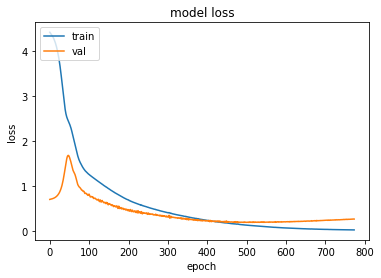

34/34 [==============================] - 1s 7ms/step
simpleConv


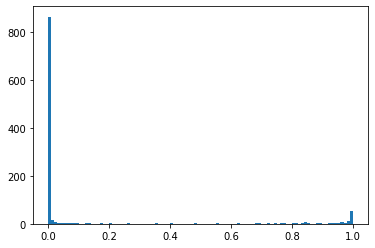

F1 score        : 0.7325102880658436
AUROC           : 0.9714478946130323
EER             : 0.07135575942915393
frr_at_eer      : 0.07692307692307693
far at zero frr : 0.5219164118246687
frr at 'zero' frr : 0.0


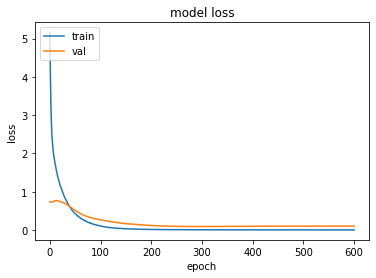

34/34 [==============================] - 0s 3ms/step
complexConv


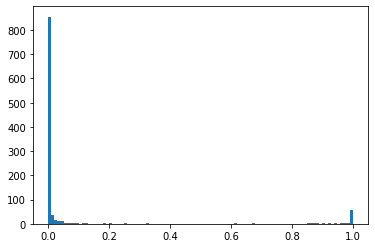

F1 score        : 0.8857142857142858
AUROC           : 0.994481690582608
EER             : 0.029561671763506627
frr_at_eer      : 0.038461538461538464
far at zero frr : 0.09887869520897044
frr at 'zero' frr : 0.0


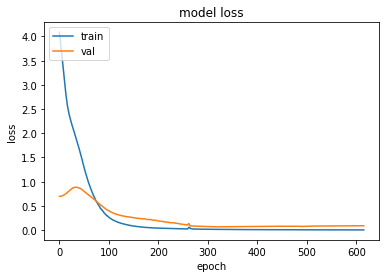

34/34 [==============================] - 2s 4ms/step
ConvLSTM


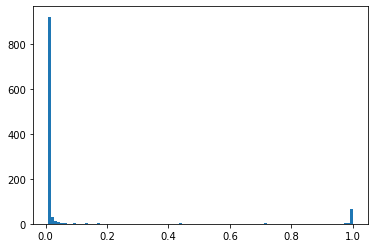

F1 score        : 0.7835051546391751
AUROC           : 0.9792695836273817
EER             : 0.05708460754332314
frr_at_eer      : 0.0673076923076923
far at zero frr : 0.763506625891947
frr at 'zero' frr : 0.0
################   5   ####################
RF


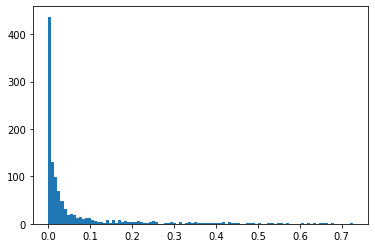

F1 score        : 0.3908045977011494
AUROC           : 0.9909429978888107
EER             : 0.04334975369458128
frr_at_eer      : 0.05714285714285714
far at zero frr : 0.054187192118226604
frr at 'zero' frr : 0.0


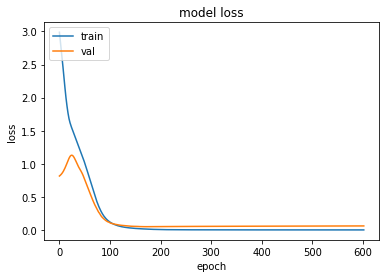

34/34 [==============================] - 0s 1ms/step
MLP


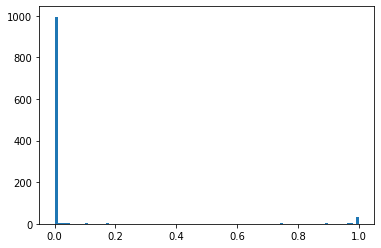

F1 score        : 0.796875
AUROC           : 0.972990851513019
EER             : 0.07881773399014778
frr_at_eer      : 0.08571428571428572
far at zero frr : 0.4
frr at 'zero' frr : 0.0


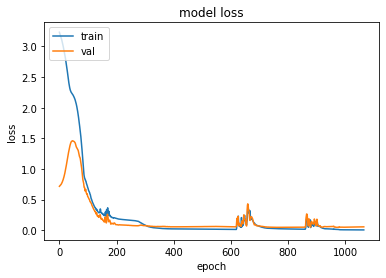

34/34 [==============================] - 2s 11ms/step
LSTM


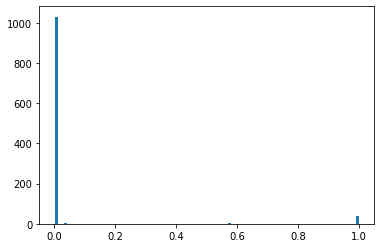

F1 score        : 0.6610169491525424
AUROC           : 0.8127375087966221
EER             : 0.2315270935960591
frr_at_eer      : 0.3142857142857143
far at zero frr : 0.7980295566502463
frr at 'zero' frr : 0.0


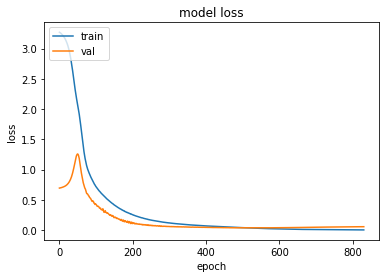

34/34 [==============================] - 1s 8ms/step
simpleConv


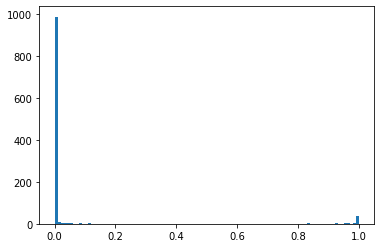

F1 score        : 0.8345323741007195
AUROC           : 0.9940323715693173
EER             : 0.03645320197044335
frr_at_eer      : 0.04285714285714286
far at zero frr : 0.08768472906403942
frr at 'zero' frr : 0.0


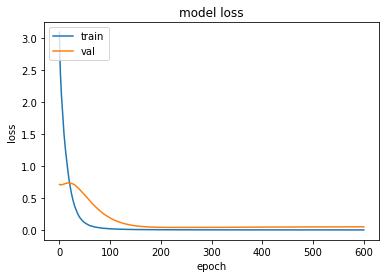

34/34 [==============================] - 0s 3ms/step
complexConv


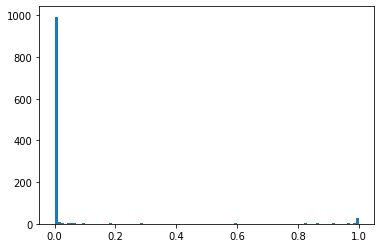

F1 score        : 0.8032786885245902
AUROC           : 0.9720056298381421
EER             : 0.04827586206896552
frr_at_eer      : 0.08571428571428572
far at zero frr : 0.4315270935960591
frr at 'zero' frr : 0.0


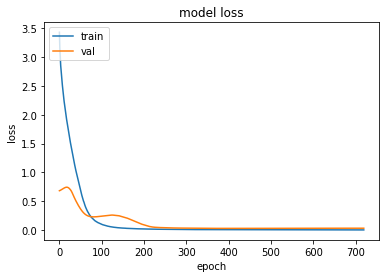

34/34 [==============================] - 1s 4ms/step
ConvLSTM


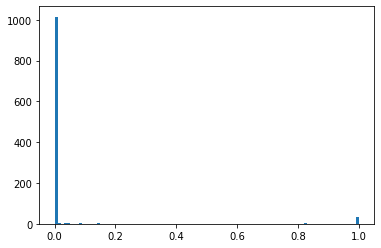

F1 score        : 0.7719298245614035
AUROC           : 0.9895285010555946
EER             : 0.05024630541871921
frr_at_eer      : 0.07142857142857142
far at zero frr : 0.10541871921182266
frr at 'zero' frr : 0.0
################   6   ####################
RF


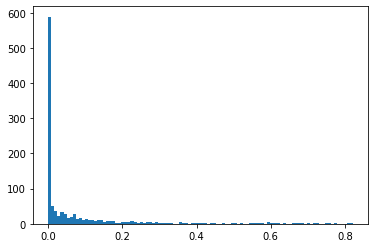

F1 score        : 0.7326732673267327
AUROC           : 0.9753595502127792
EER             : 0.05283757338551859
frr_at_eer      : 0.06349206349206349
far at zero frr : 1.0
frr at 'zero' frr : 0.0


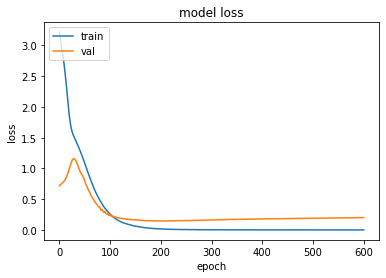

34/34 [==============================] - 0s 1ms/step
MLP


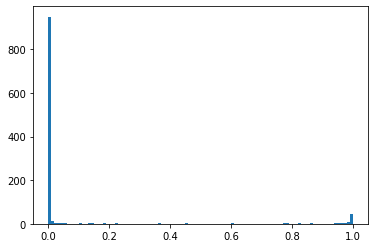

F1 score        : 0.7482993197278912
AUROC           : 0.9785046438666791
EER             : 0.07338551859099804
frr_at_eer      : 0.07936507936507936
far at zero frr : 0.38454011741682975
frr at 'zero' frr : 0.0


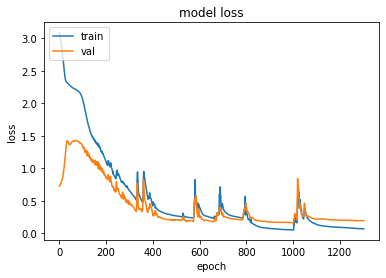

34/34 [==============================] - 1s 11ms/step
LSTM


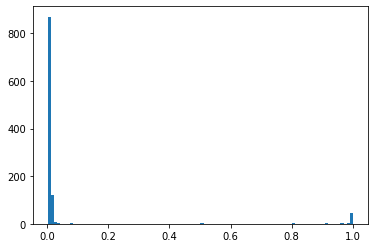

F1 score        : 0.5333333333333333
AUROC           : 0.8641785481315815
EER             : 0.2054794520547945
frr_at_eer      : 0.2222222222222222
far at zero frr : 1.0
frr at 'zero' frr : 0.0


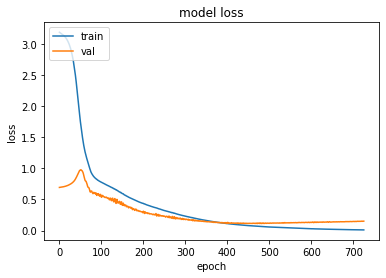

34/34 [==============================] - 1s 8ms/step
simpleConv


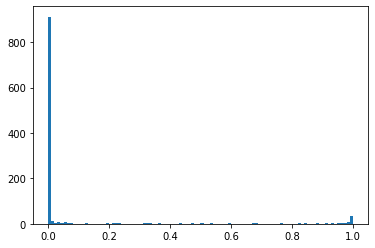

F1 score        : 0.7051282051282052
AUROC           : 0.9771378871183176
EER             : 0.04794520547945205
frr_at_eer      : 0.07936507936507936
far at zero frr : 0.3258317025440313
frr at 'zero' frr : 0.0


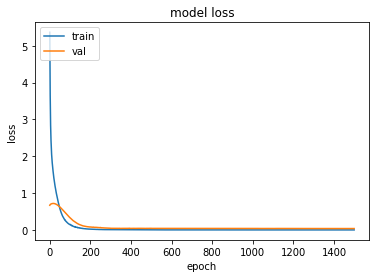

34/34 [==============================] - 0s 3ms/step
complexConv


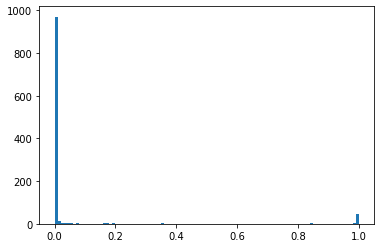

F1 score        : 0.8852459016393444
AUROC           : 0.9894386978535706
EER             : 0.03131115459882583
frr_at_eer      : 0.06349206349206349
far at zero frr : 0.2974559686888454
frr at 'zero' frr : 0.0


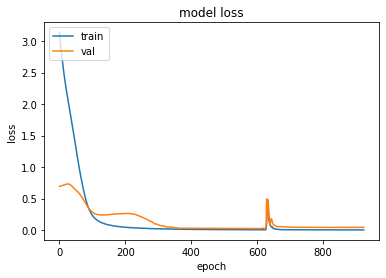

34/34 [==============================] - 1s 5ms/step
ConvLSTM


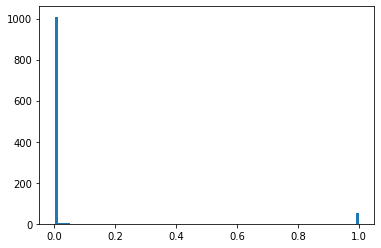

F1 score        : 0.8666666666666667
AUROC           : 0.9717795794116733
EER             : 0.036203522504892366
frr_at_eer      : 0.047619047619047616
far at zero frr : 0.8913894324853229
frr at 'zero' frr : 0.0
################   7   ####################
RF


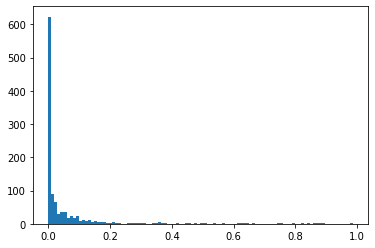

F1 score        : 0.5263157894736842
AUROC           : 0.964700914848698
EER             : 0.11133004926108374
frr_at_eer      : 0.11428571428571428
far at zero frr : 0.21280788177339902
frr at 'zero' frr : 0.0


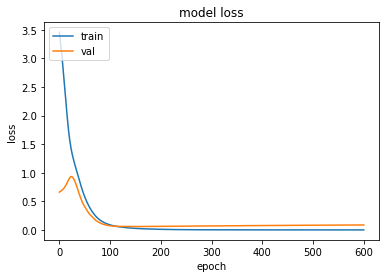

34/34 [==============================] - 0s 2ms/step
MLP


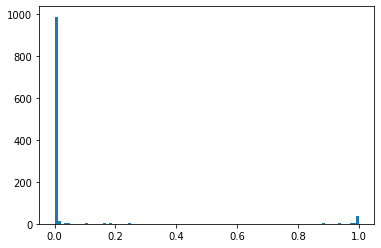

F1 score        : 0.6356589147286822
AUROC           : 0.9378184377199156
EER             : 0.11822660098522167
frr_at_eer      : 0.12857142857142856
far at zero frr : 0.6394088669950739
frr at 'zero' frr : 0.0


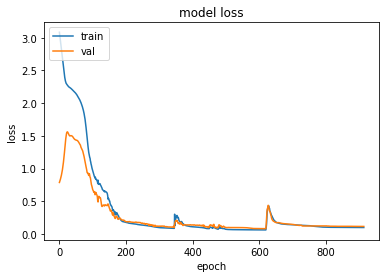

34/34 [==============================] - 1s 11ms/step
LSTM


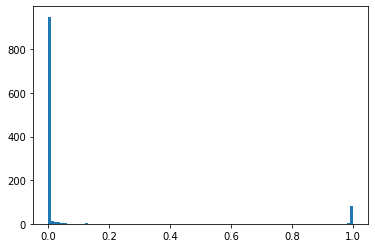

F1 score        : 0.6583850931677019
AUROC           : 0.9374243490499647
EER             : 0.0896551724137931
frr_at_eer      : 0.1
far at zero frr : 0.8492610837438423
frr at 'zero' frr : 0.0


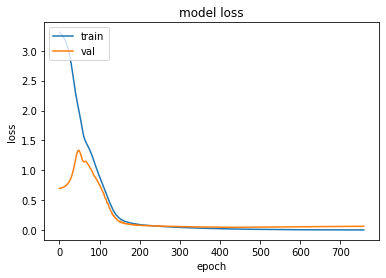

34/34 [==============================] - 1s 7ms/step
simpleConv


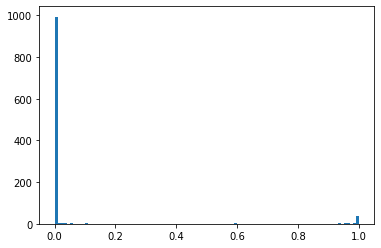

F1 score        : 0.8181818181818182
AUROC           : 0.9406896551724138
EER             : 0.04827586206896552
frr_at_eer      : 0.08571428571428572
far at zero frr : 0.8167487684729065
frr at 'zero' frr : 0.0


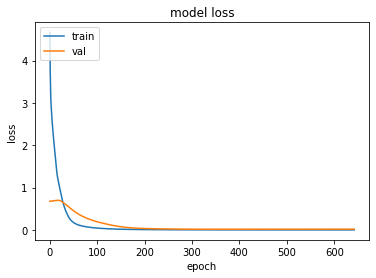

34/34 [==============================] - 0s 4ms/step
complexConv


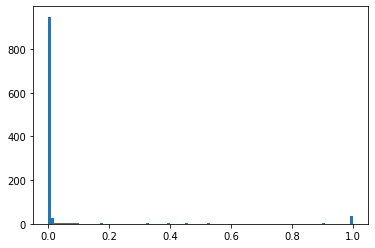

F1 score        : 0.8125
AUROC           : 0.9732019704433497
EER             : 0.06600985221674877
frr_at_eer      : 0.07142857142857142
far at zero frr : 0.7733990147783252
frr at 'zero' frr : 0.0


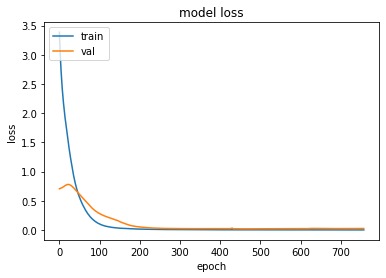

34/34 [==============================] - 1s 4ms/step
ConvLSTM


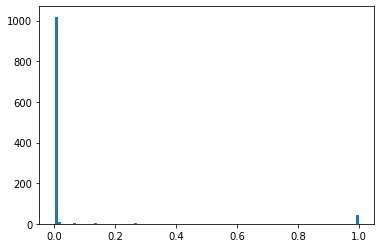

F1 score        : 0.8067226890756303
AUROC           : 0.9795073891625614
EER             : 0.06403940886699508
frr_at_eer      : 0.07142857142857142
far at zero frr : 0.6699507389162561
frr at 'zero' frr : 0.0
################   8   ####################
RF


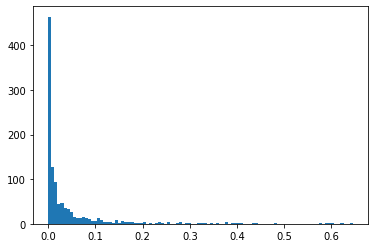

F1 score        : 0.09302325581395349
AUROC           : 0.9438312358159686
EER             : 0.1316793893129771
frr_at_eer      : 0.13513513513513514
far at zero frr : 0.3244274809160305
frr at 'zero' frr : 0.0


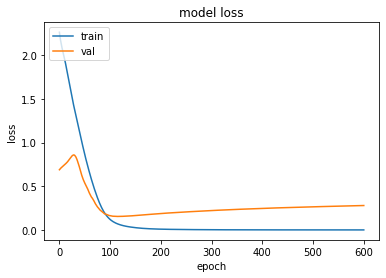

34/34 [==============================] - 0s 2ms/step
MLP


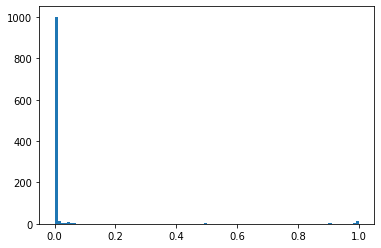

F1 score        : 0.5753424657534246
AUROC           : 0.9118526923870435
EER             : 0.16125954198473283
frr_at_eer      : 0.16216216216216217
far at zero frr : 0.7013358778625954
frr at 'zero' frr : 0.0


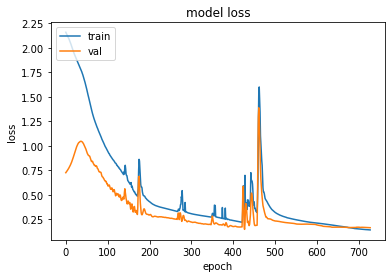

34/34 [==============================] - 1s 10ms/step
LSTM


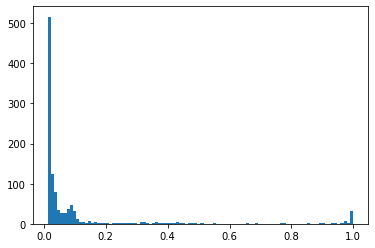

F1 score        : 0.608695652173913
AUROC           : 0.894651330720033
EER             : 0.15744274809160305
frr_at_eer      : 0.16216216216216217
far at zero frr : 0.9398854961832062
frr at 'zero' frr : 0.0


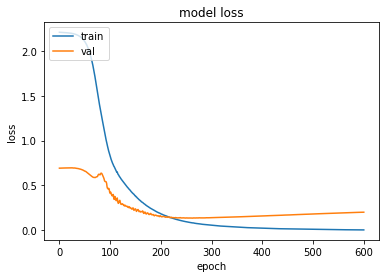

34/34 [==============================] - 1s 8ms/step
simpleConv


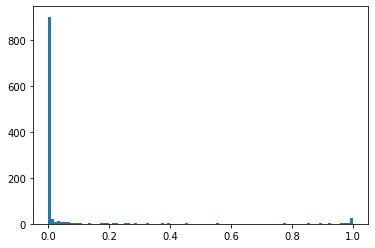

F1 score        : 0.5882352941176471
AUROC           : 0.9436249226325563
EER             : 0.05534351145038168
frr_at_eer      : 0.13513513513513514
far at zero frr : 0.5009541984732825
frr at 'zero' frr : 0.0


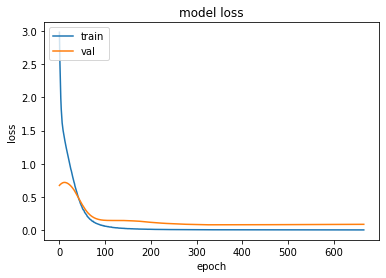

34/34 [==============================] - 0s 3ms/step
complexConv


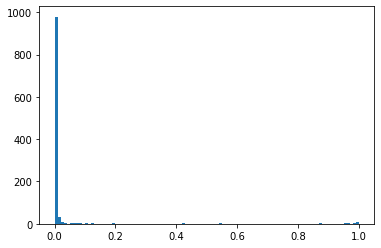

F1 score        : 0.6363636363636365
AUROC           : 0.9848875593150402
EER             : 0.04389312977099236
frr_at_eer      : 0.08108108108108109
far at zero frr : 0.19561068702290077
frr at 'zero' frr : 0.0


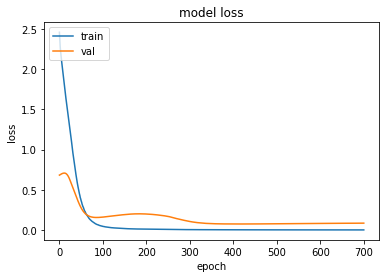

34/34 [==============================] - 1s 4ms/step
ConvLSTM


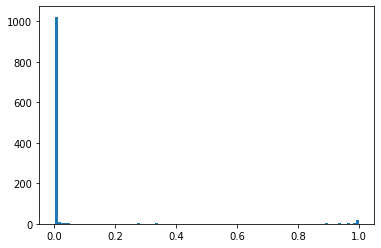

F1 score        : 0.6666666666666667
AUROC           : 0.9862543841551474
EER             : 0.05152671755725191
frr_at_eer      : 0.05405405405405406
far at zero frr : 0.05916030534351145
frr at 'zero' frr : 0.0
################   9   ####################
RF


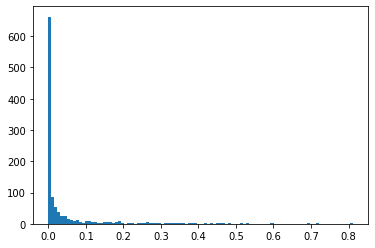

F1 score        : 0.2439024390243902
AUROC           : 0.9661360544217688
EER             : 0.0761904761904762
frr_at_eer      : 0.08571428571428572
far at zero frr : 0.18666666666666668
frr at 'zero' frr : 0.0


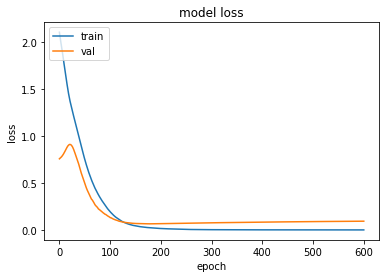

34/34 [==============================] - 0s 2ms/step
MLP


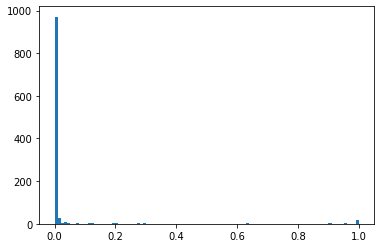

F1 score        : 0.5405405405405405
AUROC           : 0.8989659863945578
EER             : 0.12857142857142856
frr_at_eer      : 0.2
far at zero frr : 0.6
frr at 'zero' frr : 0.0


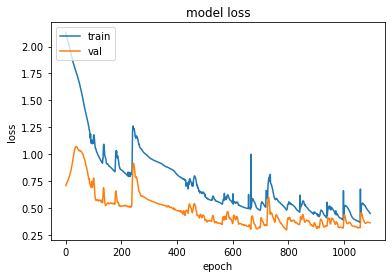

34/34 [==============================] - 2s 10ms/step
LSTM


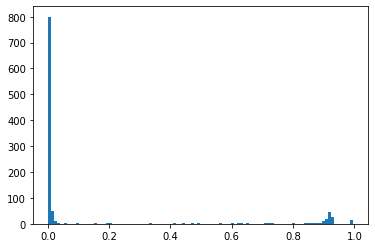

F1 score        : 0.28301886792452824
AUROC           : 0.9325170068027211
EER             : 0.13333333333333333
frr_at_eer      : 0.14285714285714285
far at zero frr : 0.2923809523809524
frr at 'zero' frr : 0.0


In [ ]:
limit_data=False
limit_data_string = "_limit_20" if limit_data else ""   # limit_bal_longer = 40* weighting, split into 4, limit_10 = 10%
limit_terminals = False
if limit_terminals:
    limit_data_string += "_terminals"
weight_boost = 4   # 40 for limit 10, 40 for limit 20

class_weights = {0:1, 1:15 * weight_boost}

for repetition in range(4,7):
    for auth_user in range(16):
        print(f"################   {auth_user}   ####################")

        if limit_terminals:
            _map = (train_gesture_map == 1) & ((y_gesture.argmax(axis=1) == 3) )
            _test_map = (test_gesture_map == 1) & (y_gesture.argmax(axis=1) != 3)
        else:
            _map = (train_gesture_map == 1)
            _test_map = (test_gesture_map == 1)           

        data_train = x_data[_map]
        feature_data_train = feature_x_data[_map]
        data_test = x_data[_test_map]
        feature_data_test = feature_x_data[_test_map]
        labels_train = (y_user.argmax(axis=1) == auth_user)[_map].astype(int)
        labels_test = (y_user.argmax(axis=1) == auth_user)[_test_map].astype(int)

        ## Train and run RF model  ##
        
            
        
        standard_scaler = StandardScaler()
        
        if limit_data:
            kFold = sklearn.model_selection.StratifiedKFold(n_splits=20)
            val_map = next(kFold.split(data_train, labels_train))[1]
            """
            val_map_all = np.zeros(len(labels_train))
            val_map_all[val_map] = 1
            
            limit_map = (val_map_all==1) | (labels_train == 0)
            """
            limit_map = val_map
            shuffled_data_train, shuffled_labels_train = shuffle(feature_data_train[limit_map], labels_train[limit_map], random_state=repetition)
        else:
            shuffled_data_train, shuffled_labels_train = shuffle(feature_data_train, labels_train, random_state=repetition)

        shuffled_data_train = standard_scaler.fit_transform(shuffled_data_train)

        wa_model = RandomForestClassifier(n_estimators = 1000, random_state = repetition, class_weight={0:1,1:1}).fit(shuffled_data_train, shuffled_labels_train)

        labels_pred = wa_model.predict(standard_scaler.transform(feature_data_test))
        labels_scores = wa_model.predict_proba(standard_scaler.transform(feature_data_test))[:, 1]

        save_stats_dict(labels_pred, labels_scores, labels_test, f"RF_user={auth_user}_rep={repetition}{limit_data_string}")

        print("RF")
        show_evaluate_model(labels_test, labels_pred, labels_scores, verbose=1)

        
####################################
        
        ## Train and run DL models  ## 

        if limit_data:
            kFold = sklearn.model_selection.StratifiedKFold(n_splits=20)
            val_map = next(kFold.split(data_train, labels_train))[1]
            
            limit_map = val_map
            
            shuffled_data_train, shuffled_labels_train = shuffle(data_train[limit_map], labels_train[limit_map], random_state=repetition)
        else:
            shuffled_data_train, shuffled_labels_train = shuffle(data_train, labels_train, random_state=repetition)
        
        
        
        scaler = CustomScaler()
        scaler.CHANNELS = 6
        shuffled_data_train = scaler.fit_and_transform(shuffled_data_train)
                       #)
        kFold = sklearn.model_selection.StratifiedKFold(n_splits=5)
        val_map = next(kFold.split(shuffled_data_train, shuffled_labels_train))[1]

        val_map_all = np.zeros(len(shuffled_labels_train))
        val_map_all[val_map] = 1

        val_map = val_map_all == 1
        
        #print(np.unique(shuffled_labels_train[~val_map], return_counts=True))

        early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', start_from_epoch=300,
                                                                   patience=300, restore_best_weights=True)

        for model_name in ["MLP", "LSTM", "simpleConv", "complexConv", "ConvLSTM"]:
            
            if model_name == "MLP":
                model = get_mlp_model()
            elif model_name == "LSTM":
                model = get_lstm_model()
            elif model_name == "simpleConv":
                model = get_simple_conv_model()
            elif model_name == "complexConv":
                model = get_complex_conv_model()
            elif model_name == "ConvLSTM":
                model = get_conv_lstm_model()
            else:
                assert False, "Not a valid model string"

            model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

            history = model.fit(shuffled_data_train[~val_map], shuffled_labels_train[~val_map], epochs=1500,
                        batch_size=1024, verbose=0,
                        validation_data=(shuffled_data_train[val_map], shuffled_labels_train[val_map]),
                       class_weight=class_weights, 
                   callbacks=[early_stopping_callback])


            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'val'], loc='upper left')
            plt.show()

            plt.clf()

            with suppress_stdout():

                with open(f'data/models/DL/{model_name}_user={auth_user}_rep={repetition}{limit_data_string}.pickle', 'wb') as f:
                    pickle.dump(model, f)

                with open(f'data/stats/auth/{model_name}_user={auth_user}_history_rep={repetition}{limit_data_string}.pickle', 'wb') as f:
                    pickle.dump(history, f)


            labels_scores = model.predict(scaler.transform(data_test)).squeeze()
            labels_pred = (labels_scores >= 0.5).astype(int)


            save_stats_dict(labels_pred, labels_scores, labels_test, f"{model_name}_user={auth_user}_rep={repetition}{limit_data_string}")
            print(model_name)
            show_evaluate_model(labels_test, labels_pred, labels_scores, verbose=1)
    

In [ ]:
print("Done")

# Accessing saved results

In [46]:
handle = "complexConv_user=2_rep=5"
with open(f'data/stats/auth/{handle}.pickle', 'rb') as f:
    labels_dict = pickle.load(f)
    stats_dict = show_evaluate_model(labels_dict["labels_test"],
                                     labels_dict["labels_pred"],
                                     labels_dict["labels_scores"], verbose=0)
stats_dict

{'fmeasure': 0.23776223776223776,
 'auroc': 0.8198961542850621,
 'eer_theta': 0.0036525303,
 'eer': 0.2440944881889764,
 'frr_at_eer': 0.2463768115942029,
 'far_theta': 1.969508e-06,
 'far': 0.9124015748031497,
 'frr_at_zero_frr': 0.0,
 'accuracy': 0.8995391705069125}

In [109]:
mins = []
for user in range(16):
    print(user)
    pairs = []
    for rep in range(6):
        handle1 = f"complexConv_user={user}_history_rep={rep}"
        handle2 = f"complexConv_user={user}_rep={rep}"
        with open(f'data/stats/auth/{handle1}.pickle', 'rb') as f:

            with suppress_stdout():
                history = pickle.load(f)


        with open(f'data/stats/auth/{handle2}.pickle', 'rb') as f:
            labels_dict = pickle.load(f)
            stats_dict = show_evaluate_model(labels_dict["labels_test"],
                                             labels_dict["labels_pred"],
                                             labels_dict["labels_scores"], verbose=0)
        #print(min(history.history["val_loss"]), stats_dict["eer"])
        pairs.append((min(history.history["val_loss"]), stats_dict["far"]))
    print(min(pairs))
    print(max(pairs))
    mins.append(min(pairs)[1])
print(np.mean(np.array(mins)))

0
(0.06754449009895325, 0.05680705190989226)
(0.08080145716667175, 0.0969637610186092)
1
(0.07690088450908661, 0.23121951219512196)
(0.11428630352020264, 0.7736585365853659)
2
(0.10276365280151367, 0.890748031496063)
(0.1604945957660675, 0.9901574803149606)
3
(0.07965211570262909, 0.9515033947623667)
(0.14299626648426056, 0.5489815712900097)
4
(0.0660034641623497, 0.16411824668705402)
(0.11531417071819305, 0.40978593272171254)
5
(0.022142358124256134, 0.7773399014778325)
(0.04852002486586571, 0.5980295566502463)
6
(0.03680743649601936, 0.18297455968688844)
(0.11762841790914536, 0.6213307240704501)
7
(0.006813190411776304, 0.5970443349753695)
(0.03235175833106041, 0.6492610837438424)
8
(0.06896059960126877, 0.35877862595419846)
(0.10611427575349808, 0.09255725190839695)
9
(0.044876135885715485, 0.7104761904761905)
(0.11422166973352432, 0.7161904761904762)
10
(0.12130916863679886, 0.8918387413962635)
(0.18920785188674927, 0.8888888888888888)
11
(0.10214070975780487, 0.708)
(0.18594622611

In [107]:
print(np.mean(np.array(mins)))

0.07630291891347632


In [49]:

model_names = ["RF", "MLP", "LSTM", "simpleConv", "complexConv", "ConvLSTM"]

all_stats_user = {}
for model_name in model_names:
    
    
    for user in range(16):
        stats = {key:[] for key in stats_dict}
        all_stats_user[model_name + f"_{user}"] = stats
        for repetition in range(6):
            
                
            handle = f"{model_name}_user={user}_rep={repetition}"
            with open(f'data/stats/auth/{handle}.pickle', 'rb') as f:
                labels_dict = pickle.load(f)
                stats_dict = show_evaluate_model(labels_dict["labels_test"],
                                                 labels_dict["labels_pred"],
                                                 labels_dict["labels_scores"], verbose=0)
                for key in stats_dict:
                    stats[key].append(stats_dict[key])

In [95]:
x = PrettyTable()

model_name = "RF"

x.field_names =  ['user', 'fmeasure', 'auroc', 'eer_theta', 'eer', 'frr_at_eer', 'far_theta', 'far',  'accuracy'] # 'frr_at_zero_frr',
print(x.field_names)
for user in range(16):
    row = [user]
    for key in all_stats_user[f"{model_name}_{user}"]:
        if key not in ["frr_at_zero_frr"]:
            array = np.array(all_stats_user[f"{model_name}_{user}"][key])
            mean = round(float(np.median(array)), 3)
            std = round(float(np.std(array)),3)
            row.append(f"{mean} ") # {std}
    
    x.add_row(row)

print(x)

['user', 'fmeasure', 'auroc', 'eer_theta', 'eer', 'frr_at_eer', 'far_theta', 'far', 'accuracy']
+------+----------+--------+-----------+--------+------------+-----------+--------+----------+
| user | fmeasure | auroc  | eer_theta |  eer   | frr_at_eer | far_theta |  far   | accuracy |
+------+----------+--------+-----------+--------+------------+-----------+--------+----------+
|  0   |  0.573   | 0.967  |   0.124   | 0.085  |   0.094    |   0.013   | 0.382  |  0.959   |
|  1   |  0.351   | 0.963  |   0.148   | 0.086  |    0.1     |   0.034   | 0.385  |  0.956   |
|  2   |  0.056   | 0.811  |   0.061   | 0.274  |   0.29     |   0.004   | 0.82   |  0.938   |
|  3   |   0.2    | 0.952  |   0.12    | 0.09   |   0.111    |   0.002   | 0.729  |  0.956   |
|  4   |  0.443   | 0.943  |   0.116   | 0.135  |   0.139    |   0.025   | 0.467  |  0.93    |
|  5   |   0.4    | 0.991  |   0.172   | 0.039  |   0.043    |   0.124   | 0.064  |  0.952   |
|  6   |  0.735   | 0.978  |   0.197   | 0.059  |

### Comparison of different models

In [110]:
"""
model_names = ["RF", "MLP", "LSTM", "simpleConv", "complexConv", "ConvLSTM"]

all_stats = {}
for model_name in model_names:
    stats = {key:[] for key in stats_dict}
    all_stats[model_name] = stats
    for user in range(16):
        for repetition in range(6):
            
                
            handle = f"{model_name}_user={user}_rep={repetition}"
            with open(f'data/stats/auth/{handle}.pickle', 'rb') as f:
                labels_dict = pickle.load(f)
                stats_dict = show_evaluate_model(labels_dict["labels_test"],
                                                 labels_dict["labels_pred"],
                                                 labels_dict["labels_scores"], verbose=0)
                for key in stats_dict:
                    stats[key].append(stats_dict[key])
"""

model_names = ["RF", "MLP", "LSTM", "simpleConv", "complexConv", "ConvLSTM"]

all_stats = {}
for model_name in model_names:
    stats = {key:[] for key in stats_dict}
    all_stats[model_name] = stats
    for user in range(16):
        for repetition in range(6):
            test = []
            pred = []
            scores = []
                
            handle = f"{model_name}_user={user}_rep={repetition}"
            with open(f'data/stats/auth/{handle}.pickle', 'rb') as f:
                labels_dict = pickle.load(f)
                stats_dict = show_evaluate_model(labels_dict["labels_test"],
                                                 labels_dict["labels_pred"],
                                                 labels_dict["labels_scores"], verbose=0)
                for key in stats_dict:
                    stats[key].append(stats_dict[key])

In [112]:

from prettytable import PrettyTable

x = PrettyTable()
x.field_names =  ['model', 'fmeasure', 'auroc', 'eer_theta', 'eer', 'frr_at_eer', 'far_theta', 'far',  'accuracy'] # 'frr_at_zero_frr',
print(x.field_names)
for model_name in all_stats:
    row = [model_name]
    for key in all_stats[model_name]:
        if key not in ["frr_at_zero_frr"]:
            array = np.array(all_stats[model_name][key])
            mean = round(float(np.mean(array)), 3)
            std = round(float(np.std(array)),3)
            row.append(f"{mean} {std}") # {std}
    
    x.add_row(row)

print(x)
                         

['model', 'fmeasure', 'auroc', 'eer_theta', 'eer', 'frr_at_eer', 'far_theta', 'far', 'accuracy']
+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|    model    |   fmeasure  |    auroc    |  eer_theta  |     eer     |  frr_at_eer |  far_theta  |     far     |   accuracy  |
+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|      RF     |  0.388 0.24 | 0.956 0.042 | 0.136 0.048 | 0.094 0.059 |  0.108 0.06 | 0.043 0.038 | 0.379 0.241 | 0.955 0.014 |
|     MLP     |  0.607 0.17 | 0.933 0.062 |  0.019 0.04 | 0.115 0.075 |  0.136 0.08 |  0.0 0.001  | 0.493 0.263 | 0.951 0.023 |
|     LSTM    |  0.563 0.15 | 0.887 0.088 | 0.164 0.247 | 0.137 0.082 | 0.171 0.092 | 0.009 0.019 | 0.785 0.236 | 0.924 0.046 |
|  simpleConv | 0.651 0.169 | 0.954 0.055 | 0.125 0.159 | 0.088 0.061 | 0.105 0.065 | 0.008 0.049 | 0.393 0.214 | 0.949 0.026 |
| compl

In [12]:
!pip install prettytable